In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import pyreadstat
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.cluster import hierarchy
from imblearn.over_sampling import SMOTENC , SMOTE, ADASYN ,RandomOverSampler,SVMSMOTE
from imblearn.pipeline import Pipeline
from imblearn.keras import balanced_batch_generator
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder,RobustScaler,MinMaxScaler
from sklearn.decomposition import KernelPCA,PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score, recall_score, precision_score,zero_one_loss
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,permutation_test_score,train_test_split,cross_validate,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.feature_selection import RFECV, mutual_info_classif,SelectPercentile ,mutual_info_regression,SequentialFeatureSelector
from sklearn.compose import ColumnTransformer 
from sklearn import set_config
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import torch.nn as nn
from sklearn import feature_selection

In [2]:
torch.cuda.is_available()

True

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
file=files.upload()

Saving ML mortality_vareng.sav to ML mortality_vareng.sav


In [ ]:
df=pd.read_spss('/content/ML mortality_vareng.sav')
print(df ,'\n\n' ,df.isna().sum())

      deceased   age gender  ... other_chronic_lung  htn Epil1CNS2Other3No0
0            0  83.0     زن  ...                بلی  بلی                3.0
1            1  94.0     زن  ...                بلی  بلی                3.0
2            0  61.0     زن  ...                بلی  بلی                3.0
3            0  66.0     زن  ...                بلی  بلی                3.0
4            1  75.0    مرد  ...                بلی  بلی                3.0
...        ...   ...    ...  ...                ...  ...                ...
28911        0  91.0    مرد  ...                خیر  خیر                0.0
28912        0  92.0    مرد  ...                خیر  خیر                0.0
28913        0  92.0    مرد  ...                خیر  خیر                0.0
28914        0  93.0    مرد  ...                خیر  خیر                0.0
28915        0  95.0    مرد  ...                خیر  خیر                0.0

[28916 rows x 33 columns] 

 deceased                 0
age                      0
gend

In [ ]:
df.replace({'ندارد':0.,'دارد':1.,'خیر':0.,'بلی':1.,'زن':0.,'مرد':1.,'کمتر از 93 درصد':0.,'بیشتر از 93 درصد':1.},inplace=True)
df

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,seizure,headache,dizziness,chest_pain,abd_pain,nausea,vomiting,diarrhea,anorexia,smoking,Po2,cancer,chronic_liver_disease,diabetes,chronic_dishem,HIVAIDS,immune_deficient,pregnancy,discardio,dis_chronic_renal,asthma,other_chronic_lung,htn,Epil1CNS2Other3No0
0,0,83.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
1,1,94.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
2,0,61.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
3,0,66.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
4,1,75.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28911,0,91.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28912,0,92.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28913,0,92.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28914,0,93.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pyreadstat.write_sav(df,'ML mortality_processed.sav')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp 'ML mortality_processed.sav' '/content/drive/MyDrive/ML mortality_processed.sav'

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df=pd.read_spss('ML mortality_processed.sav').astype(np.float64)
print(df,' \n\n',df.isna().sum())

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  seizur

In [3]:
df['Po2']=np.where(df.loc[:,'Po2'].values==0,1,0)
asthma_indices=np.where(df.loc[:,'asthma'].values==1)[0]
df.loc[asthma_indices,'other_chronic_lung']=1

df.drop(['seizure','asthma','Epil1CNS2Other3No0','smoking','HIVAIDS','immune_deficient','chronic_dishem'],axis=1,inplace=True)

In [4]:
df.drop(df[df['age']<18].index,axis=0,inplace=True)
print(df)

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  headac

In [5]:
#checking external consistency
x=df.loc[df['gender']==1,'pregnancy']
ext=np.where(x.values==1,x.index,0)
ext=ext[np.where(ext!=0)[0]]
print(ext)

[9045]


In [6]:
#checking external consistency
df.loc[ext,:]

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,headache,...,anorexia,Po2,cancer,chronic_liver_disease,diabetes,pregnancy,discardio,dis_chronic_renal,other_chronic_lung,htn
9045,0.0,30.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
df_ext=df.drop(labels=ext[0],axis=0)
df_ext.drop(['pregnancy'],axis=1,inplace=True)
print(df_ext)

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  headac

In [8]:
df_ext.describe()

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,headache,...,diarrhea,anorexia,Po2,cancer,chronic_liver_disease,diabetes,discardio,dis_chronic_renal,other_chronic_lung,htn
count,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,...,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000
mean,0.096904,55.423443,0.519039,0.329482,0.454400,0.361929,0.530303,0.017840,0.010828,0.125027,...,0.033319,0.108895,0.628261,0.018276,0.004905,0.153586,0.122557,0.022455,0.039169,0.223240
std,0.295833,17.971245,0.499646,0.470034,0.497925,0.480567,0.499090,0.132373,0.103493,0.330756,...,0.179471,0.311513,0.483278,0.133951,0.069866,0.360558,0.327933,0.148160,0.194000,0.416425
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,56.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,105.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


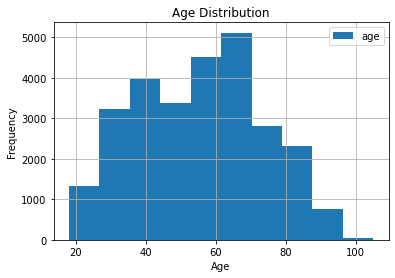

In [9]:
df_ext['age'].hist(legend=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [10]:
ks,p=stats.kstest(rvs=df_ext['age'].values,cdf='norm',alternative='two-sided', mode='auto')
ks,p

(1.0, 0.0)

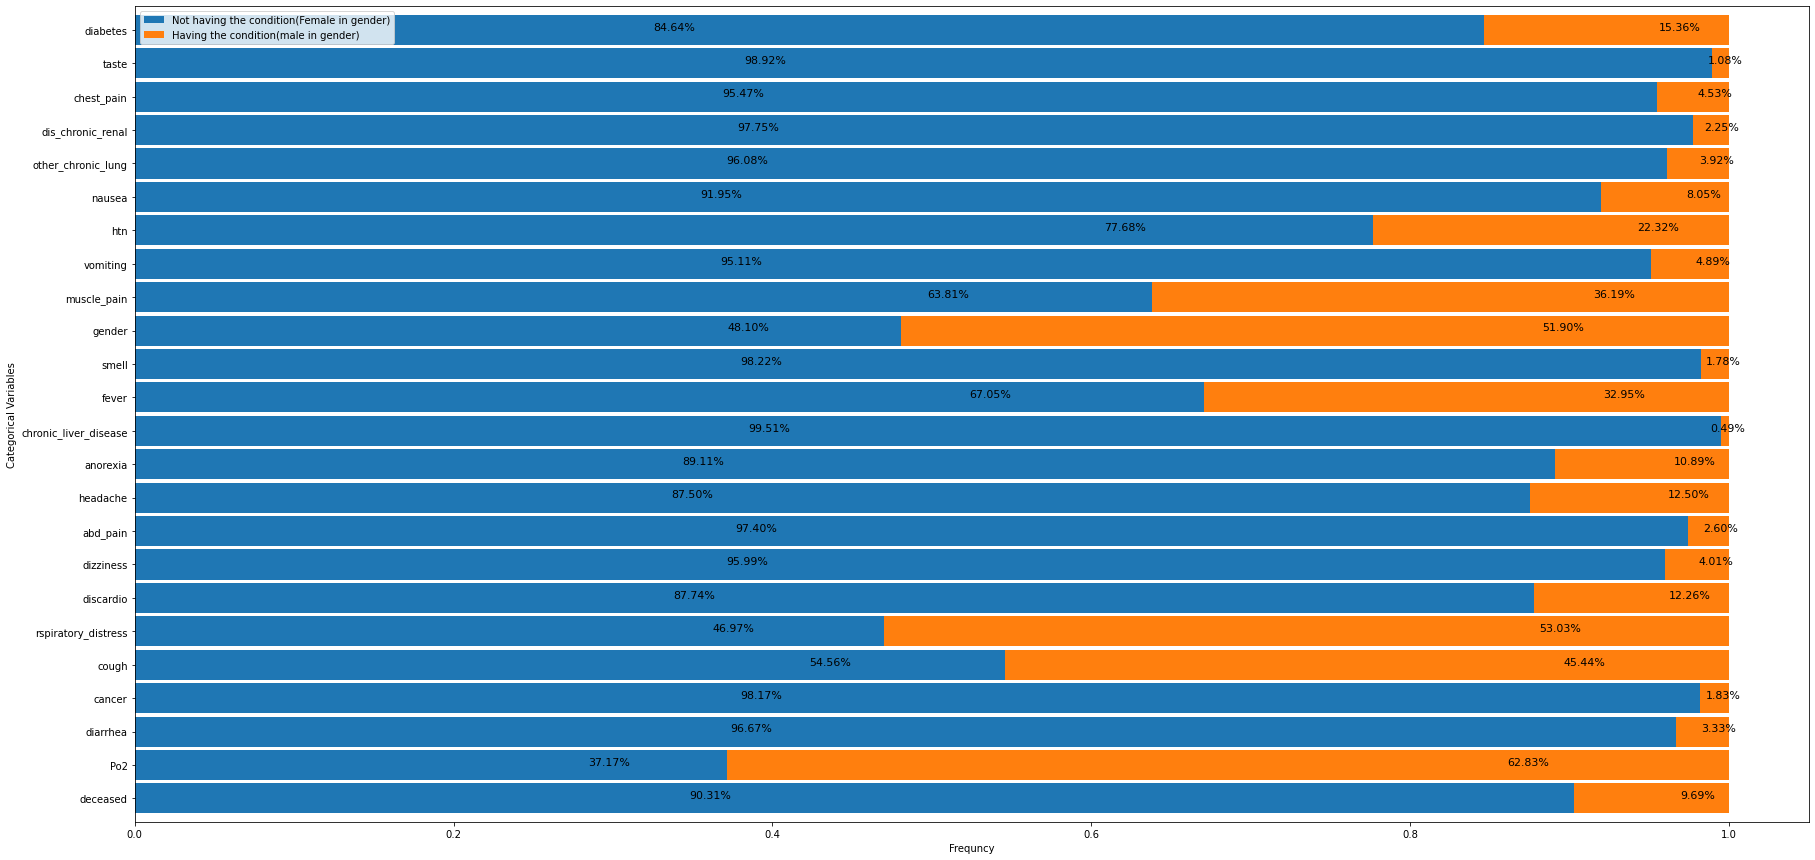

In [11]:
df_stacked=pd.DataFrame({'Not having the condition(Female in gender)':[df_ext.loc[:,i].isin([0.]).sum() for i in (set(df_ext.columns.to_list())-{'age'})]
                         ,'Having the condition(male in gender)':[df_ext.loc[:,i].isin([1.]).sum() for i in (set(df_ext.columns.to_list())-{'age'})]},
                        index=set(df_ext.columns.to_list())-{'age'})
 
df_stacked_normalized=df_stacked.div(df_stacked.sum(axis=1),axis=0)



plot=df_stacked_normalized.plot(kind='barh',stacked=True,rot=0,width=0.9,figsize=(30,15))


for p in plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if width==0:
        continue
    if width<0.8:
        plot.annotate(f'{100*width:.2f}%', (x + 0.8*width, y + height/2), ha='center',fontsize=11)
    if width>=0.8:
        plot.annotate(f'{100*width:.2f}%', (x + 0.4*width, y + height/2), ha='center',fontsize=11)
    

    
plot.set_xlabel('Frequncy')
plot.set_ylabel('Categorical Variables')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#pyreadstat.write_sav(df1,'preprocessed.sav')

In [12]:
x_train,x_test,y_train,y_test = train_test_split(df_ext.iloc[:,1:].values,df_ext.iloc[:,0].values,
                                                 test_size=0.2,stratify=df_ext.iloc[:,0].values,random_state=42)

In [13]:
x_train

array([[56.,  0.,  0., ...,  0.,  0.,  0.],
       [58.,  0.,  0., ...,  0.,  0.,  0.],
       [41.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [35.,  1.,  0., ...,  0.,  0.,  0.],
       [62.,  0.,  0., ...,  0.,  0.,  0.],
       [37.,  1.,  1., ...,  0.,  0.,  0.]])

In [14]:
x_train.shape ,x_test.shape

((22017, 24), (5505, 24))

In [15]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [16]:
column_transfromer=ColumnTransformer([('minmax',MinMaxScaler(),[0]),
                                      ('pass','passthrough',np.arange(1,24))])
set_config(display='diagram')
column_transfromer

ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0]),
                                ('pass', 'passthrough',
                                 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23]))])

In [17]:
pip_analysis=Pipeline([('transformation',column_transfromer),
                       ('classification',svm.SVC(class_weight='balanced'))])
pip_analysis.fit(x_train,y_train)

preds=pip_analysis.predict(x_test)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3309 1663]
 [ 122  411]] 0.718316946381915


In [18]:
pip_analysis=Pipeline([('transformation',column_transfromer),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
pip_analysis.fit(x_train,y_train)

preds=pip_analysis.predict(x_test)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3411 1561]
 [ 118  415]] 0.7323267332710458


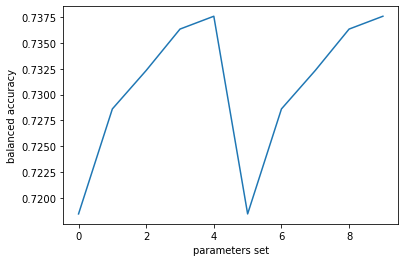

In [19]:
parameters=[(5,15),(5,35),(5,55),(5,75),(5,100),(10,15),(10,35),(10,55),(10,75),(5,100)]

scores_calculated=[]

for i,j in parameters:
    
    def Feature_selection(x,y,n_neighbors=i,random_state=42):
        return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                                   discrete_features=np.arange(1,x.shape[1]),random_state=random_state)
    
    pip_analysis=Pipeline([('transformation',column_transfromer),
                           ('feature_selection',SelectPercentile(Feature_selection,percentile=j)),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
    
    cross_val_scores=cross_val_score(pip_analysis,x_train,y_train,scoring='balanced_accuracy',cv=skf,n_jobs=-1)
    mean=np.mean(cross_val_scores)
    scores_calculated.append(mean)

plt.plot(scores_calculated)
plt.xlabel('parameters set')
plt.ylabel('balanced accuracy')
plt.show()

In [20]:



a=[]

for i,j in [(5,92),(5,100)]:
    
    def Feature_selection(x,y,n_neighbors=i,random_state=42):
        
        return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                               discrete_features=np.arange(1,x.shape[1]),random_state=random_state)
    
    pip_analysis=Pipeline([('transformation',column_transfromer),
                           ('feature_selection',SelectPercentile(Feature_selection,percentile=j)),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
    
    cross_val_scores=cross_val_score(pip_analysis,x_train,y_train,scoring='balanced_accuracy',cv=skf,n_jobs=-1)
    
    a.append(cross_val_scores)
    
    
u,p=stats.wilcoxon(a[0],a[1],zero_method='zsplit',mode='approx',alternative='less')

print (f' 92% of best features:{np.mean(a[0])}+/-{np.std(a[0])}\n\n whole features:{np.mean(a[1])}+/-{np.std(a[1])}\n\nwilcoxon:{u},{p}')

 92% of best features:0.7374136701017863+/-0.014994420595575627

 whole features:0.7375729971045266+/-0.01475540353328772

wilcoxon:23.0,0.3226938739346845


In [21]:
x_train_transfromer=column_transfromer.fit_transform(x_train)
x_test_transfromer=column_transfromer.transform(x_test)

In [22]:
x_train_transfromer[:,0].min()

0.0

In [23]:
def Feature_selection(x,y,n_neighbors=5,random_state=42):
    
    return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                               discrete_features=np.arange(1,x.shape[1]),random_state=random_state)

scores=SelectPercentile(Feature_selection,percentile=92)

result_train=scores.fit_transform(x_train_transfromer,y_train)
result_test=scores.transform(x_test_transfromer)

print(result_train.shape,result_test.shape,np.argsort(scores.scores_)[::-1])

(22017, 22) (5505, 22) [ 0 16  5 23 20 19  4  3  8  2 21 17 12  6  9  1 18 14 13 22  7 10 11 15]


In [24]:
indices=np.argsort(scores.scores_)[:-23:-1]
indices

array([ 0, 16,  5, 23, 20, 19,  4,  3,  8,  2, 21, 17, 12,  6,  9,  1, 18,
       14, 13, 22,  7, 10], dtype=int64)

In [28]:
columns=np.array([                  'Age',                'Male sex',                 'Fever',
                 'Cough',           'Muscle pain',   'Respiratory distress',
                 'Loss of smell',                 'Loss of taste',       
              'Headache',             'Dizziness',            'Chest pain',
              'Abdominal pain',                'Nausea',              'Vomiting',
              'Diarrhea',              'Anorexia',               
                   'O2 saturation under 93',                'Cancer', 'Liver disease',
              'Diabetes',                    
                  'Cardiac disease',
     'Renal disease',    'Pulmonary disease',                   'Hypertension'])
columns,columns.shape

(array(['Age', 'Male sex', 'Fever', 'Cough', 'Muscle pain',
        'Respiratory distress', 'Loss of smell', 'Loss of taste',
        'Headache', 'Dizziness', 'Chest pain', 'Abdominal pain', 'Nausea',
        'Vomiting', 'Diarrhea', 'Anorexia', 'O2 saturation under 93',
        'Cancer', 'Liver disease', 'Diabetes', 'Cardiac disease',
        'Renal disease', 'Pulmonary disease', 'Hypertension'], dtype='<U22'),
 (24,))

In [36]:
x_train_f=x_train[:,[ 0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23]]
x_test_f=x_test[:,[ 0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23]]

In [37]:
column_transfromer_f=ColumnTransformer([('minmax',MinMaxScaler(),[0]),('pass','passthrough',np.arange(1,22))])
column_transfromer_f

ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0]),
                                ('pass', 'passthrough',
                                 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]))])

In [38]:
col=columns[[ 0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23]]

In [39]:
col,col.shape

(array(['Age', 'Male sex', 'Fever', 'Cough', 'Muscle pain',
        'Respiratory distress', 'Loss of smell', 'Loss of taste',
        'Headache', 'Dizziness', 'Chest pain', 'Nausea', 'Vomiting',
        'Diarrhea', 'O2 saturation under 93', 'Cancer', 'Liver disease',
        'Diabetes', 'Cardiac disease', 'Renal disease',
        'Pulmonary disease', 'Hypertension'], dtype='<U22'),
 (22,))

In [40]:
df_ext.columns[[ 1,2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]]

Index(['age', 'gender', 'fever', 'cough', 'muscle_pain', 'rspiratory_distress',
       'smell', 'taste', 'headache', 'dizziness', 'chest_pain', 'nausea',
       'vomiting', 'diarrhea', 'Po2', 'cancer', 'chronic_liver_disease',
       'diabetes', 'discardio', 'dis_chronic_renal', 'other_chronic_lung',
       'htn'],
      dtype='object')

In [208]:
pd.crosstab(df_ext[['chest_pain']].values.flatten(),df_ext[['deceased']].values.flatten())

col_0,0.0,1.0
row_0,,
0.0,23708,2568
1.0,1147,99


In [42]:
for i in df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values:
    cross_tab=pd.crosstab(df_ext[[i]].values.flatten(),df_ext[['deceased']].values.flatten())
    odds,p=stats.fisher_exact(cross_tab)
    print(f'odds ratio_{i}:{odds}\tp_value_{i}:{p}')
        

odds ratio_gender:1.2466644653282049	p_value_gender:8.02640653675379e-08
odds ratio_fever:0.6320365792676599	p_value_fever:9.866782604160377e-24
odds ratio_cough:0.5793068190628167	p_value_cough:1.8741515892980388e-38
odds ratio_muscle_pain:0.5297182362837196	p_value_muscle_pain:8.13937032942132e-45
odds ratio_rspiratory_distress:3.0354776058677313	p_value_rspiratory_distress:4.535549487779319e-141
odds ratio_smell:0.289685444313472	p_value_smell:1.9246152667555432e-08
odds ratio_taste:0.5259195646765171	p_value_taste:0.010052298144217554
odds ratio_headache:0.39919407522254935	p_value_headache:8.019409483670485e-34
odds ratio_dizziness:0.5154511697537206	p_value_dizziness:1.0317061609241823e-07
odds ratio_chest_pain:0.7968410074228585	p_value_chest_pain:0.034917841522220106
odds ratio_nausea:0.5886670509349292	p_value_nausea:5.640576028263749e-10
odds ratio_vomiting:0.7139451137384016	p_value_vomiting:0.0012901062866999041
odds ratio_diarrhea:0.4832749351589717	p_value_diarrhea:2.0107

In [43]:
clf=Pipeline([('transformation',column_transfromer_f),
                  ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])

clf.fit(x_train_f,y_train)
preds=clf.predict(x_test_f)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3421 1551]
 [ 117  416]] 0.7342704511115907


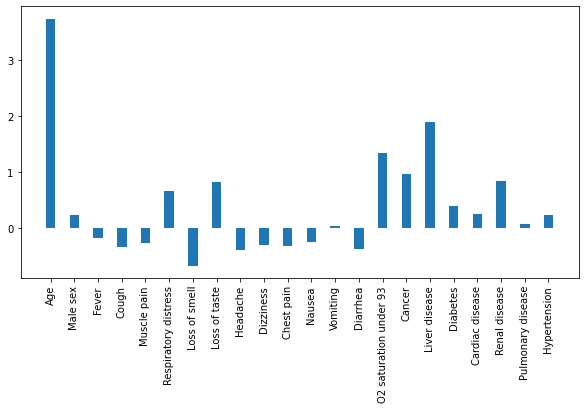

In [44]:
fig = plt.figure(figsize = (10, 5))
plt.bar(list(col),clf['classification'].coef_.flatten(),width=0.4)
plt.xticks(rotation=90)
plt.show()

In [45]:
clf=Pipeline([('transformation',column_transfromer_f),
              ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
clf.fit(x_train_f,y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  [0]),
                                                 ('pass', 'passthrough',
                                                  array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]))])),
                ('classification',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [46]:
# permutation logistic

score_random, perm_random, pvalue_random = permutation_test_score(
  clf ,x_train_f, y_train, scoring="balanced_accuracy", cv=skf, n_permutations=100,n_jobs=-1)

In [47]:
pvalue_random

0.009900990099009901

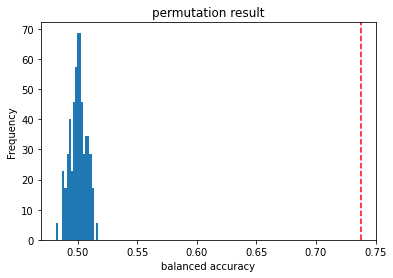

In [48]:
fig, ax = plt.subplots()
ax.hist(perm_random, bins=20, density=True)
ax.axvline(score_random, ls='--', color='r')
plt.xlabel('balanced accuracy')
plt.ylabel('Frequency')
plt.title('permutation result')
plt.show()

In [49]:
column_importance=list(col)
column_importance=np.array(column_importance)

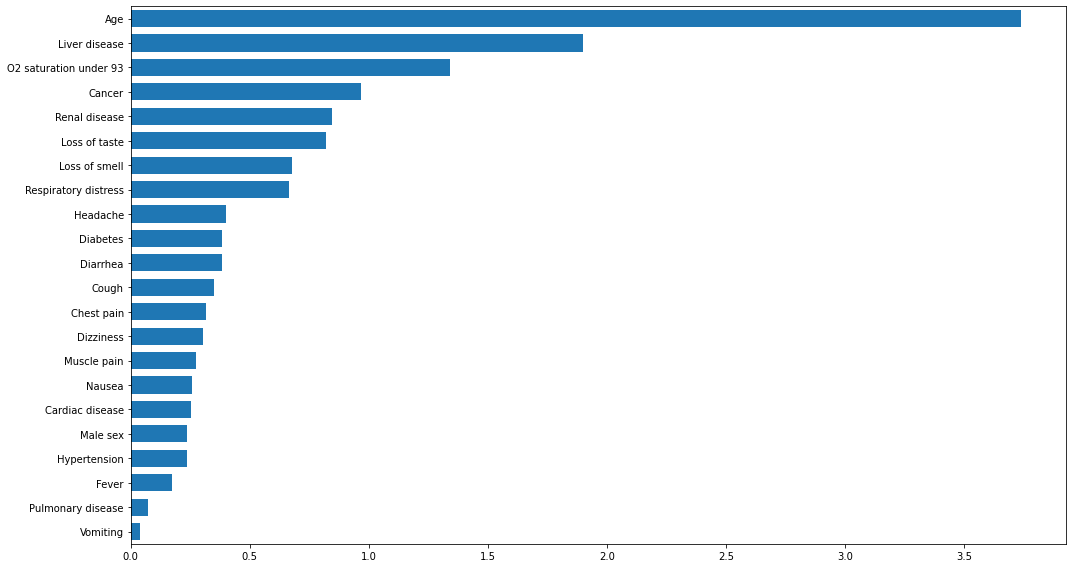

In [50]:


tree_importance_sorted_idx = np.argsort(np.abs(clf['classification'].coef_.flatten()))
tree_indices = np.arange(0, np.abs(clf['classification'].coef_.flatten()).shape[0]) + 0.5

#tree_labels= df_ext.columns.array[[0,1,4,5,6,10,19,22,27,31,32]]
#tree_labels=tree_labels[1:]

#tree_labels1=tree_labels[:-1]
#tree_labels2=np.append(tree_labels1,['epil0','epil1','epil2','epil3'])

fig,ax1 = plt.subplots(figsize=(15, 8))

ax1.barh(tree_indices,
         np.abs(clf['classification'].coef_.flatten())[tree_importance_sorted_idx], height=0.7)

ax1.set_yticks(tree_indices)
ax1.set_yticklabels(column_importance[tree_importance_sorted_idx])
ax1.set_ylim((0,np.abs(clf['classification'].coef_.flatten()).shape[0]))


fig.tight_layout()
plt.show()

In [51]:

mask_discrete=np.ones(x_train_f.shape[1],dtype=bool)
mask_discrete[0]=False

array_features=mutual_info_regression(x_train_f,x_train_f[:,0],
                                 discrete_features=mask_discrete,n_neighbors=5,random_state=42)

array_features=array_features.reshape(1,-1)



for i in range(1,x_train_f.shape[1]):
    
    
    mi_score=mutual_info_classif(x_train_f,x_train_f[:,i],
                        discrete_features=mask_discrete,n_neighbors=5,random_state=42)
    
    mi_score=mi_score.reshape(1,-1)
    
    array_features=np.append(array_features,mi_score,axis=0)
    
    
print(array_features.shape)

(22, 22)


In [52]:
df_odds=pd.DataFrame(np.zeros(shape=(21,21)),index=df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values,
                     columns=df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values)

for s,i in enumerate(df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values):
    for b,j in enumerate(df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values):
        cross_tab=pd.crosstab(df_ext[[i]].values.flatten(),df_ext[[j]].values.flatten())
        odds,p=stats.fisher_exact(cross_tab)
        df_odds.iloc[s,b]=odds
        
        
df_odds

,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,headache,dizziness,chest_pain,...,vomiting,diarrhea,Po2,cancer,chronic_liver_disease,diabetes,discardio,dis_chronic_renal,other_chronic_lung,htn
gender,inf,1.114483,0.928096,0.901172,1.060561,0.705587,0.685407,0.861654,0.879446,0.886771,...,0.756354,1.041738,1.053268,1.084001,1.269500,0.678175,0.967109,1.402278,0.825796,0.625437
fever,1.114483,inf,1.330614,1.758477,0.494074,1.507377,2.167039,1.526579,1.216770,0.683351,...,1.397358,1.746740,0.851878,0.913411,0.796390,0.979017,0.951430,0.995363,0.873828,0.946798
cough,0.928096,1.330614,inf,1.665622,0.876531,1.260974,1.537850,1.233540,0.927661,1.117241,...,0.691452,0.784051,1.077594,0.421094,0.705117,1.046360,0.911564,0.686578,0.996721,0.993399
muscle_pain,0.901172,1.758477,1.665622,inf,0.517417,2.061638,2.571068,2.346026,1.232747,1.059678,...,1.121027,1.411263,0.842851,0.383765,0.459821,0.986911,0.954338,0.725210,0.702355,0.954018
rspiratory_distress,1.060561,0.494074,0.876531,0.517417,inf,0.336549,0.485250,0.466876,0.545339,1.049316,...,0.490497,0.438248,3.717933,1.210076,0.898461,1.337397,1.415231,1.107248,1.853815,1.499000
smell,0.705587,1.507377,1.260974,2.061638,0.336549,inf,192.454106,2.957051,2.349346,1.281646,...,1.000216,1.640394,0.312191,0.436717,0.827160,0.431191,0.395658,0.353383,0.823677,0.433859
taste,0.685407,2.167039,1.537850,2.571068,0.485250,192.454106,inf,2.886053,2.934800,1.525579,...,1.406217,1.882449,0.492742,0.360401,0.680687,0.568654,0.484662,0.440000,0.501278,0.552105
headache,0.861654,1.526579,1.233540,2.346026,0.466876,2.957051,2.886053,inf,5.922577,1.324844,...,1.741227,1.735679,0.655930,0.454719,0.874234,0.832139,0.780361,0.664785,0.763834,0.844372
dizziness,0.879446,1.216770,0.927661,1.232747,0.545339,2.349346,2.934800,5.922577,inf,1.336859,...,2.902438,1.617918,0.772372,0.382261,1.113610,1.069392,1.113348,1.009030,0.488332,1.002960
chest_pain,0.886771,0.683351,1.117241,1.059678,1.049316,1.281646,1.525579,1.324844,1.336859,inf,...,1.318170,0.934679,0.979343,0.466779,0.810327,1.240592,2.024052,1.515435,1.231995,1.439544


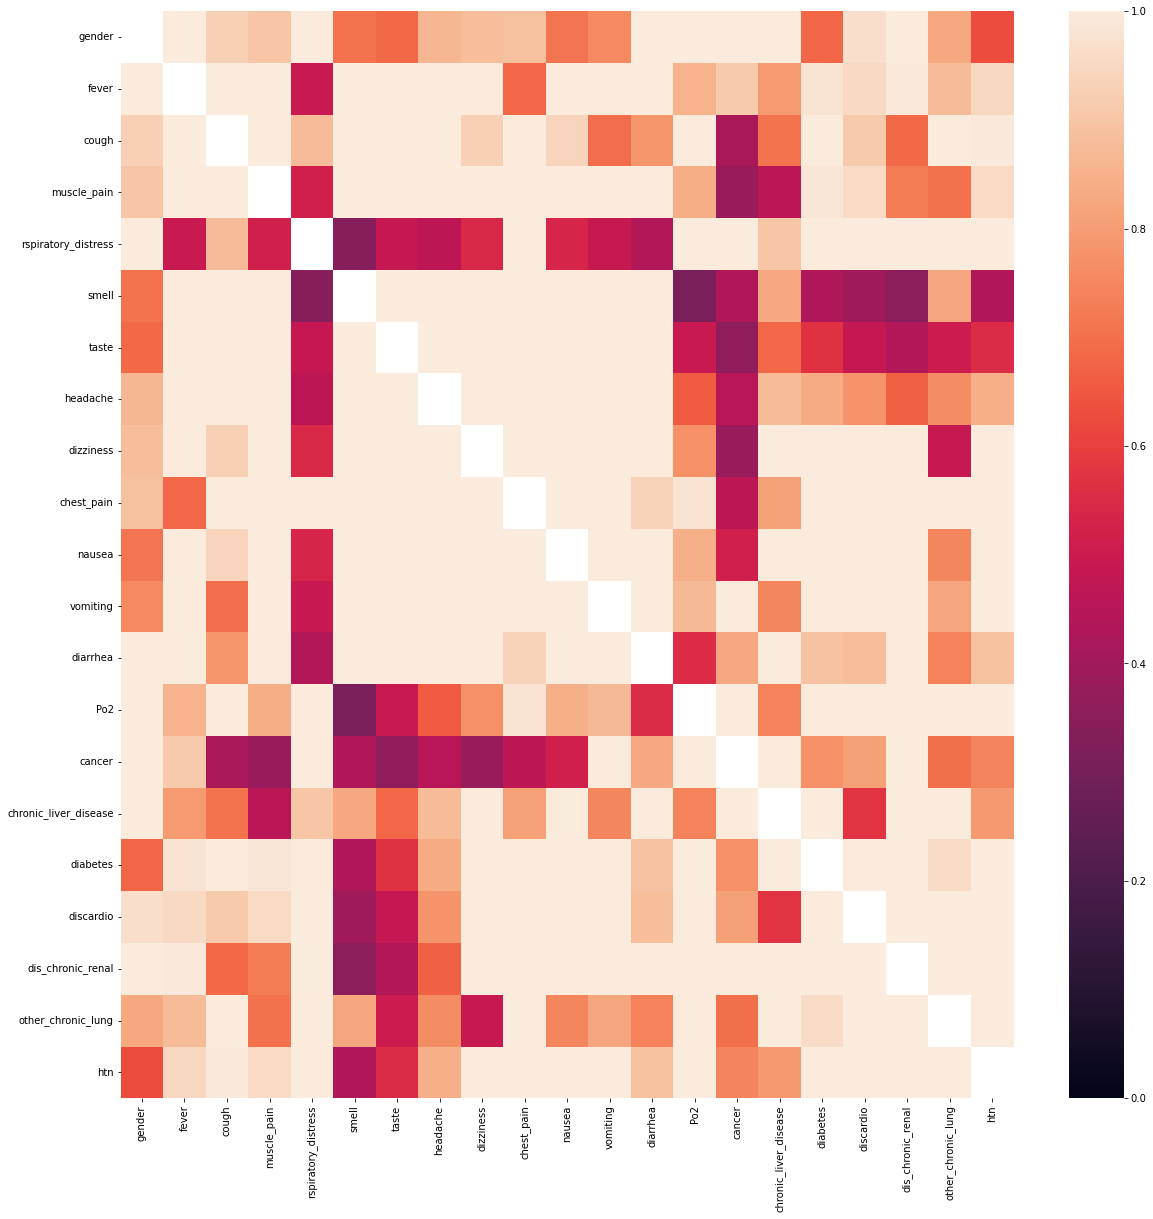

In [54]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_odds,ax=ax,vmin=0,vmax=1)
plt.show()

In [55]:
df_features=pd.DataFrame(array_features,
                         index=col,
                         columns=col)

In [56]:
df_features

,Age,Male sex,Fever,Cough,Muscle pain,Respiratory distress,Loss of smell,Loss of taste,Headache,Dizziness,...,Vomiting,Diarrhea,O2 saturation under 93,Cancer,Liver disease,Diabetes,Cardiac disease,Renal disease,Pulmonary disease,Hypertension
Age,4.249784,0.001314,2.987058e-03,7.485767e-03,0.000000e+00,0.013310,5.843596e-03,0.002581,0.003601,0.000000e+00,...,0.000287,1.043348e-03,0.058633,0.001880,3.337387e-04,3.532214e-02,0.046241,3.887687e-03,2.099357e-03,7.829741e-02
Male sex,0.000184,0.692540,4.413416e-04,9.888657e-05,3.288024e-04,0.000176,2.903504e-04,0.000174,0.000424,1.267845e-04,...,0.000452,8.092692e-06,0.000048,0.000028,7.920693e-05,2.810175e-03,0.000023,3.283440e-04,1.764991e-04,5.052671e-03
Fever,0.003119,0.000441,6.346085e-01,2.390788e-03,8.428855e-03,0.012785,3.557821e-04,0.000629,0.002283,1.525442e-04,...,0.000662,1.363423e-03,0.000737,0.000021,1.013985e-05,1.888479e-05,0.000008,7.869178e-07,2.883284e-05,6.156285e-05
Cough,0.004890,0.000099,2.390788e-03,6.891184e-01,7.061875e-03,0.000531,8.832812e-05,0.000199,0.000609,8.081933e-06,...,0.000944,3.025263e-04,0.000148,0.001525,1.328595e-04,2.362527e-05,0.000154,5.130173e-04,5.193536e-07,1.920367e-05
Muscle pain,0.005734,0.000329,8.428855e-03,7.061875e-03,6.531795e-01,0.012157,1.339804e-03,0.001448,0.009670,2.676051e-04,...,0.000071,4.601863e-04,0.000699,0.001423,2.586474e-04,1.455547e-07,0.000002,3.244253e-04,4.289740e-04,1.144017e-05
Respiratory distress,0.012653,0.000176,1.278515e-02,5.310090e-04,1.215741e-02,0.691247,2.255776e-03,0.000545,0.007865,1.561094e-03,...,0.002761,2.392145e-03,0.047114,0.000050,5.231119e-06,1.370482e-03,0.001313,3.471217e-06,1.575316e-03,3.347841e-03
Loss of smell,0.006464,0.000290,3.557821e-04,8.832812e-05,1.339804e-03,0.002256,9.136324e-02,0.025722,0.001982,4.482533e-04,...,0.000002,2.137003e-04,0.002922,0.000078,1.696670e-07,5.173518e-04,0.000627,1.360497e-04,3.368580e-06,7.555576e-04
Loss of taste,0.003106,0.000174,6.288988e-04,1.990149e-04,1.447556e-03,0.000545,2.572243e-02,0.059280,0.001228,4.328916e-04,...,0.000002,1.490311e-04,0.000544,0.000036,1.178019e-06,1.552382e-04,0.000178,3.069699e-05,1.288998e-04,2.479804e-04
Headache,0.004648,0.000424,2.283369e-03,6.088108e-04,9.670311e-03,0.007865,1.982009e-03,0.001228,0.381330,1.265419e-02,...,0.000801,6.037513e-04,0.002125,0.000544,2.732011e-05,1.917158e-04,0.000287,1.758573e-04,1.233473e-04,1.489450e-04
Dizziness,0.000000,0.000127,1.525442e-04,8.081933e-06,2.676051e-04,0.001561,4.482533e-04,0.000433,0.012654,1.675571e-01,...,0.001693,6.456557e-05,0.000284,0.000154,2.106545e-06,1.896688e-05,0.000004,8.629236e-06,2.789226e-04,1.802089e-07


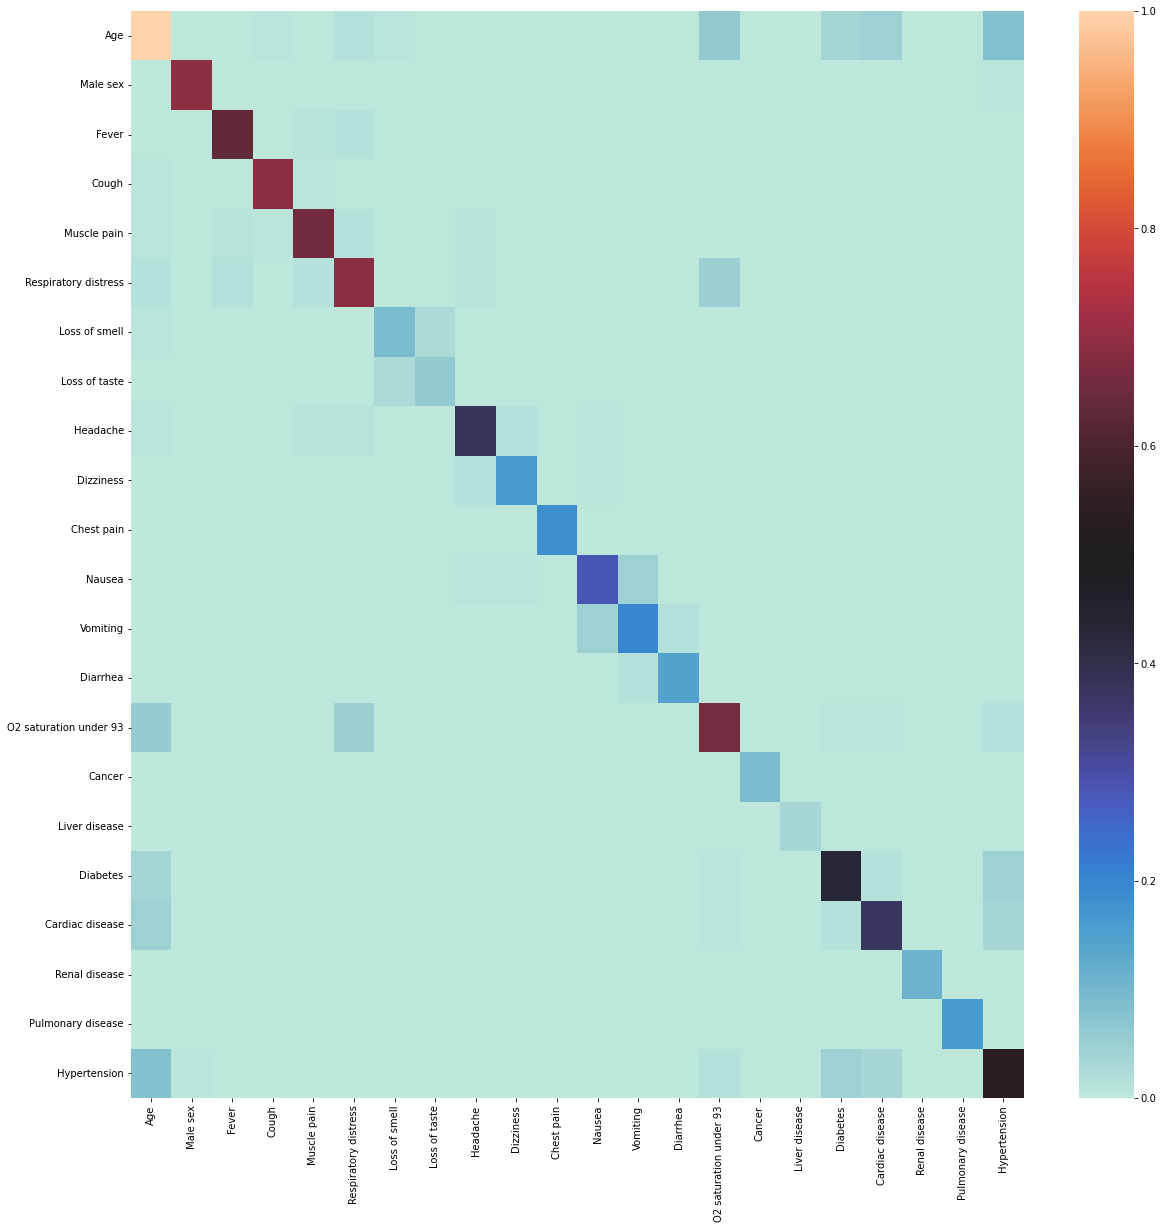

In [57]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_features,ax=ax,vmin=0.0,vmax=1.0,center=0.5)
plt.show()

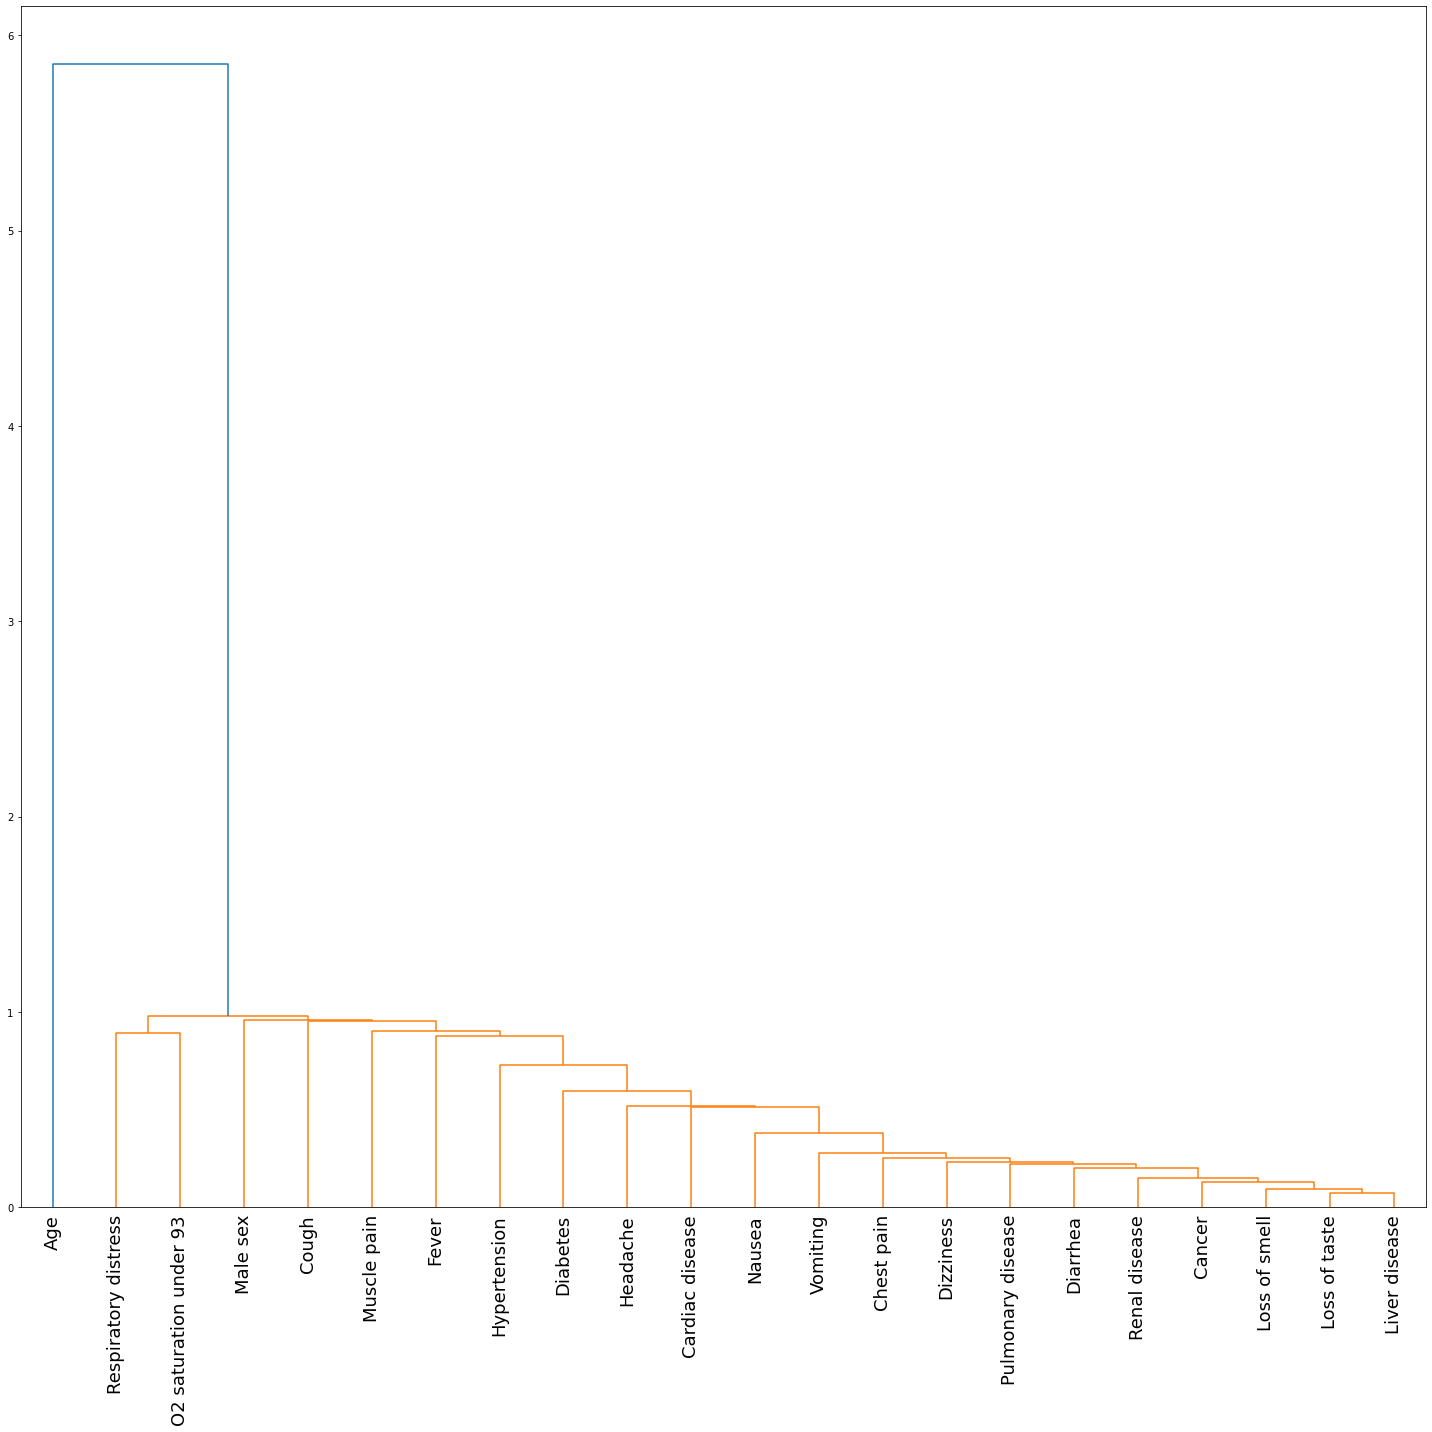

In [58]:

fig,ax1 = plt.subplots(figsize=(20, 20))


ax1.set_xticks(np.arange(0,array_features.shape[1]))

corr_linkage = hierarchy.ward(array_features)


dendro = hierarchy.dendrogram(
    corr_linkage, labels=df_features.columns.to_list(), ax=ax1, leaf_rotation=90)



ax1.set_xticklabels(dendro['ivl'],fontsize=18)

fig.tight_layout()

plt.show()

In [59]:
df_features.columns.array

<PandasArray>
[                   'Age',               'Male sex',                  'Fever',
                  'Cough',            'Muscle pain',   'Respiratory distress',
          'Loss of smell',          'Loss of taste',               'Headache',
              'Dizziness',             'Chest pain',                 'Nausea',
               'Vomiting',               'Diarrhea', 'O2 saturation under 93',
                 'Cancer',          'Liver disease',               'Diabetes',
        'Cardiac disease',          'Renal disease',      'Pulmonary disease',
           'Hypertension']
Length: 22, dtype: object

In [60]:
cluster_ids = hierarchy.fcluster(corr_linkage,0.95, criterion='distance')
cluster_ids

array([5, 4, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [61]:
feature_mi=mutual_info_classif(x_train_f,y_train, discrete_features=mask_discrete,random_state=42)

sorted_features=np.argsort(feature_mi)[::-1]

print(df_features.columns.array[sorted_features],'\n',feature_mi[sorted_features])

<PandasArray>
[                   'Age', 'O2 saturation under 93',   'Respiratory distress',
           'Hypertension',        'Cardiac disease',               'Diabetes',
            'Muscle pain',                  'Cough',               'Headache',
                  'Fever',          'Renal disease',                 'Cancer',
                 'Nausea',          'Loss of smell',              'Dizziness',
               'Male sex',          'Liver disease',               'Diarrhea',
               'Vomiting',      'Pulmonary disease',          'Loss of taste',
             'Chest pain']
Length: 22, dtype: object 
 [0.03580337 0.02167167 0.01159172 0.00779894 0.0052752  0.00401607
 0.00308949 0.0029198  0.00285786 0.00173517 0.00123591 0.00108461
 0.00079674 0.00063919 0.00055235 0.00055074 0.00051787 0.00050113
 0.00021596 0.00018742 0.00012623 0.00012074]


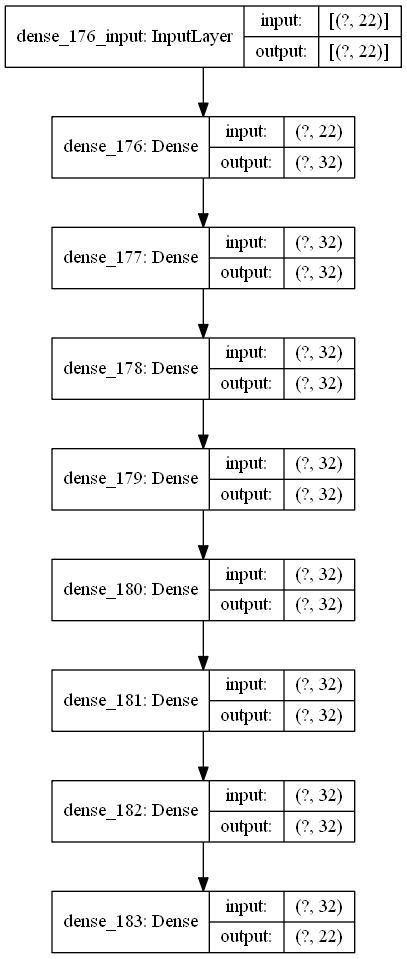

In [165]:
#Autoencoder for outlier detection with all features(35) and for dimensionality reduction (26)

def create_model():
    model=tf.keras.Sequential([layers.Dense(32,activation='relu',input_shape=(22,)),

                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(22,activation='sigmoid')])
    model.compile('adam',loss='mean_squared_logarithmic_error',metrics=['mse'])
    return model
model=create_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [166]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 32)                736       
_________________________________________________________________
dense_177 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_178 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_179 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_180 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_181 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_182 (Dense)            (None, 32)              

In [167]:
def x_generator(x,batch_size,shuffle=True):
    batch_index=0
    n=x.shape[0]
    while True:
        if batch_index==0:
            index_array=np.arange(n)
            if shuffle:
                index_array = np.random.permutation(n)
        current_index=(batch_index*batch_size)%n
        
        if n>=current_index+batch_size:
            current_batch_size=batch_size
            
        else:
            current_batch_size=n-current_index
            batch_index=0
            
        batch_x=x[index_array[current_index:current_index+current_batch_size]]
        
        yield batch_x
        
        

def mixed_generator(x,batch_size,swaprate=0.3,shuffle=True):
    num_value=x.shape[1]
    num_swap=int(num_value*swaprate)
    
    gen1=x_generator(x,batch_size,shuffle)
    gen2=x_generator(x,batch_size,shuffle)
    
    while True:
        batch1=next(gen1)
        batch2=next(gen2)
        new_batch=batch1.copy()
        
        for i in range(batch1.shape[0]):
            swap_idx=np.random.choice(num_value,num_swap,replace=False)
            
            new_batch[i,swap_idx]=batch2[i,swap_idx]
            
        yield(new_batch,batch1)

In [168]:
callback=EarlyStopping(monitor='val_loss',patience=17,restore_best_weights=True)

a=[]

for train_index, test_index in skf.split(x_train_f, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train_f[train_index], x_train_f[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    x_train_auto=column_transfromer_f.fit_transform(X_train_f)
    x_test_auto=column_transfromer_f.transform(X_test_f)
    
    gen_train=mixed_generator(x_train_auto,batch_size=128)
    
    model= create_model()
    
    history=model.fit(gen_train,epochs=500,steps_per_epoch=np.ceil(x_train_f.shape[0]/128),
                  validation_data=(x_test_auto,x_test_auto),callbacks=[callback])
    
    x_pred=model.predict(x_test_auto)
    errors=tf.keras.losses.msle(x_pred,x_test_auto)
    
    mean_loss=np.mean(errors.numpy())
    
    a.append(mean_loss)

print(a)

TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
Epoch 1/500
173/173 [==============================] - 1s 5ms/step - loss: 0.0703 - mse: 0.1358 - val_loss: 0.0391 - val_mse: 0.0832
Epoch 2/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0376 - mse: 0.0800 - val_loss: 0.0223 - val_mse: 0.0477
Epoch 3/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0325 - mse: 0.0688 - val_loss: 0.0196 - val_mse: 0.0428
Epoch 4/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0312 - mse: 0.0660 - val_loss: 0.0164 - val_mse: 0.0358
Epoch 5/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0302 - mse: 0.0636 - val_loss: 0.0148 - val_mse: 0.0325
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0289 - mse: 0.0610 - val_loss: 0.0139 - val_mse: 0.0322 - loss: 0.0290 - mse: 0.0
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.02

Epoch 60/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0054 - val_mse: 0.0123
Epoch 61/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0052 - val_mse: 0.0127
Epoch 62/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0056 - val_mse: 0.0127
Epoch 63/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0055 - val_mse: 0.0138
Epoch 64/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0060 - val_mse: 0.0160
Epoch 65/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0053 - val_mse: 0.0135
Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0060 - val_mse: 0.0144
Epoch 67/500
173/173 [==============================] - 1s 4ms

Epoch 14/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0275 - mse: 0.0579 - val_loss: 0.0108 - val_mse: 0.0246
Epoch 15/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0273 - mse: 0.0575 - val_loss: 0.0108 - val_mse: 0.0239
Epoch 16/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0271 - mse: 0.0571 - val_loss: 0.0099 - val_mse: 0.0223
Epoch 17/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0269 - mse: 0.0568 - val_loss: 0.0098 - val_mse: 0.0223
Epoch 18/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0268 - mse: 0.0565 - val_loss: 0.0090 - val_mse: 0.0199
Epoch 19/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0266 - mse: 0.0561 - val_loss: 0.0086 - val_mse: 0.0196
Epoch 20/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0266 - mse: 0.0561 - val_loss: 0.0092 - val_mse: 0.0218
Epoch 21/500
173/173 [==============================] - 1s 4ms

Epoch 75/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0053 - val_mse: 0.0135
Epoch 76/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0052 - val_mse: 0.0127
Epoch 77/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0509 - val_loss: 0.0054 - val_mse: 0.0137
Epoch 78/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0513 - val_loss: 0.0056 - val_mse: 0.0138
Epoch 79/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0507 - val_loss: 0.0049 - val_mse: 0.0110
Epoch 80/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0055 - val_mse: 0.0132
Epoch 81/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0509 - val_loss: 0.0047 - val_mse: 0.0112
Epoch 82/500
173/173 [==============================] - 1s 4ms

173/173 [==============================] - 1s 4ms/step - loss: 0.0270 - mse: 0.0568 - val_loss: 0.0097 - val_mse: 0.0220
Epoch 22/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0266 - mse: 0.0561 - val_loss: 0.0091 - val_mse: 0.0210
Epoch 23/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0267 - mse: 0.0562 - val_loss: 0.0087 - val_mse: 0.0201
Epoch 24/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0266 - mse: 0.0559 - val_loss: 0.0084 - val_mse: 0.0188- loss: 0.0266 - mse: 0.056
Epoch 25/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0264 - mse: 0.0556 - val_loss: 0.0083 - val_mse: 0.0192
Epoch 26/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0261 - mse: 0.0549 - val_loss: 0.0081 - val_mse: 0.0185
Epoch 27/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0261 - mse: 0.0550 - val_loss: 0.0081 - val_mse: 0.0191
Epoch 28/500
173/173 [==========================

173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0049 - val_mse: 0.0116
Epoch 82/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0053 - val_mse: 0.0132
Epoch 83/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0048 - val_mse: 0.0116
Epoch 84/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0508 - val_loss: 0.0050 - val_mse: 0.0122
Epoch 85/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0048 - val_mse: 0.0111
Epoch 86/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0513 - val_loss: 0.0047 - val_mse: 0.0115
Epoch 87/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0050 - val_mse: 0.0124
Epoch 88/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0537 - val_loss: 0.0067 - val_mse: 0.0155
Epoch 32/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0257 - mse: 0.0541 - val_loss: 0.0068 - val_mse: 0.0159
Epoch 33/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0538 - val_loss: 0.0065 - val_mse: 0.0144
Epoch 34/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0254 - mse: 0.0535 - val_loss: 0.0068 - val_mse: 0.0163
Epoch 35/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0538 - val_loss: 0.0066 - val_mse: 0.0153
Epoch 36/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0253 - mse: 0.0534 - val_loss: 0.0064 - val_mse: 0.0155
Epoch 37/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0252 - mse: 0.0531 - val_loss: 0.0063 - val_mse: 0.0144
Epoch 38/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0053 - val_mse: 0.0132
Epoch 92/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0053 - val_mse: 0.0133
Epoch 93/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0515 - val_loss: 0.0051 - val_mse: 0.0121
Epoch 94/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0050 - val_mse: 0.0119
Epoch 95/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0520 - val_loss: 0.0051 - val_mse: 0.0124
Epoch 96/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0053 - val_mse: 0.0136
Epoch 97/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0052 - val_mse: 0.0135
Epoch 98/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0537 - val_loss: 0.0071 - val_mse: 0.0169
Epoch 36/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0256 - mse: 0.0539 - val_loss: 0.0074 - val_mse: 0.0180
Epoch 37/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0257 - mse: 0.0542 - val_loss: 0.0070 - val_mse: 0.0161
Epoch 38/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0254 - mse: 0.0535 - val_loss: 0.0068 - val_mse: 0.0157
Epoch 39/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0538 - val_loss: 0.0070 - val_mse: 0.0150
Epoch 40/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0537 - val_loss: 0.0071 - val_mse: 0.0173
Epoch 41/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0537 - val_loss: 0.0067 - val_mse: 0.0161
Epoch 42/500
173/173 [==============================] - 1s 4ms/step - loss:

Epoch 96/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0515 - val_loss: 0.0054 - val_mse: 0.0131
Epoch 97/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0522 - val_loss: 0.0056 - val_mse: 0.0130
Epoch 98/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0522 - val_loss: 0.0052 - val_mse: 0.0115
Epoch 99/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0523 - val_loss: 0.0051 - val_mse: 0.0118
Epoch 100/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0522 - val_loss: 0.0055 - val_mse: 0.0133
Epoch 101/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0053 - val_mse: 0.0115
Epoch 102/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0515 - val_loss: 0.0055 - val_mse: 0.0124
Epoch 103/500
173/173 [==============================] - 1s

Epoch 156/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0047 - val_mse: 0.0109
Epoch 157/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0511 - val_loss: 0.0054 - val_mse: 0.0140
Epoch 158/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0050 - val_mse: 0.0113
Epoch 159/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0049 - val_mse: 0.0106
Epoch 160/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0513 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 161/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0050 - val_mse: 0.0117
Epoch 162/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0513 - val_loss: 0.0047 - val_mse: 0.0104
Epoch 163/500
173/173 [==============================] 

173/173 [==============================] - 1s 4ms/step - loss: 0.0254 - mse: 0.0535 - val_loss: 0.0062 - val_mse: 0.0143
Epoch 47/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0254 - mse: 0.0536 - val_loss: 0.0060 - val_mse: 0.0149
Epoch 48/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0252 - mse: 0.0531 - val_loss: 0.0062 - val_mse: 0.0144
Epoch 49/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0255 - mse: 0.0537 - val_loss: 0.0059 - val_mse: 0.0139
Epoch 50/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0251 - mse: 0.0529 - val_loss: 0.0058 - val_mse: 0.0143
Epoch 51/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0252 - mse: 0.0532 - val_loss: 0.0057 - val_mse: 0.0133
Epoch 52/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0250 - mse: 0.0527 - val_loss: 0.0056 - val_mse: 0.0135
Epoch 53/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0048 - val_mse: 0.0113
Epoch 107/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 108/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0048 - val_mse: 0.0111
Epoch 109/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0128
Epoch 110/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0054 - val_mse: 0.0123
Epoch 111/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0047 - val_mse: 0.0117
Epoch 112/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0052 - val_mse: 0.0118
Epoch 113/500
173/173 [==============================] - 1s 4ms/step 

173/173 [==============================] - 1s 4ms/step - loss: 0.0314 - mse: 0.0663 - val_loss: 0.0160 - val_mse: 0.0348
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0307 - mse: 0.0646 - val_loss: 0.0155 - val_mse: 0.0334
Epoch 8/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0302 - mse: 0.0637 - val_loss: 0.0144 - val_mse: 0.0318
Epoch 9/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0296 - mse: 0.0625 - val_loss: 0.0134 - val_mse: 0.0295
Epoch 10/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0293 - mse: 0.0617 - val_loss: 0.0131 - val_mse: 0.0291
Epoch 11/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0289 - mse: 0.0609 - val_loss: 0.0125 - val_mse: 0.0273
Epoch 12/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0285 - mse: 0.0601 - val_loss: 0.0117 - val_mse: 0.0253
Epoch 13/500
173/173 [==============================] - 1s 4ms/step - loss: 0.

173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0054 - val_mse: 0.0124
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0056 - val_mse: 0.0141
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0517 - val_loss: 0.0054 - val_mse: 0.0122
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0520 - val_loss: 0.0054 - val_mse: 0.0133
Epoch 71/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0053 - val_mse: 0.0125
Epoch 72/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0127
Epoch 73/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0054 - val_mse: 0.0126
Epoch 74/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0055 - val_mse: 0.0141
Epoch 129/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0509 - val_loss: 0.0052 - val_mse: 0.0130
Epoch 130/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0051 - val_mse: 0.0122
Epoch 131/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0520 - val_loss: 0.0049 - val_mse: 0.0110
Epoch 132/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 133/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0054 - val_mse: 0.0140
Epoch 134/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 135/500
173/173 [==============================] - 1s 4ms/step 

173/173 [==============================] - 1s 4ms/step - loss: 0.0388 - mse: 0.0822 - val_loss: 0.0255 - val_mse: 0.0551
Epoch 3/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0343 - mse: 0.0726 - val_loss: 0.0205 - val_mse: 0.0434
Epoch 4/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0319 - mse: 0.0675 - val_loss: 0.0170 - val_mse: 0.0359
Epoch 5/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0307 - mse: 0.0648 - val_loss: 0.0149 - val_mse: 0.0326
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0297 - mse: 0.0627 - val_loss: 0.0135 - val_mse: 0.0300
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0290 - mse: 0.0612 - val_loss: 0.0121 - val_mse: 0.0270
Epoch 8/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0282 - mse: 0.0594 - val_loss: 0.0116 - val_mse: 0.0245
Epoch 9/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0279

173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0053 - val_mse: 0.0132
Epoch 64/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0055 - val_mse: 0.0128
Epoch 65/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0511 - val_loss: 0.0052 - val_mse: 0.0126
Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0055 - val_mse: 0.0131
Epoch 67/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0050 - val_mse: 0.0125
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0048 - val_mse: 0.0113
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0127
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0511 - val_loss: 0.0044 - val_mse: 0.0106
Epoch 124/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0044 - val_mse: 0.0104
Epoch 125/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0507 - val_loss: 0.0059 - val_mse: 0.0150
Epoch 126/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0239 - mse: 0.0503 - val_loss: 0.0048 - val_mse: 0.0127
Epoch 127/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0046 - val_mse: 0.0117
Epoch 128/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0509 - val_loss: 0.0051 - val_mse: 0.0134
Epoch 129/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0509 - val_loss: 0.0046 - val_mse: 0.0115- loss: 0.0242 - mse: 0.0
Epoch 130/500
173/173 [=====================

173/173 [==============================] - 1s 4ms/step - loss: 0.0275 - mse: 0.0580 - val_loss: 0.0106 - val_mse: 0.0242
Epoch 17/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0272 - mse: 0.0573 - val_loss: 0.0101 - val_mse: 0.0226: 0s - loss: 0.0272 - mse: 0.
Epoch 18/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0269 - mse: 0.0567 - val_loss: 0.0095 - val_mse: 0.0208
Epoch 19/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0268 - mse: 0.0565 - val_loss: 0.0096 - val_mse: 0.0218
Epoch 20/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0267 - mse: 0.0562 - val_loss: 0.0097 - val_mse: 0.0226
Epoch 21/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0265 - mse: 0.0558 - val_loss: 0.0092 - val_mse: 0.0202
Epoch 22/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0268 - mse: 0.0565 - val_loss: 0.0091 - val_mse: 0.0214
Epoch 23/500
173/173 [========================

Epoch 77/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0059 - val_mse: 0.0143
Epoch 78/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0055 - val_mse: 0.0133
Epoch 79/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0054 - val_mse: 0.0122
Epoch 80/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0517 - val_loss: 0.0055 - val_mse: 0.0123
Epoch 81/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0513 - val_loss: 0.0053 - val_mse: 0.0125
Epoch 82/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0050 - val_mse: 0.0113
Epoch 83/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0124
Epoch 84/500
173/173 [==============================] - 1s 4ms

173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0050 - val_mse: 0.0129
Epoch 137/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0506 - val_loss: 0.0046 - val_mse: 0.0116
Epoch 138/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0051 - val_mse: 0.0127
Epoch 139/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0509 - val_loss: 0.0047 - val_mse: 0.0112
Epoch 140/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 141/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0508 - val_loss: 0.0047 - val_mse: 0.0112
Epoch 142/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0046 - val_mse: 0.0112
Epoch 143/500
173/173 [==============================] - 1s 4ms/step 

173/173 [==============================] - 1s 4ms/step - loss: 0.0366 - mse: 0.0772 - val_loss: 0.0219 - val_mse: 0.0476
Epoch 4/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0328 - mse: 0.0691 - val_loss: 0.0179 - val_mse: 0.0397
Epoch 5/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0318 - mse: 0.0670 - val_loss: 0.0164 - val_mse: 0.0344
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0305 - mse: 0.0643 - val_loss: 0.0154 - val_mse: 0.0340
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0306 - mse: 0.0644 - val_loss: 0.0151 - val_mse: 0.0318
Epoch 8/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0303 - mse: 0.0638 - val_loss: 0.0143 - val_mse: 0.0315
Epoch 9/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0296 - mse: 0.0623 - val_loss: 0.0131 - val_mse: 0.0288
Epoch 10/500
173/173 [==============================] - 1s 4ms/step - loss: 0.029

Epoch 64/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0056 - val_mse: 0.0136
Epoch 65/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0523 - val_loss: 0.0055 - val_mse: 0.0128
Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0054 - val_mse: 0.0130
Epoch 67/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0124
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0056 - val_mse: 0.0129
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0054 - val_mse: 0.0136
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0049 - val_mse: 0.0120
Epoch 71/500
173/173 [==============================] - 1s 4ms

Epoch 125/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0046 - val_mse: 0.0116
Epoch 126/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0045 - val_mse: 0.0114
Epoch 127/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0508 - val_loss: 0.0051 - val_mse: 0.0127
Epoch 128/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0511 - val_loss: 0.0045 - val_mse: 0.0106
[0.00463961819571771, 0.004593912159715902, 0.004389566275783193, 0.004841575153807181, 0.004563018853964174, 0.004478896203971419, 0.004570816640126292, 0.004169812255424115, 0.0045072038760155374, 0.004320856945330364]


In [169]:
loss_array=np.array(a)
mean_epochs_loss=np.mean(loss_array)
std_epochs=np.std(loss_array)
print(mean_epochs_loss,std_epochs)

0.0045075276559855895 0.0001752755232852178


In [170]:
model.save('auto_encoder.h5')

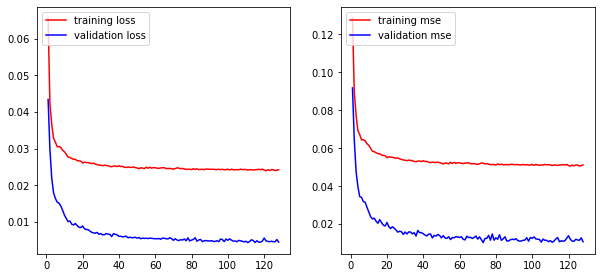

In [171]:
train_loss=history.history['loss']
epochs=np.arange(1,len(train_loss)+1)
val_loss=history.history['val_loss']

train_mse=history.history['mse']
val_mse=history.history['val_mse']

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(epochs,train_loss,'r',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.plot(epochs,train_mse,'r',label='training mse')
plt.plot(epochs,val_mse,'b',label='validation mse')
plt.legend(loc='upper left')
plt.show()

In [172]:
model=load_model('auto_encoder.h5')

In [173]:
x_train_x=column_transfromer_f.fit_transform(x_train_f)
x_test_x=column_transfromer_f.transform(x_test_f)

In [147]:
with open('column_preprocessing.sav','wb') as f:
    pickle.dump(column_transfromer_f,f)

#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [174]:
class denoising:
    
    def __init__(self,model):
        self.model=model
        
    def fit(self,X,y=None):
        return self


 
    def transform(self,X,y=None):
        predicts=self.model.predict(X)
        X=predicts
        return X

In [175]:
x_train_auto=denoising(model).transform(x_train_x)
x_test_auto=denoising(model).transform(x_test_x)

In [29]:
clf=RandomForestClassifier()

In [30]:
#feature analysis



n_estimators=np.arange(100,3000)
criterion=['gini','entropy']
max_depth=np.arange(100,2000)
min_samples_split=np.linspace(0.001,1,100)
min_samples_leaf=np.linspace(0.001,0.5,100)
max_features=['auto','sqrt','log2']
bootstrap=[True,False]
class_weight=['balanced','balanced_subsample',None]
 
forest_param=[{
            'n_estimators':n_estimators,
              'criterion':criterion,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
              'max_features':max_features,
              'bootstrap':bootstrap,
              'class_weight':class_weight}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=9,random_state=42,verbose=2)

In [31]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=140, n_jobs=9,
                   param_distributions=[{'bootstrap': [True, False],
                                         'class_weight': ['balanced',
                                                          'balanced_subsample',
                                                          None],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': array([ 100,  101,  102, ..., 1997, 1998, 1999]),
                                         'max_features': ['auto', 'sqrt',
                                                          '...
       0.75781818, 0.76790909, 0.778     , 0.78809091, 0.79818182,
       0.80827273, 0.81836364, 0.82845455, 0.83854545, 0.84863636,
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
                                         'n_estimators': array([ 100,  101,  102, ..., 2997, 2998, 2999])}],
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [32]:
randomized.best_params_

{'n_estimators': 2829,
 'min_samples_split': 0.05145454545454546,
 'min_samples_leaf': 0.036282828282828285,
 'max_features': 'sqrt',
 'max_depth': 1832,
 'criterion': 'gini',
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [33]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [34]:
df_randomised_result.to_csv('param.csv')

In [35]:
print(df_randomised_result,'\n\n',randomized.best_params_)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        13.711193      2.751850         0.264877        0.044142   
1        25.306134      3.967452         0.403061        0.078418   
2        12.255235      2.610285         0.149849        0.027400   
3         5.840969      0.996287         0.306927        0.054756   
4        23.695572      4.660086         0.316747        0.056627   
..             ...           ...              ...             ...   
135       1.081968      0.242303         0.061061        0.011980   
136       6.731868      1.166944         0.115762        0.020816   
137      20.362873      4.196993         0.451807        0.092100   
138       3.702797      0.741565         0.209114        0.039762   
139       6.923698      0.998161         0.091307        0.002522   

    param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                 1859                0.656909               0.202616   
1                 2122   

In [176]:
clf=RandomForestClassifier(n_estimators=2829,min_samples_split=0.051,
                                                                min_samples_leaf=0.036,
                                                               max_features='sqrt',
                                                               max_depth=1832,
                                                               criterion='gini',
                                                               class_weight='balanced_subsample',
                                                               bootstrap=True)


In [177]:
clf.fit(x_train_auto,y_train)
pred=clf.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3376 1596]
 [ 110  423]] 0.736311713324448 0.20950965824665677 0.7936210131332082


In [38]:
clf=LogisticRegression(penalty='elasticnet',C=1,solver='lbfgs',class_weight='balanced',l1_ratio=0.6,max_iter=500)

In [39]:
penalty=['elasticnet']
C=np.linspace(0.1,10,100)
solver=['saga']
l1_ratio=np.linspace(0.1,1,100)
max_iter=[700,800,900]

forest_param=[{
            'penalty':penalty,
            'C':C,
              'solver':solver,
               'l1_ratio':l1_ratio,
                'max_iter':max_iter}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=-1,random_state=42,verbose=4)

In [40]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=LogisticRegression(C=1, class_weight='balanced',
                                                l1_ratio=0.6, max_iter=500,
                                                penalty='elasticnet'),
                   n_iter=140, n_jobs=-1,
                   param_distributions=[{'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2...
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
                                         'max_iter': [700, 800, 900],
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [41]:
randomized.best_params_

{'solver': 'saga',
 'penalty': 'elasticnet',
 'max_iter': 900,
 'l1_ratio': 0.8636363636363635,
 'C': 7.9}

In [178]:
clf=LogisticRegression(penalty='elasticnet',C=7.9,solver='saga',class_weight='balanced',l1_ratio=0.864,max_iter=900)
clf.fit(x_train_auto,y_train)

pred=clf.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3347 1625]
 [ 117  416]] 0.7268287777407139 0.20382165605095542 0.7804878048780488


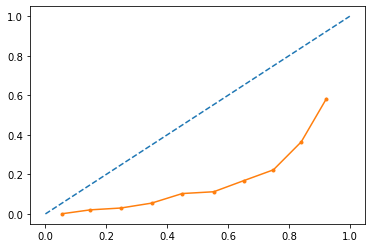

In [179]:
probs=clf.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=False)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [31]:
svc=svm.SVC(C=5,kernel='rbf',degree=3,gamma=0.1,coef0=2,shrinking=True,class_weight='balanced')

In [32]:
C=np.linspace(0.01,10,20)
kernel=['rbf','linear']
gamma=np.linspace(0,0.5,20)
coef0=np.linspace(0,7,20)

forest_param=[{
            'C':C,
              'kernel':kernel,
               'gamma':gamma,
                 'coef0':coef0}]

randomized=RandomizedSearchCV(estimator=svc,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=10,random_state=42,verbose=4)

In [33]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=SVC(C=5, class_weight='balanced', coef0=2,
                                 gamma=0.1),
                   n_iter=140, n_jobs=10,
                   param_distributions=[{'C': array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.37105...
       5.52631579, 5.89473684, 6.26315789, 6.63157895, 7.        ]),
                                         'gamma': array([0.        , 0.02631579, 0.05263158, 0.07894737, 0.10526316,
       0.13157895, 0.15789474, 0.18421053, 0.21052632, 0.23684211,
       0.26315789, 0.28947368, 0.31578947, 0.34210526, 0.36842105,
       0.39473684, 0.42105263, 0.44736842, 0.47368421, 0.5       ]),
                                         'kernel': ['rbf', 'linear']}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [34]:
randomized.best_params_

{'kernel': 'linear',
 'gamma': 0.3421052631578947,
 'coef0': 4.052631578947368,
 'C': 0.5357894736842106}

In [35]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [36]:
df_randomised_result.to_csv('param_svm.csv')

In [37]:
print(df_randomised_result,'\n\n',randomized.best_params_)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        35.265728      3.015460         2.626481        0.366850   
1        34.769231      4.680662         1.355005        0.344271   
2        38.425925      3.277250         2.927864        0.365078   
3        34.981318      2.693171         2.494891        0.531433   
4        34.513273      5.274192         2.515769        0.639189   
..             ...           ...              ...             ...   
135      36.063940      3.170908         2.816920        0.513204   
136      37.984684      4.477219         2.798985        0.639871   
137      28.844407      4.629078         1.286917        0.468517   
138      33.757737      4.572744         4.005704        0.817000   
139      28.473844      4.739865         0.925877        0.358952   

    param_kernel param_gamma param_coef0   param_C  \
0            rbf    0.394737    0.368421  4.742105   
1         linear    0.447368    5.157895      10.0   
2        

In [180]:
svc=svm.SVC(C=0.536,kernel='linear',degree=3,gamma=0.34,coef0=4.05,shrinking=True,class_weight='balanced')

In [181]:


svc.fit(x_train_auto,y_train)

pred=svc.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3218 1754]
 [ 102  431]] 0.7279274254776089 0.19725400457665904 0.8086303939962477


In [121]:


auc_lgbm=[]
recall_lgbm=[]
precision_lgbm=[]
balanced_accu_lgbm=[]

for train_index, test_index in skf.split(x_train_auto, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train_auto[train_index], x_train_auto[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    clf_lgbm=lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=11000,max_depth=1000,learning_rate=0.001,
                       
                       n_estimators=7000,subsample_for_bin=5000,min_split_gain=0.01,min_child_samples=700,
                       colsample_bytree=0.9,
                       reg_alpha=0.01,reg_lambda=0.01,
                       
                       objective='binary',subsample=0.9,
                       
                       subsample_freq=100,class_weight='balanced',
                       random_state=42)
    
    

    clf_lgbm.fit(X_train_f,Y_train,eval_set=(X_test_f,Y_test),eval_names=['validation'],
        eval_metric=['logloss'],early_stopping_rounds=20,categorical_feature='auto')
    
    preds_proba=clf_lgbm.predict_proba(X_test_f)
    
    auc_scoree=roc_auc_score(Y_test,preds_proba[:,1])
    auc_lgbm.append(auc_scoree)
    
    recall_scoree=recall_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    recall_lgbm.append(recall_scoree)
    
    precision_scoree=precision_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    precision_lgbm.append(precision_scoree)
    
    score=balanced_accuracy_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    balanced_accu_lgbm.append(score)
    
balanced_accu_array=np.array(balanced_accu_lgbm)
auc_array=np.array(auc_lgbm)
precision_array=np.array(precision_lgbm)
recall_array=np.array(recall_lgbm)

print(f'balanced_accuracy:{np.mean(balanced_accu_array)}\nAUC:{np.mean(auc_array)}\nPrecision:{np.mean(precision_array)}\nRecall:{np.mean(recall_array)}')






TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
[1]	validation's binary_logloss: 0.692859
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692571
[3]	validation's binary_logloss: 0.69231
[4]	validation's binary_logloss: 0.692022
[5]	validation's binary_logloss: 0.691736
[6]	validation's binary_logloss: 0.691449
[7]	validation's binary_logloss: 0.691165
[8]	validation's binary_logloss: 0.690881
[9]	validation's binary_logloss: 0.690597
[10]	validation's binary_logloss: 0.690317
[11]	validation's binary_logloss: 0.690034
[12]	validation's binary_logloss: 0.689756
[13]	validation's binary_logloss: 0.689476
[14]	validation's binary_logloss: 0.689193
[15]	validation's binary_logloss: 0.688914
[16]	validation's binary_logloss: 0.688634
[17]	validation's binary_logloss: 0.688357
[18]	validation's binary_logloss: 0.688077
[19]	validation's binary_logloss: 0.687799
[20]	validation's binary_logloss: 0

[226]	validation's binary_logloss: 0.639665
[227]	validation's binary_logloss: 0.639471
[228]	validation's binary_logloss: 0.639276
[229]	validation's binary_logloss: 0.63908
[230]	validation's binary_logloss: 0.638884
[231]	validation's binary_logloss: 0.63869
[232]	validation's binary_logloss: 0.638494
[233]	validation's binary_logloss: 0.638302
[234]	validation's binary_logloss: 0.638106
[235]	validation's binary_logloss: 0.637914
[236]	validation's binary_logloss: 0.63772
[237]	validation's binary_logloss: 0.637529
[238]	validation's binary_logloss: 0.637347
[239]	validation's binary_logloss: 0.637165
[240]	validation's binary_logloss: 0.636972
[241]	validation's binary_logloss: 0.636787
[242]	validation's binary_logloss: 0.636597
[243]	validation's binary_logloss: 0.636407
[244]	validation's binary_logloss: 0.636226
[245]	validation's binary_logloss: 0.636038
[246]	validation's binary_logloss: 0.635861
[247]	validation's binary_logloss: 0.635677
[248]	validation's binary_logloss: 

[466]	validation's binary_logloss: 0.602235
[467]	validation's binary_logloss: 0.60211
[468]	validation's binary_logloss: 0.601986
[469]	validation's binary_logloss: 0.601862
[470]	validation's binary_logloss: 0.601739
[471]	validation's binary_logloss: 0.601613
[472]	validation's binary_logloss: 0.601493
[473]	validation's binary_logloss: 0.601368
[474]	validation's binary_logloss: 0.601251
[475]	validation's binary_logloss: 0.601126
[476]	validation's binary_logloss: 0.601003
[477]	validation's binary_logloss: 0.600881
[478]	validation's binary_logloss: 0.600757
[479]	validation's binary_logloss: 0.600637
[480]	validation's binary_logloss: 0.600516
[481]	validation's binary_logloss: 0.600397
[482]	validation's binary_logloss: 0.600277
[483]	validation's binary_logloss: 0.600163
[484]	validation's binary_logloss: 0.600044
[485]	validation's binary_logloss: 0.599923
[486]	validation's binary_logloss: 0.599806
[487]	validation's binary_logloss: 0.599682
[488]	validation's binary_logloss

[682]	validation's binary_logloss: 0.580227
[683]	validation's binary_logloss: 0.580143
[684]	validation's binary_logloss: 0.580057
[685]	validation's binary_logloss: 0.579971
[686]	validation's binary_logloss: 0.579895
[687]	validation's binary_logloss: 0.579811
[688]	validation's binary_logloss: 0.579727
[689]	validation's binary_logloss: 0.579646
[690]	validation's binary_logloss: 0.579561
[691]	validation's binary_logloss: 0.579479
[692]	validation's binary_logloss: 0.579396
[693]	validation's binary_logloss: 0.579312
[694]	validation's binary_logloss: 0.579227
[695]	validation's binary_logloss: 0.579146
[696]	validation's binary_logloss: 0.579064
[697]	validation's binary_logloss: 0.578983
[698]	validation's binary_logloss: 0.578901
[699]	validation's binary_logloss: 0.578821
[700]	validation's binary_logloss: 0.57874
[701]	validation's binary_logloss: 0.578652
[702]	validation's binary_logloss: 0.578566
[703]	validation's binary_logloss: 0.578478
[704]	validation's binary_logloss

[895]	validation's binary_logloss: 0.56392
[896]	validation's binary_logloss: 0.563853
[897]	validation's binary_logloss: 0.563781
[898]	validation's binary_logloss: 0.563714
[899]	validation's binary_logloss: 0.563645
[900]	validation's binary_logloss: 0.563577
[901]	validation's binary_logloss: 0.56351
[902]	validation's binary_logloss: 0.563442
[903]	validation's binary_logloss: 0.563377
[904]	validation's binary_logloss: 0.56331
[905]	validation's binary_logloss: 0.563243
[906]	validation's binary_logloss: 0.563175
[907]	validation's binary_logloss: 0.563108
[908]	validation's binary_logloss: 0.563044
[909]	validation's binary_logloss: 0.562978
[910]	validation's binary_logloss: 0.562912
[911]	validation's binary_logloss: 0.562845
[912]	validation's binary_logloss: 0.562781
[913]	validation's binary_logloss: 0.562714
[914]	validation's binary_logloss: 0.562648
[915]	validation's binary_logloss: 0.562581
[916]	validation's binary_logloss: 0.562511
[917]	validation's binary_logloss: 

[1119]	validation's binary_logloss: 0.550839
[1120]	validation's binary_logloss: 0.550793
[1121]	validation's binary_logloss: 0.550747
[1122]	validation's binary_logloss: 0.550696
[1123]	validation's binary_logloss: 0.550646
[1124]	validation's binary_logloss: 0.550601
[1125]	validation's binary_logloss: 0.550555
[1126]	validation's binary_logloss: 0.550504
[1127]	validation's binary_logloss: 0.550455
[1128]	validation's binary_logloss: 0.550406
[1129]	validation's binary_logloss: 0.550356
[1130]	validation's binary_logloss: 0.550309
[1131]	validation's binary_logloss: 0.550262
[1132]	validation's binary_logloss: 0.550213
[1133]	validation's binary_logloss: 0.550164
[1134]	validation's binary_logloss: 0.550115
[1135]	validation's binary_logloss: 0.55007
[1136]	validation's binary_logloss: 0.55002
[1137]	validation's binary_logloss: 0.549971
[1138]	validation's binary_logloss: 0.549925
[1139]	validation's binary_logloss: 0.549881
[1140]	validation's binary_logloss: 0.549835
[1141]	valid

[1342]	validation's binary_logloss: 0.541832
[1343]	validation's binary_logloss: 0.541798
[1344]	validation's binary_logloss: 0.541766
[1345]	validation's binary_logloss: 0.541733
[1346]	validation's binary_logloss: 0.541698
[1347]	validation's binary_logloss: 0.541663
[1348]	validation's binary_logloss: 0.541628
[1349]	validation's binary_logloss: 0.541593
[1350]	validation's binary_logloss: 0.541559
[1351]	validation's binary_logloss: 0.541523
[1352]	validation's binary_logloss: 0.541489
[1353]	validation's binary_logloss: 0.541455
[1354]	validation's binary_logloss: 0.54142
[1355]	validation's binary_logloss: 0.541386
[1356]	validation's binary_logloss: 0.541355
[1357]	validation's binary_logloss: 0.54132
[1358]	validation's binary_logloss: 0.541288
[1359]	validation's binary_logloss: 0.541255
[1360]	validation's binary_logloss: 0.541222
[1361]	validation's binary_logloss: 0.541188
[1362]	validation's binary_logloss: 0.541153
[1363]	validation's binary_logloss: 0.541119
[1364]	valid

[1587]	validation's binary_logloss: 0.5351
[1588]	validation's binary_logloss: 0.535081
[1589]	validation's binary_logloss: 0.535061
[1590]	validation's binary_logloss: 0.535043
[1591]	validation's binary_logloss: 0.535019
[1592]	validation's binary_logloss: 0.535
[1593]	validation's binary_logloss: 0.534983
[1594]	validation's binary_logloss: 0.534962
[1595]	validation's binary_logloss: 0.534943
[1596]	validation's binary_logloss: 0.534924
[1597]	validation's binary_logloss: 0.534904
[1598]	validation's binary_logloss: 0.534885
[1599]	validation's binary_logloss: 0.534862
[1600]	validation's binary_logloss: 0.534842
[1601]	validation's binary_logloss: 0.534819
[1602]	validation's binary_logloss: 0.534798
[1603]	validation's binary_logloss: 0.534772
[1604]	validation's binary_logloss: 0.534749
[1605]	validation's binary_logloss: 0.534726
[1606]	validation's binary_logloss: 0.534702
[1607]	validation's binary_logloss: 0.534679
[1608]	validation's binary_logloss: 0.534654
[1609]	validati

[1825]	validation's binary_logloss: 0.529893
[1826]	validation's binary_logloss: 0.529871
[1827]	validation's binary_logloss: 0.529852
[1828]	validation's binary_logloss: 0.529829
[1829]	validation's binary_logloss: 0.52981
[1830]	validation's binary_logloss: 0.529787
[1831]	validation's binary_logloss: 0.529763
[1832]	validation's binary_logloss: 0.529745
[1833]	validation's binary_logloss: 0.529722
[1834]	validation's binary_logloss: 0.529702
[1835]	validation's binary_logloss: 0.529683
[1836]	validation's binary_logloss: 0.529664
[1837]	validation's binary_logloss: 0.529644
[1838]	validation's binary_logloss: 0.529623
[1839]	validation's binary_logloss: 0.529604
[1840]	validation's binary_logloss: 0.529583
[1841]	validation's binary_logloss: 0.529566
[1842]	validation's binary_logloss: 0.529546
[1843]	validation's binary_logloss: 0.529532
[1844]	validation's binary_logloss: 0.529512
[1845]	validation's binary_logloss: 0.529492
[1846]	validation's binary_logloss: 0.529473
[1847]	vali

[2077]	validation's binary_logloss: 0.52539
[2078]	validation's binary_logloss: 0.525375
[2079]	validation's binary_logloss: 0.525361
[2080]	validation's binary_logloss: 0.525348
[2081]	validation's binary_logloss: 0.525334
[2082]	validation's binary_logloss: 0.52532
[2083]	validation's binary_logloss: 0.525306
[2084]	validation's binary_logloss: 0.525292
[2085]	validation's binary_logloss: 0.52528
[2086]	validation's binary_logloss: 0.525268
[2087]	validation's binary_logloss: 0.525254
[2088]	validation's binary_logloss: 0.525239
[2089]	validation's binary_logloss: 0.525225
[2090]	validation's binary_logloss: 0.525211
[2091]	validation's binary_logloss: 0.525198
[2092]	validation's binary_logloss: 0.525186
[2093]	validation's binary_logloss: 0.525173
[2094]	validation's binary_logloss: 0.52516
[2095]	validation's binary_logloss: 0.525147
[2096]	validation's binary_logloss: 0.525131
[2097]	validation's binary_logloss: 0.525119
[2098]	validation's binary_logloss: 0.525107
[2099]	validat

[2326]	validation's binary_logloss: 0.522334
[2327]	validation's binary_logloss: 0.522318
[2328]	validation's binary_logloss: 0.522303
[2329]	validation's binary_logloss: 0.522285
[2330]	validation's binary_logloss: 0.522269
[2331]	validation's binary_logloss: 0.522253
[2332]	validation's binary_logloss: 0.522237
[2333]	validation's binary_logloss: 0.52222
[2334]	validation's binary_logloss: 0.522204
[2335]	validation's binary_logloss: 0.522187
[2336]	validation's binary_logloss: 0.52217
[2337]	validation's binary_logloss: 0.522155
[2338]	validation's binary_logloss: 0.522139
[2339]	validation's binary_logloss: 0.522121
[2340]	validation's binary_logloss: 0.522105
[2341]	validation's binary_logloss: 0.522086
[2342]	validation's binary_logloss: 0.52207
[2343]	validation's binary_logloss: 0.522053
[2344]	validation's binary_logloss: 0.522038
[2345]	validation's binary_logloss: 0.522021
[2346]	validation's binary_logloss: 0.522006
[2347]	validation's binary_logloss: 0.52199
[2348]	validat

[2571]	validation's binary_logloss: 0.520151
[2572]	validation's binary_logloss: 0.520149
[2573]	validation's binary_logloss: 0.520147
[2574]	validation's binary_logloss: 0.520142
[2575]	validation's binary_logloss: 0.52014
[2576]	validation's binary_logloss: 0.520139
[2577]	validation's binary_logloss: 0.520137
[2578]	validation's binary_logloss: 0.520136
[2579]	validation's binary_logloss: 0.520132
[2580]	validation's binary_logloss: 0.52013
[2581]	validation's binary_logloss: 0.520129
[2582]	validation's binary_logloss: 0.520126
[2583]	validation's binary_logloss: 0.520125
[2584]	validation's binary_logloss: 0.52012
[2585]	validation's binary_logloss: 0.520117
[2586]	validation's binary_logloss: 0.520116
[2587]	validation's binary_logloss: 0.520113
[2588]	validation's binary_logloss: 0.52011
[2589]	validation's binary_logloss: 0.520109
[2590]	validation's binary_logloss: 0.520109
[2591]	validation's binary_logloss: 0.520108
[2592]	validation's binary_logloss: 0.520108
[2593]	validat

[2820]	validation's binary_logloss: 0.518753
[2821]	validation's binary_logloss: 0.518747
[2822]	validation's binary_logloss: 0.51874
[2823]	validation's binary_logloss: 0.518733
[2824]	validation's binary_logloss: 0.518727
[2825]	validation's binary_logloss: 0.518718
[2826]	validation's binary_logloss: 0.518713
[2827]	validation's binary_logloss: 0.518707
[2828]	validation's binary_logloss: 0.5187
[2829]	validation's binary_logloss: 0.51869
[2830]	validation's binary_logloss: 0.518684
[2831]	validation's binary_logloss: 0.518678
[2832]	validation's binary_logloss: 0.51867
[2833]	validation's binary_logloss: 0.518664
[2834]	validation's binary_logloss: 0.518657
[2835]	validation's binary_logloss: 0.518652
[2836]	validation's binary_logloss: 0.518648
[2837]	validation's binary_logloss: 0.518641
[2838]	validation's binary_logloss: 0.518636
[2839]	validation's binary_logloss: 0.518629
[2840]	validation's binary_logloss: 0.518623
[2841]	validation's binary_logloss: 0.518614
[2842]	validati

[3069]	validation's binary_logloss: 0.517416
[3070]	validation's binary_logloss: 0.517414
[3071]	validation's binary_logloss: 0.517408
[3072]	validation's binary_logloss: 0.517408
[3073]	validation's binary_logloss: 0.517403
[3074]	validation's binary_logloss: 0.517402
[3075]	validation's binary_logloss: 0.5174
[3076]	validation's binary_logloss: 0.517399
[3077]	validation's binary_logloss: 0.517393
[3078]	validation's binary_logloss: 0.517384
[3079]	validation's binary_logloss: 0.51738
[3080]	validation's binary_logloss: 0.517374
[3081]	validation's binary_logloss: 0.517367
[3082]	validation's binary_logloss: 0.517365
[3083]	validation's binary_logloss: 0.517364
[3084]	validation's binary_logloss: 0.517356
[3085]	validation's binary_logloss: 0.517352
[3086]	validation's binary_logloss: 0.517351
[3087]	validation's binary_logloss: 0.517345
[3088]	validation's binary_logloss: 0.517342
[3089]	validation's binary_logloss: 0.517338
[3090]	validation's binary_logloss: 0.517336
[3091]	valida

[3313]	validation's binary_logloss: 0.516783
[3314]	validation's binary_logloss: 0.516775
[3315]	validation's binary_logloss: 0.516767
[3316]	validation's binary_logloss: 0.51676
[3317]	validation's binary_logloss: 0.516753
[3318]	validation's binary_logloss: 0.516747
[3319]	validation's binary_logloss: 0.51674
[3320]	validation's binary_logloss: 0.516733
[3321]	validation's binary_logloss: 0.516726
[3322]	validation's binary_logloss: 0.516722
[3323]	validation's binary_logloss: 0.516715
[3324]	validation's binary_logloss: 0.516707
[3325]	validation's binary_logloss: 0.5167
[3326]	validation's binary_logloss: 0.516696
[3327]	validation's binary_logloss: 0.516688
[3328]	validation's binary_logloss: 0.516681
[3329]	validation's binary_logloss: 0.516674
[3330]	validation's binary_logloss: 0.516666
[3331]	validation's binary_logloss: 0.516659
[3332]	validation's binary_logloss: 0.516653
[3333]	validation's binary_logloss: 0.516646
[3334]	validation's binary_logloss: 0.516639
[3335]	validat

[3553]	validation's binary_logloss: 0.515273
[3554]	validation's binary_logloss: 0.515269
[3555]	validation's binary_logloss: 0.515265
[3556]	validation's binary_logloss: 0.51526
[3557]	validation's binary_logloss: 0.515257
[3558]	validation's binary_logloss: 0.515251
[3559]	validation's binary_logloss: 0.515249
[3560]	validation's binary_logloss: 0.515245
[3561]	validation's binary_logloss: 0.515243
[3562]	validation's binary_logloss: 0.515236
[3563]	validation's binary_logloss: 0.515231
[3564]	validation's binary_logloss: 0.515227
[3565]	validation's binary_logloss: 0.515225
[3566]	validation's binary_logloss: 0.515219
[3567]	validation's binary_logloss: 0.515212
[3568]	validation's binary_logloss: 0.515209
[3569]	validation's binary_logloss: 0.515205
[3570]	validation's binary_logloss: 0.5152
[3571]	validation's binary_logloss: 0.515195
[3572]	validation's binary_logloss: 0.515191
[3573]	validation's binary_logloss: 0.515184
[3574]	validation's binary_logloss: 0.51518
[3575]	validat

[3788]	validation's binary_logloss: 0.513355
[3789]	validation's binary_logloss: 0.513343
[3790]	validation's binary_logloss: 0.513329
[3791]	validation's binary_logloss: 0.513317
[3792]	validation's binary_logloss: 0.513303
[3793]	validation's binary_logloss: 0.513289
[3794]	validation's binary_logloss: 0.513276
[3795]	validation's binary_logloss: 0.513265
[3796]	validation's binary_logloss: 0.513254
[3797]	validation's binary_logloss: 0.51324
[3798]	validation's binary_logloss: 0.513227
[3799]	validation's binary_logloss: 0.513216
[3800]	validation's binary_logloss: 0.513204
[3801]	validation's binary_logloss: 0.513198
[3802]	validation's binary_logloss: 0.513191
[3803]	validation's binary_logloss: 0.513184
[3804]	validation's binary_logloss: 0.513185
[3805]	validation's binary_logloss: 0.513178
[3806]	validation's binary_logloss: 0.513171
[3807]	validation's binary_logloss: 0.513163
[3808]	validation's binary_logloss: 0.513157
[3809]	validation's binary_logloss: 0.513151
[3810]	vali

[4033]	validation's binary_logloss: 0.512373
[4034]	validation's binary_logloss: 0.512368
[4035]	validation's binary_logloss: 0.512364
[4036]	validation's binary_logloss: 0.51236
[4037]	validation's binary_logloss: 0.512354
[4038]	validation's binary_logloss: 0.512352
[4039]	validation's binary_logloss: 0.512348
[4040]	validation's binary_logloss: 0.512344
[4041]	validation's binary_logloss: 0.512342
[4042]	validation's binary_logloss: 0.512338
[4043]	validation's binary_logloss: 0.512337
[4044]	validation's binary_logloss: 0.512333
[4045]	validation's binary_logloss: 0.512332
[4046]	validation's binary_logloss: 0.512329
[4047]	validation's binary_logloss: 0.512327
[4048]	validation's binary_logloss: 0.512322
[4049]	validation's binary_logloss: 0.512321
[4050]	validation's binary_logloss: 0.512319
[4051]	validation's binary_logloss: 0.512314
[4052]	validation's binary_logloss: 0.512312
[4053]	validation's binary_logloss: 0.512309
[4054]	validation's binary_logloss: 0.512305
[4055]	vali

[4227]	validation's binary_logloss: 0.511498
[4228]	validation's binary_logloss: 0.511493
[4229]	validation's binary_logloss: 0.511486
[4230]	validation's binary_logloss: 0.511482
[4231]	validation's binary_logloss: 0.511478
[4232]	validation's binary_logloss: 0.511473
[4233]	validation's binary_logloss: 0.511468
[4234]	validation's binary_logloss: 0.511462
[4235]	validation's binary_logloss: 0.511457
[4236]	validation's binary_logloss: 0.51145
[4237]	validation's binary_logloss: 0.511443
[4238]	validation's binary_logloss: 0.511436
[4239]	validation's binary_logloss: 0.511427
[4240]	validation's binary_logloss: 0.51142
[4241]	validation's binary_logloss: 0.511417
[4242]	validation's binary_logloss: 0.511413
[4243]	validation's binary_logloss: 0.51141
[4244]	validation's binary_logloss: 0.511402
[4245]	validation's binary_logloss: 0.511398
[4246]	validation's binary_logloss: 0.511391
[4247]	validation's binary_logloss: 0.511387
[4248]	validation's binary_logloss: 0.511378
[4249]	valida

[4441]	validation's binary_logloss: 0.509959
[4442]	validation's binary_logloss: 0.509953
[4443]	validation's binary_logloss: 0.509945
[4444]	validation's binary_logloss: 0.509935
[4445]	validation's binary_logloss: 0.509927
[4446]	validation's binary_logloss: 0.509926
[4447]	validation's binary_logloss: 0.509918
[4448]	validation's binary_logloss: 0.509911
[4449]	validation's binary_logloss: 0.50991
[4450]	validation's binary_logloss: 0.509903
[4451]	validation's binary_logloss: 0.5099
[4452]	validation's binary_logloss: 0.509894
[4453]	validation's binary_logloss: 0.509886
[4454]	validation's binary_logloss: 0.509878
[4455]	validation's binary_logloss: 0.509871
[4456]	validation's binary_logloss: 0.509863
[4457]	validation's binary_logloss: 0.509857
[4458]	validation's binary_logloss: 0.509849
[4459]	validation's binary_logloss: 0.509846
[4460]	validation's binary_logloss: 0.509838
[4461]	validation's binary_logloss: 0.509832
[4462]	validation's binary_logloss: 0.509823
[4463]	valida

[132]	validation's binary_logloss: 0.660756
[133]	validation's binary_logloss: 0.660544
[134]	validation's binary_logloss: 0.660352
[135]	validation's binary_logloss: 0.660139
[136]	validation's binary_logloss: 0.659925
[137]	validation's binary_logloss: 0.659713
[138]	validation's binary_logloss: 0.659513
[139]	validation's binary_logloss: 0.659305
[140]	validation's binary_logloss: 0.659097
[141]	validation's binary_logloss: 0.658889
[142]	validation's binary_logloss: 0.658681
[143]	validation's binary_logloss: 0.65847
[144]	validation's binary_logloss: 0.658263
[145]	validation's binary_logloss: 0.658055
[146]	validation's binary_logloss: 0.657846
[147]	validation's binary_logloss: 0.657637
[148]	validation's binary_logloss: 0.65745
[149]	validation's binary_logloss: 0.657245
[150]	validation's binary_logloss: 0.657042
[151]	validation's binary_logloss: 0.656836
[152]	validation's binary_logloss: 0.656632
[153]	validation's binary_logloss: 0.656429
[154]	validation's binary_logloss:

[390]	validation's binary_logloss: 0.616969
[391]	validation's binary_logloss: 0.616836
[392]	validation's binary_logloss: 0.616707
[393]	validation's binary_logloss: 0.616576
[394]	validation's binary_logloss: 0.616439
[395]	validation's binary_logloss: 0.616302
[396]	validation's binary_logloss: 0.616176
[397]	validation's binary_logloss: 0.616045
[398]	validation's binary_logloss: 0.615917
[399]	validation's binary_logloss: 0.615789
[400]	validation's binary_logloss: 0.61566
[401]	validation's binary_logloss: 0.615532
[402]	validation's binary_logloss: 0.615404
[403]	validation's binary_logloss: 0.615278
[404]	validation's binary_logloss: 0.615152
[405]	validation's binary_logloss: 0.615024
[406]	validation's binary_logloss: 0.614899
[407]	validation's binary_logloss: 0.614772
[408]	validation's binary_logloss: 0.614647
[409]	validation's binary_logloss: 0.614521
[410]	validation's binary_logloss: 0.614395
[411]	validation's binary_logloss: 0.614269
[412]	validation's binary_logloss

[644]	validation's binary_logloss: 0.589891
[645]	validation's binary_logloss: 0.589799
[646]	validation's binary_logloss: 0.589708
[647]	validation's binary_logloss: 0.589618
[648]	validation's binary_logloss: 0.589527
[649]	validation's binary_logloss: 0.589435
[650]	validation's binary_logloss: 0.589343
[651]	validation's binary_logloss: 0.589252
[652]	validation's binary_logloss: 0.58916
[653]	validation's binary_logloss: 0.589072
[654]	validation's binary_logloss: 0.588982
[655]	validation's binary_logloss: 0.588892
[656]	validation's binary_logloss: 0.588801
[657]	validation's binary_logloss: 0.58871
[658]	validation's binary_logloss: 0.58862
[659]	validation's binary_logloss: 0.588532
[660]	validation's binary_logloss: 0.588443
[661]	validation's binary_logloss: 0.588354
[662]	validation's binary_logloss: 0.588265
[663]	validation's binary_logloss: 0.588175
[664]	validation's binary_logloss: 0.588087
[665]	validation's binary_logloss: 0.588001
[666]	validation's binary_logloss: 

[897]	validation's binary_logloss: 0.570869
[898]	validation's binary_logloss: 0.570805
[899]	validation's binary_logloss: 0.57074
[900]	validation's binary_logloss: 0.570676
[901]	validation's binary_logloss: 0.570605
[902]	validation's binary_logloss: 0.570546
[903]	validation's binary_logloss: 0.570476
[904]	validation's binary_logloss: 0.570407
[905]	validation's binary_logloss: 0.570337
[906]	validation's binary_logloss: 0.570279
[907]	validation's binary_logloss: 0.57021
[908]	validation's binary_logloss: 0.570145
[909]	validation's binary_logloss: 0.570081
[910]	validation's binary_logloss: 0.570012
[911]	validation's binary_logloss: 0.569943
[912]	validation's binary_logloss: 0.569877
[913]	validation's binary_logloss: 0.569808
[914]	validation's binary_logloss: 0.569739
[915]	validation's binary_logloss: 0.569682
[916]	validation's binary_logloss: 0.569614
[917]	validation's binary_logloss: 0.569545
[918]	validation's binary_logloss: 0.569481
[919]	validation's binary_logloss:

[1153]	validation's binary_logloss: 0.556598
[1154]	validation's binary_logloss: 0.556563
[1155]	validation's binary_logloss: 0.556528
[1156]	validation's binary_logloss: 0.556485
[1157]	validation's binary_logloss: 0.556451
[1158]	validation's binary_logloss: 0.556417
[1159]	validation's binary_logloss: 0.556375
[1160]	validation's binary_logloss: 0.556346
[1161]	validation's binary_logloss: 0.556309
[1162]	validation's binary_logloss: 0.556276
[1163]	validation's binary_logloss: 0.556234
[1164]	validation's binary_logloss: 0.556199
[1165]	validation's binary_logloss: 0.556168
[1166]	validation's binary_logloss: 0.55613
[1167]	validation's binary_logloss: 0.556093
[1168]	validation's binary_logloss: 0.556058
[1169]	validation's binary_logloss: 0.556024
[1170]	validation's binary_logloss: 0.555983
[1171]	validation's binary_logloss: 0.55595
[1172]	validation's binary_logloss: 0.555916
[1173]	validation's binary_logloss: 0.555874
[1174]	validation's binary_logloss: 0.555838
[1175]	valid

[1412]	validation's binary_logloss: 0.547293
[1413]	validation's binary_logloss: 0.547257
[1414]	validation's binary_logloss: 0.547225
[1415]	validation's binary_logloss: 0.547198
[1416]	validation's binary_logloss: 0.547163
[1417]	validation's binary_logloss: 0.547131
[1418]	validation's binary_logloss: 0.547096
[1419]	validation's binary_logloss: 0.547062
[1420]	validation's binary_logloss: 0.547027
[1421]	validation's binary_logloss: 0.546994
[1422]	validation's binary_logloss: 0.546961
[1423]	validation's binary_logloss: 0.546928
[1424]	validation's binary_logloss: 0.5469
[1425]	validation's binary_logloss: 0.546867
[1426]	validation's binary_logloss: 0.546834
[1427]	validation's binary_logloss: 0.5468
[1428]	validation's binary_logloss: 0.54677
[1429]	validation's binary_logloss: 0.546737
[1430]	validation's binary_logloss: 0.546706
[1431]	validation's binary_logloss: 0.546676
[1432]	validation's binary_logloss: 0.546642
[1433]	validation's binary_logloss: 0.546612
[1434]	validati

[1659]	validation's binary_logloss: 0.541336
[1660]	validation's binary_logloss: 0.541316
[1661]	validation's binary_logloss: 0.541293
[1662]	validation's binary_logloss: 0.541273
[1663]	validation's binary_logloss: 0.541255
[1664]	validation's binary_logloss: 0.541236
[1665]	validation's binary_logloss: 0.541212
[1666]	validation's binary_logloss: 0.541193
[1667]	validation's binary_logloss: 0.54117
[1668]	validation's binary_logloss: 0.541151
[1669]	validation's binary_logloss: 0.541131
[1670]	validation's binary_logloss: 0.541109
[1671]	validation's binary_logloss: 0.541091
[1672]	validation's binary_logloss: 0.541071
[1673]	validation's binary_logloss: 0.541052
[1674]	validation's binary_logloss: 0.541031
[1675]	validation's binary_logloss: 0.541008
[1676]	validation's binary_logloss: 0.540989
[1677]	validation's binary_logloss: 0.540967
[1678]	validation's binary_logloss: 0.540943
[1679]	validation's binary_logloss: 0.540924
[1680]	validation's binary_logloss: 0.540907
[1681]	vali

[1923]	validation's binary_logloss: 0.536995
[1924]	validation's binary_logloss: 0.536983
[1925]	validation's binary_logloss: 0.53697
[1926]	validation's binary_logloss: 0.536955
[1927]	validation's binary_logloss: 0.536943
[1928]	validation's binary_logloss: 0.536932
[1929]	validation's binary_logloss: 0.536919
[1930]	validation's binary_logloss: 0.536905
[1931]	validation's binary_logloss: 0.536892
[1932]	validation's binary_logloss: 0.536881
[1933]	validation's binary_logloss: 0.536866
[1934]	validation's binary_logloss: 0.53685
[1935]	validation's binary_logloss: 0.53684
[1936]	validation's binary_logloss: 0.536827
[1937]	validation's binary_logloss: 0.536814
[1938]	validation's binary_logloss: 0.536802
[1939]	validation's binary_logloss: 0.53679
[1940]	validation's binary_logloss: 0.53678
[1941]	validation's binary_logloss: 0.536766
[1942]	validation's binary_logloss: 0.536754
[1943]	validation's binary_logloss: 0.53674
[1944]	validation's binary_logloss: 0.536729
[1945]	validatio

[2180]	validation's binary_logloss: 0.534011
[2181]	validation's binary_logloss: 0.533996
[2182]	validation's binary_logloss: 0.533983
[2183]	validation's binary_logloss: 0.533971
[2184]	validation's binary_logloss: 0.533956
[2185]	validation's binary_logloss: 0.533946
[2186]	validation's binary_logloss: 0.533933
[2187]	validation's binary_logloss: 0.533916
[2188]	validation's binary_logloss: 0.533902
[2189]	validation's binary_logloss: 0.53389
[2190]	validation's binary_logloss: 0.533876
[2191]	validation's binary_logloss: 0.533863
[2192]	validation's binary_logloss: 0.53385
[2193]	validation's binary_logloss: 0.533838
[2194]	validation's binary_logloss: 0.533826
[2195]	validation's binary_logloss: 0.533812
[2196]	validation's binary_logloss: 0.5338
[2197]	validation's binary_logloss: 0.533787
[2198]	validation's binary_logloss: 0.533774
[2199]	validation's binary_logloss: 0.533762
[2200]	validation's binary_logloss: 0.533748
[2201]	validation's binary_logloss: 0.53373
[2202]	validati

[2434]	validation's binary_logloss: 0.530471
[2435]	validation's binary_logloss: 0.530461
[2436]	validation's binary_logloss: 0.530452
[2437]	validation's binary_logloss: 0.530442
[2438]	validation's binary_logloss: 0.530433
[2439]	validation's binary_logloss: 0.530423
[2440]	validation's binary_logloss: 0.530415
[2441]	validation's binary_logloss: 0.530406
[2442]	validation's binary_logloss: 0.530399
[2443]	validation's binary_logloss: 0.530387
[2444]	validation's binary_logloss: 0.530379
[2445]	validation's binary_logloss: 0.530367
[2446]	validation's binary_logloss: 0.53036
[2447]	validation's binary_logloss: 0.530351
[2448]	validation's binary_logloss: 0.530343
[2449]	validation's binary_logloss: 0.530336
[2450]	validation's binary_logloss: 0.530325
[2451]	validation's binary_logloss: 0.530318
[2452]	validation's binary_logloss: 0.530308
[2453]	validation's binary_logloss: 0.530297
[2454]	validation's binary_logloss: 0.530289
[2455]	validation's binary_logloss: 0.530279
[2456]	vali

[2699]	validation's binary_logloss: 0.527952
[2700]	validation's binary_logloss: 0.527948
[2701]	validation's binary_logloss: 0.527945
[2702]	validation's binary_logloss: 0.527937
[2703]	validation's binary_logloss: 0.527934
[2704]	validation's binary_logloss: 0.527926
[2705]	validation's binary_logloss: 0.527926
[2706]	validation's binary_logloss: 0.527918
[2707]	validation's binary_logloss: 0.527909
[2708]	validation's binary_logloss: 0.527901
[2709]	validation's binary_logloss: 0.527899
[2710]	validation's binary_logloss: 0.527897
[2711]	validation's binary_logloss: 0.527888
[2712]	validation's binary_logloss: 0.527881
[2713]	validation's binary_logloss: 0.527879
[2714]	validation's binary_logloss: 0.52787
[2715]	validation's binary_logloss: 0.527869
[2716]	validation's binary_logloss: 0.527861
[2717]	validation's binary_logloss: 0.52786
[2718]	validation's binary_logloss: 0.527853
[2719]	validation's binary_logloss: 0.527853
[2720]	validation's binary_logloss: 0.527845
[2721]	valid

[2960]	validation's binary_logloss: 0.527138
[2961]	validation's binary_logloss: 0.527134
[2962]	validation's binary_logloss: 0.527134
[2963]	validation's binary_logloss: 0.527136
[2964]	validation's binary_logloss: 0.527133
[2965]	validation's binary_logloss: 0.52713
[2966]	validation's binary_logloss: 0.527128
[2967]	validation's binary_logloss: 0.527127
[2968]	validation's binary_logloss: 0.527131
[2969]	validation's binary_logloss: 0.527128
[2970]	validation's binary_logloss: 0.527127
[2971]	validation's binary_logloss: 0.52713
[2972]	validation's binary_logloss: 0.527128
[2973]	validation's binary_logloss: 0.527131
[2974]	validation's binary_logloss: 0.527128
[2975]	validation's binary_logloss: 0.527125
[2976]	validation's binary_logloss: 0.527125
[2977]	validation's binary_logloss: 0.527122
[2978]	validation's binary_logloss: 0.52712
[2979]	validation's binary_logloss: 0.527117
[2980]	validation's binary_logloss: 0.527114
[2981]	validation's binary_logloss: 0.527117
[2982]	valida

[3195]	validation's binary_logloss: 0.526168
[3196]	validation's binary_logloss: 0.526166
[3197]	validation's binary_logloss: 0.526161
[3198]	validation's binary_logloss: 0.526156
[3199]	validation's binary_logloss: 0.52615
[3200]	validation's binary_logloss: 0.526145
[3201]	validation's binary_logloss: 0.526139
[3202]	validation's binary_logloss: 0.526135
[3203]	validation's binary_logloss: 0.526131
[3204]	validation's binary_logloss: 0.526124
[3205]	validation's binary_logloss: 0.526117
[3206]	validation's binary_logloss: 0.526112
[3207]	validation's binary_logloss: 0.526106
[3208]	validation's binary_logloss: 0.526099
[3209]	validation's binary_logloss: 0.526093
[3210]	validation's binary_logloss: 0.526088
[3211]	validation's binary_logloss: 0.526082
[3212]	validation's binary_logloss: 0.526073
[3213]	validation's binary_logloss: 0.526066
[3214]	validation's binary_logloss: 0.526061
[3215]	validation's binary_logloss: 0.526052
[3216]	validation's binary_logloss: 0.526046
[3217]	vali

[3449]	validation's binary_logloss: 0.52494
[3450]	validation's binary_logloss: 0.524938
[3451]	validation's binary_logloss: 0.524936
[3452]	validation's binary_logloss: 0.524934
[3453]	validation's binary_logloss: 0.524932
[3454]	validation's binary_logloss: 0.52493
[3455]	validation's binary_logloss: 0.524926
[3456]	validation's binary_logloss: 0.524923
[3457]	validation's binary_logloss: 0.524921
[3458]	validation's binary_logloss: 0.524919
[3459]	validation's binary_logloss: 0.524917
[3460]	validation's binary_logloss: 0.524913
[3461]	validation's binary_logloss: 0.524911
[3462]	validation's binary_logloss: 0.524909
[3463]	validation's binary_logloss: 0.524907
[3464]	validation's binary_logloss: 0.524904
[3465]	validation's binary_logloss: 0.524901
[3466]	validation's binary_logloss: 0.524899
[3467]	validation's binary_logloss: 0.524897
[3468]	validation's binary_logloss: 0.524896
[3469]	validation's binary_logloss: 0.524894
[3470]	validation's binary_logloss: 0.524891
[3471]	valid

[3694]	validation's binary_logloss: 0.524016
[3695]	validation's binary_logloss: 0.524012
[3696]	validation's binary_logloss: 0.52401
[3697]	validation's binary_logloss: 0.524008
[3698]	validation's binary_logloss: 0.52401
[3699]	validation's binary_logloss: 0.524007
[3700]	validation's binary_logloss: 0.524005
[3701]	validation's binary_logloss: 0.524003
[3702]	validation's binary_logloss: 0.524001
[3703]	validation's binary_logloss: 0.523997
[3704]	validation's binary_logloss: 0.523995
[3705]	validation's binary_logloss: 0.523994
[3706]	validation's binary_logloss: 0.523991
[3707]	validation's binary_logloss: 0.52399
[3708]	validation's binary_logloss: 0.523989
[3709]	validation's binary_logloss: 0.523988
[3710]	validation's binary_logloss: 0.523987
[3711]	validation's binary_logloss: 0.523986
[3712]	validation's binary_logloss: 0.523981
[3713]	validation's binary_logloss: 0.523981
[3714]	validation's binary_logloss: 0.523978
[3715]	validation's binary_logloss: 0.523979
[3716]	valida

[3936]	validation's binary_logloss: 0.523074
[3937]	validation's binary_logloss: 0.523067
[3938]	validation's binary_logloss: 0.523063
[3939]	validation's binary_logloss: 0.523056
[3940]	validation's binary_logloss: 0.523045
[3941]	validation's binary_logloss: 0.523036
[3942]	validation's binary_logloss: 0.523029
[3943]	validation's binary_logloss: 0.523021
[3944]	validation's binary_logloss: 0.523015
[3945]	validation's binary_logloss: 0.523011
[3946]	validation's binary_logloss: 0.523004
[3947]	validation's binary_logloss: 0.522993
[3948]	validation's binary_logloss: 0.522985
[3949]	validation's binary_logloss: 0.522979
[3950]	validation's binary_logloss: 0.522973
[3951]	validation's binary_logloss: 0.522967
[3952]	validation's binary_logloss: 0.522961
[3953]	validation's binary_logloss: 0.522957
[3954]	validation's binary_logloss: 0.52295
[3955]	validation's binary_logloss: 0.522946
[3956]	validation's binary_logloss: 0.522937
[3957]	validation's binary_logloss: 0.522932
[3958]	vali

[4175]	validation's binary_logloss: 0.521983
[4176]	validation's binary_logloss: 0.521978
[4177]	validation's binary_logloss: 0.521972
[4178]	validation's binary_logloss: 0.521968
[4179]	validation's binary_logloss: 0.521963
[4180]	validation's binary_logloss: 0.521956
[4181]	validation's binary_logloss: 0.521951
[4182]	validation's binary_logloss: 0.521947
[4183]	validation's binary_logloss: 0.521942
[4184]	validation's binary_logloss: 0.521937
[4185]	validation's binary_logloss: 0.521932
[4186]	validation's binary_logloss: 0.521927
[4187]	validation's binary_logloss: 0.521921
[4188]	validation's binary_logloss: 0.521918
[4189]	validation's binary_logloss: 0.521912
[4190]	validation's binary_logloss: 0.521908
[4191]	validation's binary_logloss: 0.521903
[4192]	validation's binary_logloss: 0.521899
[4193]	validation's binary_logloss: 0.521894
[4194]	validation's binary_logloss: 0.521888
[4195]	validation's binary_logloss: 0.521883
[4196]	validation's binary_logloss: 0.521879
[4197]	val

[4412]	validation's binary_logloss: 0.520988
[4413]	validation's binary_logloss: 0.520987
[4414]	validation's binary_logloss: 0.520981
[4415]	validation's binary_logloss: 0.520976
[4416]	validation's binary_logloss: 0.520973
[4417]	validation's binary_logloss: 0.520971
[4418]	validation's binary_logloss: 0.520968
[4419]	validation's binary_logloss: 0.520965
[4420]	validation's binary_logloss: 0.520961
[4421]	validation's binary_logloss: 0.520955
[4422]	validation's binary_logloss: 0.520951
[4423]	validation's binary_logloss: 0.520947
[4424]	validation's binary_logloss: 0.520944
[4425]	validation's binary_logloss: 0.520942
[4426]	validation's binary_logloss: 0.520938
[4427]	validation's binary_logloss: 0.520932
[4428]	validation's binary_logloss: 0.520928
[4429]	validation's binary_logloss: 0.520923
[4430]	validation's binary_logloss: 0.520918
[4431]	validation's binary_logloss: 0.520916
[4432]	validation's binary_logloss: 0.520912
[4433]	validation's binary_logloss: 0.520908
[4434]	val

[4663]	validation's binary_logloss: 0.519941
[4664]	validation's binary_logloss: 0.519938
[4665]	validation's binary_logloss: 0.519933
[4666]	validation's binary_logloss: 0.519928
[4667]	validation's binary_logloss: 0.519922
[4668]	validation's binary_logloss: 0.519916
[4669]	validation's binary_logloss: 0.51991
[4670]	validation's binary_logloss: 0.519904
[4671]	validation's binary_logloss: 0.519898
[4672]	validation's binary_logloss: 0.519895
[4673]	validation's binary_logloss: 0.519891
[4674]	validation's binary_logloss: 0.519886
[4675]	validation's binary_logloss: 0.51988
[4676]	validation's binary_logloss: 0.519876
[4677]	validation's binary_logloss: 0.51987
[4678]	validation's binary_logloss: 0.519868
[4679]	validation's binary_logloss: 0.519865
[4680]	validation's binary_logloss: 0.519861
[4681]	validation's binary_logloss: 0.51986
[4682]	validation's binary_logloss: 0.519856
[4683]	validation's binary_logloss: 0.51985
[4684]	validation's binary_logloss: 0.519844
[4685]	validati

[4921]	validation's binary_logloss: 0.518788
[4922]	validation's binary_logloss: 0.518787
[4923]	validation's binary_logloss: 0.518789
[4924]	validation's binary_logloss: 0.518788
[4925]	validation's binary_logloss: 0.518786
[4926]	validation's binary_logloss: 0.518784
[4927]	validation's binary_logloss: 0.518783
[4928]	validation's binary_logloss: 0.518784
[4929]	validation's binary_logloss: 0.518783
[4930]	validation's binary_logloss: 0.518781
[4931]	validation's binary_logloss: 0.51878
[4932]	validation's binary_logloss: 0.518778
[4933]	validation's binary_logloss: 0.518777
[4934]	validation's binary_logloss: 0.518775
[4935]	validation's binary_logloss: 0.518776
[4936]	validation's binary_logloss: 0.518775
[4937]	validation's binary_logloss: 0.518773
[4938]	validation's binary_logloss: 0.518771
[4939]	validation's binary_logloss: 0.518769
[4940]	validation's binary_logloss: 0.518767
[4941]	validation's binary_logloss: 0.51877
[4942]	validation's binary_logloss: 0.518772
[4943]	valid

[5164]	validation's binary_logloss: 0.518243
[5165]	validation's binary_logloss: 0.518241
[5166]	validation's binary_logloss: 0.518239
[5167]	validation's binary_logloss: 0.518238
[5168]	validation's binary_logloss: 0.518239
[5169]	validation's binary_logloss: 0.518238
[5170]	validation's binary_logloss: 0.518237
[5171]	validation's binary_logloss: 0.518234
[5172]	validation's binary_logloss: 0.518234
[5173]	validation's binary_logloss: 0.518234
[5174]	validation's binary_logloss: 0.518234
[5175]	validation's binary_logloss: 0.518233
[5176]	validation's binary_logloss: 0.518234
[5177]	validation's binary_logloss: 0.518233
[5178]	validation's binary_logloss: 0.518232
[5179]	validation's binary_logloss: 0.518231
[5180]	validation's binary_logloss: 0.518229
[5181]	validation's binary_logloss: 0.518226
[5182]	validation's binary_logloss: 0.518224
[5183]	validation's binary_logloss: 0.518222
[5184]	validation's binary_logloss: 0.518221
[5185]	validation's binary_logloss: 0.518219
[5186]	val

[5378]	validation's binary_logloss: 0.517304
[5379]	validation's binary_logloss: 0.517299
[5380]	validation's binary_logloss: 0.517293
[5381]	validation's binary_logloss: 0.517288
[5382]	validation's binary_logloss: 0.517283
[5383]	validation's binary_logloss: 0.517275
[5384]	validation's binary_logloss: 0.51727
[5385]	validation's binary_logloss: 0.517263
[5386]	validation's binary_logloss: 0.517253
[5387]	validation's binary_logloss: 0.517248
[5388]	validation's binary_logloss: 0.51724
[5389]	validation's binary_logloss: 0.517238
[5390]	validation's binary_logloss: 0.517233
[5391]	validation's binary_logloss: 0.517224
[5392]	validation's binary_logloss: 0.517213
[5393]	validation's binary_logloss: 0.517208
[5394]	validation's binary_logloss: 0.5172
[5395]	validation's binary_logloss: 0.517198
[5396]	validation's binary_logloss: 0.517192
[5397]	validation's binary_logloss: 0.517189
[5398]	validation's binary_logloss: 0.517185
[5399]	validation's binary_logloss: 0.517175
[5400]	validat

[5615]	validation's binary_logloss: 0.5163
[5616]	validation's binary_logloss: 0.516292
[5617]	validation's binary_logloss: 0.516287
[5618]	validation's binary_logloss: 0.516281
[5619]	validation's binary_logloss: 0.516275
[5620]	validation's binary_logloss: 0.516267
[5621]	validation's binary_logloss: 0.516261
[5622]	validation's binary_logloss: 0.516252
[5623]	validation's binary_logloss: 0.516247
[5624]	validation's binary_logloss: 0.516241
[5625]	validation's binary_logloss: 0.516235
[5626]	validation's binary_logloss: 0.516228
[5627]	validation's binary_logloss: 0.51622
[5628]	validation's binary_logloss: 0.516215
[5629]	validation's binary_logloss: 0.51621
[5630]	validation's binary_logloss: 0.516205
[5631]	validation's binary_logloss: 0.516199
[5632]	validation's binary_logloss: 0.516191
[5633]	validation's binary_logloss: 0.516185
[5634]	validation's binary_logloss: 0.516177
[5635]	validation's binary_logloss: 0.516173
[5636]	validation's binary_logloss: 0.516168
[5637]	validat

[5851]	validation's binary_logloss: 0.514864
[5852]	validation's binary_logloss: 0.514853
[5853]	validation's binary_logloss: 0.514847
[5854]	validation's binary_logloss: 0.514838
[5855]	validation's binary_logloss: 0.514832
[5856]	validation's binary_logloss: 0.514826
[5857]	validation's binary_logloss: 0.51482
[5858]	validation's binary_logloss: 0.514814
[5859]	validation's binary_logloss: 0.514807
[5860]	validation's binary_logloss: 0.514801
[5861]	validation's binary_logloss: 0.514795
[5862]	validation's binary_logloss: 0.514787
[5863]	validation's binary_logloss: 0.514782
[5864]	validation's binary_logloss: 0.514775
[5865]	validation's binary_logloss: 0.514768
[5866]	validation's binary_logloss: 0.514761
[5867]	validation's binary_logloss: 0.514759
[5868]	validation's binary_logloss: 0.514756
[5869]	validation's binary_logloss: 0.514748
[5870]	validation's binary_logloss: 0.514746
[5871]	validation's binary_logloss: 0.514742
[5872]	validation's binary_logloss: 0.514736
[5873]	vali

[6105]	validation's binary_logloss: 0.513777
[6106]	validation's binary_logloss: 0.513776
[6107]	validation's binary_logloss: 0.513773
[6108]	validation's binary_logloss: 0.513773
[6109]	validation's binary_logloss: 0.513769
[6110]	validation's binary_logloss: 0.513767
[6111]	validation's binary_logloss: 0.513764
[6112]	validation's binary_logloss: 0.513763
[6113]	validation's binary_logloss: 0.513761
[6114]	validation's binary_logloss: 0.513758
[6115]	validation's binary_logloss: 0.513756
[6116]	validation's binary_logloss: 0.513753
[6117]	validation's binary_logloss: 0.513751
[6118]	validation's binary_logloss: 0.513749
[6119]	validation's binary_logloss: 0.513745
[6120]	validation's binary_logloss: 0.513743
[6121]	validation's binary_logloss: 0.513744
[6122]	validation's binary_logloss: 0.513743
[6123]	validation's binary_logloss: 0.51374
[6124]	validation's binary_logloss: 0.513738
[6125]	validation's binary_logloss: 0.513735
[6126]	validation's binary_logloss: 0.513734
[6127]	vali

[6353]	validation's binary_logloss: 0.51323
[6354]	validation's binary_logloss: 0.513227
[6355]	validation's binary_logloss: 0.513222
[6356]	validation's binary_logloss: 0.513218
[6357]	validation's binary_logloss: 0.513209
[6358]	validation's binary_logloss: 0.513203
[6359]	validation's binary_logloss: 0.513198
[6360]	validation's binary_logloss: 0.513191
[6361]	validation's binary_logloss: 0.513186
[6362]	validation's binary_logloss: 0.513182
[6363]	validation's binary_logloss: 0.513178
[6364]	validation's binary_logloss: 0.513172
[6365]	validation's binary_logloss: 0.513166
[6366]	validation's binary_logloss: 0.51316
[6367]	validation's binary_logloss: 0.513156
[6368]	validation's binary_logloss: 0.513151
[6369]	validation's binary_logloss: 0.513146
[6370]	validation's binary_logloss: 0.513141
[6371]	validation's binary_logloss: 0.513135
[6372]	validation's binary_logloss: 0.513131
[6373]	validation's binary_logloss: 0.513126
[6374]	validation's binary_logloss: 0.513122
[6375]	valid

[6602]	validation's binary_logloss: 0.512055
[6603]	validation's binary_logloss: 0.512052
[6604]	validation's binary_logloss: 0.51205
[6605]	validation's binary_logloss: 0.512046
[6606]	validation's binary_logloss: 0.512045
[6607]	validation's binary_logloss: 0.512042
[6608]	validation's binary_logloss: 0.512039
[6609]	validation's binary_logloss: 0.512036
[6610]	validation's binary_logloss: 0.512033
[6611]	validation's binary_logloss: 0.51203
[6612]	validation's binary_logloss: 0.512027
[6613]	validation's binary_logloss: 0.512023
[6614]	validation's binary_logloss: 0.512021
[6615]	validation's binary_logloss: 0.512018
[6616]	validation's binary_logloss: 0.512017
[6617]	validation's binary_logloss: 0.512016
[6618]	validation's binary_logloss: 0.512014
[6619]	validation's binary_logloss: 0.512013
[6620]	validation's binary_logloss: 0.512012
[6621]	validation's binary_logloss: 0.51201
[6622]	validation's binary_logloss: 0.512008
[6623]	validation's binary_logloss: 0.512006
[6624]	valida

[6819]	validation's binary_logloss: 0.511617
[6820]	validation's binary_logloss: 0.511614
[6821]	validation's binary_logloss: 0.511609
[6822]	validation's binary_logloss: 0.511606
[6823]	validation's binary_logloss: 0.511602
[6824]	validation's binary_logloss: 0.511599
[6825]	validation's binary_logloss: 0.511597
[6826]	validation's binary_logloss: 0.511593
[6827]	validation's binary_logloss: 0.511591
[6828]	validation's binary_logloss: 0.511587
[6829]	validation's binary_logloss: 0.511584
[6830]	validation's binary_logloss: 0.511581
[6831]	validation's binary_logloss: 0.511577
[6832]	validation's binary_logloss: 0.511574
[6833]	validation's binary_logloss: 0.511571
[6834]	validation's binary_logloss: 0.511568
[6835]	validation's binary_logloss: 0.511565
[6836]	validation's binary_logloss: 0.511563
[6837]	validation's binary_logloss: 0.511559
[6838]	validation's binary_logloss: 0.511556
[6839]	validation's binary_logloss: 0.511553
[6840]	validation's binary_logloss: 0.51155
[6841]	vali

TRAIN: [    0     2     3 ... 22013 22015 22016] TEST: [    1     5    10 ... 22001 22009 22014]
[1]	validation's binary_logloss: 0.692879
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692611
[3]	validation's binary_logloss: 0.692371
[4]	validation's binary_logloss: 0.692108
[5]	validation's binary_logloss: 0.691843
[6]	validation's binary_logloss: 0.691578
[7]	validation's binary_logloss: 0.691313
[8]	validation's binary_logloss: 0.691049
[9]	validation's binary_logloss: 0.690787
[10]	validation's binary_logloss: 0.690527
[11]	validation's binary_logloss: 0.690265
[12]	validation's binary_logloss: 0.690013
[13]	validation's binary_logloss: 0.689755
[14]	validation's binary_logloss: 0.689494
[15]	validation's binary_logloss: 0.689237
[16]	validation's binary_logloss: 0.688977
[17]	validation's binary_logloss: 0.688719
[18]	validation's binary_logloss: 0.68846
[19]	validation's binary_logloss: 0.688202
[20]	validation's binary_logloss: 0

[253]	validation's binary_logloss: 0.641737
[254]	validation's binary_logloss: 0.641588
[255]	validation's binary_logloss: 0.641438
[256]	validation's binary_logloss: 0.641291
[257]	validation's binary_logloss: 0.641142
[258]	validation's binary_logloss: 0.640995
[259]	validation's binary_logloss: 0.640847
[260]	validation's binary_logloss: 0.640699
[261]	validation's binary_logloss: 0.640553
[262]	validation's binary_logloss: 0.640406
[263]	validation's binary_logloss: 0.64026
[264]	validation's binary_logloss: 0.640112
[265]	validation's binary_logloss: 0.639968
[266]	validation's binary_logloss: 0.639819
[267]	validation's binary_logloss: 0.639671
[268]	validation's binary_logloss: 0.639525
[269]	validation's binary_logloss: 0.639382
[270]	validation's binary_logloss: 0.639236
[271]	validation's binary_logloss: 0.639089
[272]	validation's binary_logloss: 0.638947
[273]	validation's binary_logloss: 0.638799
[274]	validation's binary_logloss: 0.638655
[275]	validation's binary_logloss

[508]	validation's binary_logloss: 0.610392
[509]	validation's binary_logloss: 0.61029
[510]	validation's binary_logloss: 0.610179
[511]	validation's binary_logloss: 0.610077
[512]	validation's binary_logloss: 0.609974
[513]	validation's binary_logloss: 0.609871
[514]	validation's binary_logloss: 0.60977
[515]	validation's binary_logloss: 0.609669
[516]	validation's binary_logloss: 0.609568
[517]	validation's binary_logloss: 0.609464
[518]	validation's binary_logloss: 0.609363
[519]	validation's binary_logloss: 0.609267
[520]	validation's binary_logloss: 0.609169
[521]	validation's binary_logloss: 0.609067
[522]	validation's binary_logloss: 0.608966
[523]	validation's binary_logloss: 0.608864
[524]	validation's binary_logloss: 0.608765
[525]	validation's binary_logloss: 0.608669
[526]	validation's binary_logloss: 0.608568
[527]	validation's binary_logloss: 0.608468
[528]	validation's binary_logloss: 0.608367
[529]	validation's binary_logloss: 0.608268
[530]	validation's binary_logloss:

[757]	validation's binary_logloss: 0.589391
[758]	validation's binary_logloss: 0.589324
[759]	validation's binary_logloss: 0.589261
[760]	validation's binary_logloss: 0.589195
[761]	validation's binary_logloss: 0.589138
[762]	validation's binary_logloss: 0.589081
[763]	validation's binary_logloss: 0.589019
[764]	validation's binary_logloss: 0.588955
[765]	validation's binary_logloss: 0.588892
[766]	validation's binary_logloss: 0.588829
[767]	validation's binary_logloss: 0.588766
[768]	validation's binary_logloss: 0.5887
[769]	validation's binary_logloss: 0.588637
[770]	validation's binary_logloss: 0.588575
[771]	validation's binary_logloss: 0.588511
[772]	validation's binary_logloss: 0.58845
[773]	validation's binary_logloss: 0.588389
[774]	validation's binary_logloss: 0.588329
[775]	validation's binary_logloss: 0.588267
[776]	validation's binary_logloss: 0.588207
[777]	validation's binary_logloss: 0.588146
[778]	validation's binary_logloss: 0.588087
[779]	validation's binary_logloss: 

[1002]	validation's binary_logloss: 0.575839
[1003]	validation's binary_logloss: 0.575793
[1004]	validation's binary_logloss: 0.575749
[1005]	validation's binary_logloss: 0.575705
[1006]	validation's binary_logloss: 0.575662
[1007]	validation's binary_logloss: 0.575619
[1008]	validation's binary_logloss: 0.575574
[1009]	validation's binary_logloss: 0.575526
[1010]	validation's binary_logloss: 0.575482
[1011]	validation's binary_logloss: 0.575437
[1012]	validation's binary_logloss: 0.575391
[1013]	validation's binary_logloss: 0.575346
[1014]	validation's binary_logloss: 0.575304
[1015]	validation's binary_logloss: 0.575259
[1016]	validation's binary_logloss: 0.575216
[1017]	validation's binary_logloss: 0.575173
[1018]	validation's binary_logloss: 0.575127
[1019]	validation's binary_logloss: 0.575083
[1020]	validation's binary_logloss: 0.57504
[1021]	validation's binary_logloss: 0.574993
[1022]	validation's binary_logloss: 0.574951
[1023]	validation's binary_logloss: 0.574907
[1024]	vali

[1236]	validation's binary_logloss: 0.567147
[1237]	validation's binary_logloss: 0.567117
[1238]	validation's binary_logloss: 0.56709
[1239]	validation's binary_logloss: 0.567059
[1240]	validation's binary_logloss: 0.567032
[1241]	validation's binary_logloss: 0.567004
[1242]	validation's binary_logloss: 0.566975
[1243]	validation's binary_logloss: 0.566947
[1244]	validation's binary_logloss: 0.566924
[1245]	validation's binary_logloss: 0.566896
[1246]	validation's binary_logloss: 0.566874
[1247]	validation's binary_logloss: 0.566846
[1248]	validation's binary_logloss: 0.566822
[1249]	validation's binary_logloss: 0.566795
[1250]	validation's binary_logloss: 0.56677
[1251]	validation's binary_logloss: 0.56674
[1252]	validation's binary_logloss: 0.566712
[1253]	validation's binary_logloss: 0.566688
[1254]	validation's binary_logloss: 0.566664
[1255]	validation's binary_logloss: 0.56664
[1256]	validation's binary_logloss: 0.566614
[1257]	validation's binary_logloss: 0.56659
[1258]	validati

[1464]	validation's binary_logloss: 0.561021
[1465]	validation's binary_logloss: 0.560995
[1466]	validation's binary_logloss: 0.56097
[1467]	validation's binary_logloss: 0.560943
[1468]	validation's binary_logloss: 0.560919
[1469]	validation's binary_logloss: 0.560894
[1470]	validation's binary_logloss: 0.560871
[1471]	validation's binary_logloss: 0.560845
[1472]	validation's binary_logloss: 0.560818
[1473]	validation's binary_logloss: 0.560795
[1474]	validation's binary_logloss: 0.560772
[1475]	validation's binary_logloss: 0.560747
[1476]	validation's binary_logloss: 0.560724
[1477]	validation's binary_logloss: 0.560698
[1478]	validation's binary_logloss: 0.560674
[1479]	validation's binary_logloss: 0.560652
[1480]	validation's binary_logloss: 0.560629
[1481]	validation's binary_logloss: 0.560603
[1482]	validation's binary_logloss: 0.560578
[1483]	validation's binary_logloss: 0.560556
[1484]	validation's binary_logloss: 0.560532
[1485]	validation's binary_logloss: 0.560508
[1486]	vali

[1711]	validation's binary_logloss: 0.555036
[1712]	validation's binary_logloss: 0.555018
[1713]	validation's binary_logloss: 0.555001
[1714]	validation's binary_logloss: 0.554985
[1715]	validation's binary_logloss: 0.554966
[1716]	validation's binary_logloss: 0.554945
[1717]	validation's binary_logloss: 0.554929
[1718]	validation's binary_logloss: 0.554914
[1719]	validation's binary_logloss: 0.554896
[1720]	validation's binary_logloss: 0.554879
[1721]	validation's binary_logloss: 0.554861
[1722]	validation's binary_logloss: 0.554842
[1723]	validation's binary_logloss: 0.554826
[1724]	validation's binary_logloss: 0.554808
[1725]	validation's binary_logloss: 0.55479
[1726]	validation's binary_logloss: 0.554774
[1727]	validation's binary_logloss: 0.554756
[1728]	validation's binary_logloss: 0.554741
[1729]	validation's binary_logloss: 0.554727
[1730]	validation's binary_logloss: 0.554712
[1731]	validation's binary_logloss: 0.554694
[1732]	validation's binary_logloss: 0.554678
[1733]	vali

[1963]	validation's binary_logloss: 0.550616
[1964]	validation's binary_logloss: 0.550604
[1965]	validation's binary_logloss: 0.550585
[1966]	validation's binary_logloss: 0.55057
[1967]	validation's binary_logloss: 0.550555
[1968]	validation's binary_logloss: 0.55054
[1969]	validation's binary_logloss: 0.550525
[1970]	validation's binary_logloss: 0.550511
[1971]	validation's binary_logloss: 0.550495
[1972]	validation's binary_logloss: 0.550483
[1973]	validation's binary_logloss: 0.550466
[1974]	validation's binary_logloss: 0.55045
[1975]	validation's binary_logloss: 0.550434
[1976]	validation's binary_logloss: 0.550416
[1977]	validation's binary_logloss: 0.550402
[1978]	validation's binary_logloss: 0.550387
[1979]	validation's binary_logloss: 0.550369
[1980]	validation's binary_logloss: 0.550354
[1981]	validation's binary_logloss: 0.550339
[1982]	validation's binary_logloss: 0.550324
[1983]	validation's binary_logloss: 0.550308
[1984]	validation's binary_logloss: 0.550293
[1985]	valida

[2187]	validation's binary_logloss: 0.547478
[2188]	validation's binary_logloss: 0.547474
[2189]	validation's binary_logloss: 0.547467
[2190]	validation's binary_logloss: 0.547461
[2191]	validation's binary_logloss: 0.547451
[2192]	validation's binary_logloss: 0.547449
[2193]	validation's binary_logloss: 0.547442
[2194]	validation's binary_logloss: 0.547435
[2195]	validation's binary_logloss: 0.547428
[2196]	validation's binary_logloss: 0.547424
[2197]	validation's binary_logloss: 0.547419
[2198]	validation's binary_logloss: 0.547411
[2199]	validation's binary_logloss: 0.547408
[2200]	validation's binary_logloss: 0.547403
[2201]	validation's binary_logloss: 0.547385
[2202]	validation's binary_logloss: 0.547367
[2203]	validation's binary_logloss: 0.547349
[2204]	validation's binary_logloss: 0.547334
[2205]	validation's binary_logloss: 0.547318
[2206]	validation's binary_logloss: 0.547301
[2207]	validation's binary_logloss: 0.547282
[2208]	validation's binary_logloss: 0.547268
[2209]	val

[2412]	validation's binary_logloss: 0.545018
[2413]	validation's binary_logloss: 0.545005
[2414]	validation's binary_logloss: 0.544992
[2415]	validation's binary_logloss: 0.544979
[2416]	validation's binary_logloss: 0.544968
[2417]	validation's binary_logloss: 0.544954
[2418]	validation's binary_logloss: 0.544941
[2419]	validation's binary_logloss: 0.544927
[2420]	validation's binary_logloss: 0.544915
[2421]	validation's binary_logloss: 0.544903
[2422]	validation's binary_logloss: 0.544892
[2423]	validation's binary_logloss: 0.544879
[2424]	validation's binary_logloss: 0.544866
[2425]	validation's binary_logloss: 0.544853
[2426]	validation's binary_logloss: 0.544842
[2427]	validation's binary_logloss: 0.544831
[2428]	validation's binary_logloss: 0.54482
[2429]	validation's binary_logloss: 0.544807
[2430]	validation's binary_logloss: 0.544796
[2431]	validation's binary_logloss: 0.544786
[2432]	validation's binary_logloss: 0.544772
[2433]	validation's binary_logloss: 0.544762
[2434]	vali

[2623]	validation's binary_logloss: 0.542973
[2624]	validation's binary_logloss: 0.542967
[2625]	validation's binary_logloss: 0.542957
[2626]	validation's binary_logloss: 0.542949
[2627]	validation's binary_logloss: 0.542941
[2628]	validation's binary_logloss: 0.542934
[2629]	validation's binary_logloss: 0.542928
[2630]	validation's binary_logloss: 0.54292
[2631]	validation's binary_logloss: 0.542911
[2632]	validation's binary_logloss: 0.542903
[2633]	validation's binary_logloss: 0.542896
[2634]	validation's binary_logloss: 0.542888
[2635]	validation's binary_logloss: 0.542879
[2636]	validation's binary_logloss: 0.542872
[2637]	validation's binary_logloss: 0.542865
[2638]	validation's binary_logloss: 0.542856
[2639]	validation's binary_logloss: 0.542848
[2640]	validation's binary_logloss: 0.542842
[2641]	validation's binary_logloss: 0.542835
[2642]	validation's binary_logloss: 0.542828
[2643]	validation's binary_logloss: 0.542819
[2644]	validation's binary_logloss: 0.542811
[2645]	vali

[2808]	validation's binary_logloss: 0.541795
[2809]	validation's binary_logloss: 0.541789
[2810]	validation's binary_logloss: 0.541784
[2811]	validation's binary_logloss: 0.541779
[2812]	validation's binary_logloss: 0.541773
[2813]	validation's binary_logloss: 0.541767
[2814]	validation's binary_logloss: 0.541762
[2815]	validation's binary_logloss: 0.541758
[2816]	validation's binary_logloss: 0.541752
[2817]	validation's binary_logloss: 0.541747
[2818]	validation's binary_logloss: 0.54174
[2819]	validation's binary_logloss: 0.541733
[2820]	validation's binary_logloss: 0.541725
[2821]	validation's binary_logloss: 0.541719
[2822]	validation's binary_logloss: 0.541715
[2823]	validation's binary_logloss: 0.54171
[2824]	validation's binary_logloss: 0.541706
[2825]	validation's binary_logloss: 0.541701
[2826]	validation's binary_logloss: 0.541696
[2827]	validation's binary_logloss: 0.541691
[2828]	validation's binary_logloss: 0.541684
[2829]	validation's binary_logloss: 0.541675
[2830]	valid

[3054]	validation's binary_logloss: 0.539263
[3055]	validation's binary_logloss: 0.539254
[3056]	validation's binary_logloss: 0.539246
[3057]	validation's binary_logloss: 0.539237
[3058]	validation's binary_logloss: 0.539228
[3059]	validation's binary_logloss: 0.539218
[3060]	validation's binary_logloss: 0.539208
[3061]	validation's binary_logloss: 0.539199
[3062]	validation's binary_logloss: 0.53919
[3063]	validation's binary_logloss: 0.539179
[3064]	validation's binary_logloss: 0.53917
[3065]	validation's binary_logloss: 0.53916
[3066]	validation's binary_logloss: 0.539151
[3067]	validation's binary_logloss: 0.539143
[3068]	validation's binary_logloss: 0.53913
[3069]	validation's binary_logloss: 0.539121
[3070]	validation's binary_logloss: 0.539112
[3071]	validation's binary_logloss: 0.539103
[3072]	validation's binary_logloss: 0.539094
[3073]	validation's binary_logloss: 0.539085
[3074]	validation's binary_logloss: 0.539075
[3075]	validation's binary_logloss: 0.539066
[3076]	validat

[3295]	validation's binary_logloss: 0.537418
[3296]	validation's binary_logloss: 0.537412
[3297]	validation's binary_logloss: 0.537413
[3298]	validation's binary_logloss: 0.537412
[3299]	validation's binary_logloss: 0.537408
[3300]	validation's binary_logloss: 0.537406
[3301]	validation's binary_logloss: 0.537402
[3302]	validation's binary_logloss: 0.537399
[3303]	validation's binary_logloss: 0.537396
[3304]	validation's binary_logloss: 0.537395
[3305]	validation's binary_logloss: 0.537393
[3306]	validation's binary_logloss: 0.53739
[3307]	validation's binary_logloss: 0.537387
[3308]	validation's binary_logloss: 0.537382
[3309]	validation's binary_logloss: 0.537377
[3310]	validation's binary_logloss: 0.537375
[3311]	validation's binary_logloss: 0.537372
[3312]	validation's binary_logloss: 0.537368
[3313]	validation's binary_logloss: 0.537363
[3314]	validation's binary_logloss: 0.537359
[3315]	validation's binary_logloss: 0.537357
[3316]	validation's binary_logloss: 0.537356
[3317]	vali

[3517]	validation's binary_logloss: 0.536656
[3518]	validation's binary_logloss: 0.536645
[3519]	validation's binary_logloss: 0.536631
[3520]	validation's binary_logloss: 0.536621
[3521]	validation's binary_logloss: 0.53661
[3522]	validation's binary_logloss: 0.536599
[3523]	validation's binary_logloss: 0.536588
[3524]	validation's binary_logloss: 0.536579
[3525]	validation's binary_logloss: 0.536568
[3526]	validation's binary_logloss: 0.53656
[3527]	validation's binary_logloss: 0.53655
[3528]	validation's binary_logloss: 0.536539
[3529]	validation's binary_logloss: 0.536528
[3530]	validation's binary_logloss: 0.53652
[3531]	validation's binary_logloss: 0.536511
[3532]	validation's binary_logloss: 0.536501
[3533]	validation's binary_logloss: 0.536489
[3534]	validation's binary_logloss: 0.53648
[3535]	validation's binary_logloss: 0.53647
[3536]	validation's binary_logloss: 0.536456
[3537]	validation's binary_logloss: 0.536445
[3538]	validation's binary_logloss: 0.536434
[3539]	validatio

[3753]	validation's binary_logloss: 0.534741
[3754]	validation's binary_logloss: 0.534738
[3755]	validation's binary_logloss: 0.534736
[3756]	validation's binary_logloss: 0.534734
[3757]	validation's binary_logloss: 0.53473
[3758]	validation's binary_logloss: 0.534726
[3759]	validation's binary_logloss: 0.534721
[3760]	validation's binary_logloss: 0.53472
[3761]	validation's binary_logloss: 0.534716
[3762]	validation's binary_logloss: 0.534715
[3763]	validation's binary_logloss: 0.534712
[3764]	validation's binary_logloss: 0.534708
[3765]	validation's binary_logloss: 0.534705
[3766]	validation's binary_logloss: 0.534704
[3767]	validation's binary_logloss: 0.5347
[3768]	validation's binary_logloss: 0.534697
[3769]	validation's binary_logloss: 0.534695
[3770]	validation's binary_logloss: 0.534693
[3771]	validation's binary_logloss: 0.534691
[3772]	validation's binary_logloss: 0.534689
[3773]	validation's binary_logloss: 0.534687
[3774]	validation's binary_logloss: 0.534682
[3775]	validat

[122]	validation's binary_logloss: 0.662692
[123]	validation's binary_logloss: 0.662466
[124]	validation's binary_logloss: 0.662245
[125]	validation's binary_logloss: 0.662021
[126]	validation's binary_logloss: 0.6618
[127]	validation's binary_logloss: 0.661581
[128]	validation's binary_logloss: 0.661359
[129]	validation's binary_logloss: 0.66114
[130]	validation's binary_logloss: 0.660921
[131]	validation's binary_logloss: 0.660704
[132]	validation's binary_logloss: 0.660484
[133]	validation's binary_logloss: 0.660271
[134]	validation's binary_logloss: 0.660074
[135]	validation's binary_logloss: 0.659856
[136]	validation's binary_logloss: 0.659638
[137]	validation's binary_logloss: 0.659422
[138]	validation's binary_logloss: 0.65921
[139]	validation's binary_logloss: 0.658998
[140]	validation's binary_logloss: 0.658782
[141]	validation's binary_logloss: 0.658567
[142]	validation's binary_logloss: 0.65836
[143]	validation's binary_logloss: 0.658146
[144]	validation's binary_logloss: 0.

[360]	validation's binary_logloss: 0.620702
[361]	validation's binary_logloss: 0.620554
[362]	validation's binary_logloss: 0.620405
[363]	validation's binary_logloss: 0.620266
[364]	validation's binary_logloss: 0.620114
[365]	validation's binary_logloss: 0.619967
[366]	validation's binary_logloss: 0.619822
[367]	validation's binary_logloss: 0.61967
[368]	validation's binary_logloss: 0.619532
[369]	validation's binary_logloss: 0.619388
[370]	validation's binary_logloss: 0.619243
[371]	validation's binary_logloss: 0.619101
[372]	validation's binary_logloss: 0.61896
[373]	validation's binary_logloss: 0.618821
[374]	validation's binary_logloss: 0.618682
[375]	validation's binary_logloss: 0.618538
[376]	validation's binary_logloss: 0.6184
[377]	validation's binary_logloss: 0.618263
[378]	validation's binary_logloss: 0.618114
[379]	validation's binary_logloss: 0.617975
[380]	validation's binary_logloss: 0.617836
[381]	validation's binary_logloss: 0.617695
[382]	validation's binary_logloss: 0

[606]	validation's binary_logloss: 0.591614
[607]	validation's binary_logloss: 0.591516
[608]	validation's binary_logloss: 0.591418
[609]	validation's binary_logloss: 0.591321
[610]	validation's binary_logloss: 0.591228
[611]	validation's binary_logloss: 0.591134
[612]	validation's binary_logloss: 0.591042
[613]	validation's binary_logloss: 0.590947
[614]	validation's binary_logloss: 0.590856
[615]	validation's binary_logloss: 0.590763
[616]	validation's binary_logloss: 0.590668
[617]	validation's binary_logloss: 0.590577
[618]	validation's binary_logloss: 0.590483
[619]	validation's binary_logloss: 0.590389
[620]	validation's binary_logloss: 0.590298
[621]	validation's binary_logloss: 0.590202
[622]	validation's binary_logloss: 0.590121
[623]	validation's binary_logloss: 0.590026
[624]	validation's binary_logloss: 0.589933
[625]	validation's binary_logloss: 0.589838
[626]	validation's binary_logloss: 0.589744
[627]	validation's binary_logloss: 0.589649
[628]	validation's binary_loglos

[848]	validation's binary_logloss: 0.572345
[849]	validation's binary_logloss: 0.572282
[850]	validation's binary_logloss: 0.572215
[851]	validation's binary_logloss: 0.572147
[852]	validation's binary_logloss: 0.572085
[853]	validation's binary_logloss: 0.572021
[854]	validation's binary_logloss: 0.571958
[855]	validation's binary_logloss: 0.571893
[856]	validation's binary_logloss: 0.571831
[857]	validation's binary_logloss: 0.571767
[858]	validation's binary_logloss: 0.571702
[859]	validation's binary_logloss: 0.571642
[860]	validation's binary_logloss: 0.571578
[861]	validation's binary_logloss: 0.571519
[862]	validation's binary_logloss: 0.571458
[863]	validation's binary_logloss: 0.571397
[864]	validation's binary_logloss: 0.571333
[865]	validation's binary_logloss: 0.571272
[866]	validation's binary_logloss: 0.571205
[867]	validation's binary_logloss: 0.57114
[868]	validation's binary_logloss: 0.571077
[869]	validation's binary_logloss: 0.571014
[870]	validation's binary_logloss

[1088]	validation's binary_logloss: 0.558864
[1089]	validation's binary_logloss: 0.558812
[1090]	validation's binary_logloss: 0.558762
[1091]	validation's binary_logloss: 0.558714
[1092]	validation's binary_logloss: 0.558663
[1093]	validation's binary_logloss: 0.558612
[1094]	validation's binary_logloss: 0.558565
[1095]	validation's binary_logloss: 0.558521
[1096]	validation's binary_logloss: 0.558471
[1097]	validation's binary_logloss: 0.558423
[1098]	validation's binary_logloss: 0.558374
[1099]	validation's binary_logloss: 0.558324
[1100]	validation's binary_logloss: 0.558274
[1101]	validation's binary_logloss: 0.558236
[1102]	validation's binary_logloss: 0.558195
[1103]	validation's binary_logloss: 0.558152
[1104]	validation's binary_logloss: 0.558114
[1105]	validation's binary_logloss: 0.558074
[1106]	validation's binary_logloss: 0.558036
[1107]	validation's binary_logloss: 0.557997
[1108]	validation's binary_logloss: 0.557958
[1109]	validation's binary_logloss: 0.557919
[1110]	val

[1335]	validation's binary_logloss: 0.549615
[1336]	validation's binary_logloss: 0.549585
[1337]	validation's binary_logloss: 0.549556
[1338]	validation's binary_logloss: 0.549526
[1339]	validation's binary_logloss: 0.549498
[1340]	validation's binary_logloss: 0.549469
[1341]	validation's binary_logloss: 0.54944
[1342]	validation's binary_logloss: 0.549412
[1343]	validation's binary_logloss: 0.549383
[1344]	validation's binary_logloss: 0.549355
[1345]	validation's binary_logloss: 0.549326
[1346]	validation's binary_logloss: 0.549297
[1347]	validation's binary_logloss: 0.549269
[1348]	validation's binary_logloss: 0.549243
[1349]	validation's binary_logloss: 0.549215
[1350]	validation's binary_logloss: 0.549181
[1351]	validation's binary_logloss: 0.549153
[1352]	validation's binary_logloss: 0.549125
[1353]	validation's binary_logloss: 0.549096
[1354]	validation's binary_logloss: 0.549068
[1355]	validation's binary_logloss: 0.549042
[1356]	validation's binary_logloss: 0.54901
[1357]	valid

[1531]	validation's binary_logloss: 0.544516
[1532]	validation's binary_logloss: 0.544497
[1533]	validation's binary_logloss: 0.544476
[1534]	validation's binary_logloss: 0.544456
[1535]	validation's binary_logloss: 0.544437
[1536]	validation's binary_logloss: 0.544416
[1537]	validation's binary_logloss: 0.544395
[1538]	validation's binary_logloss: 0.544376
[1539]	validation's binary_logloss: 0.544358
[1540]	validation's binary_logloss: 0.544338
[1541]	validation's binary_logloss: 0.544318
[1542]	validation's binary_logloss: 0.544298
[1543]	validation's binary_logloss: 0.544278
[1544]	validation's binary_logloss: 0.544259
[1545]	validation's binary_logloss: 0.54424
[1546]	validation's binary_logloss: 0.544221
[1547]	validation's binary_logloss: 0.544202
[1548]	validation's binary_logloss: 0.544182
[1549]	validation's binary_logloss: 0.544163
[1550]	validation's binary_logloss: 0.544143
[1551]	validation's binary_logloss: 0.544124
[1552]	validation's binary_logloss: 0.544107
[1553]	vali

[1785]	validation's binary_logloss: 0.539637
[1786]	validation's binary_logloss: 0.539622
[1787]	validation's binary_logloss: 0.539607
[1788]	validation's binary_logloss: 0.53959
[1789]	validation's binary_logloss: 0.539573
[1790]	validation's binary_logloss: 0.539561
[1791]	validation's binary_logloss: 0.539542
[1792]	validation's binary_logloss: 0.539521
[1793]	validation's binary_logloss: 0.539506
[1794]	validation's binary_logloss: 0.53949
[1795]	validation's binary_logloss: 0.539473
[1796]	validation's binary_logloss: 0.539459
[1797]	validation's binary_logloss: 0.539444
[1798]	validation's binary_logloss: 0.539431
[1799]	validation's binary_logloss: 0.539414
[1800]	validation's binary_logloss: 0.539401
[1801]	validation's binary_logloss: 0.539386
[1802]	validation's binary_logloss: 0.539371
[1803]	validation's binary_logloss: 0.539356
[1804]	validation's binary_logloss: 0.539342
[1805]	validation's binary_logloss: 0.539327
[1806]	validation's binary_logloss: 0.539316
[1807]	valid

[1978]	validation's binary_logloss: 0.537207
[1979]	validation's binary_logloss: 0.537201
[1980]	validation's binary_logloss: 0.537187
[1981]	validation's binary_logloss: 0.537173
[1982]	validation's binary_logloss: 0.537162
[1983]	validation's binary_logloss: 0.537154
[1984]	validation's binary_logloss: 0.537142
[1985]	validation's binary_logloss: 0.537134
[1986]	validation's binary_logloss: 0.537124
[1987]	validation's binary_logloss: 0.537115
[1988]	validation's binary_logloss: 0.537104
[1989]	validation's binary_logloss: 0.537092
[1990]	validation's binary_logloss: 0.53708
[1991]	validation's binary_logloss: 0.53707
[1992]	validation's binary_logloss: 0.537059
[1993]	validation's binary_logloss: 0.537051
[1994]	validation's binary_logloss: 0.537043
[1995]	validation's binary_logloss: 0.537035
[1996]	validation's binary_logloss: 0.537024
[1997]	validation's binary_logloss: 0.537012
[1998]	validation's binary_logloss: 0.537
[1999]	validation's binary_logloss: 0.53699
[2000]	validatio

[2239]	validation's binary_logloss: 0.533262
[2240]	validation's binary_logloss: 0.533252
[2241]	validation's binary_logloss: 0.533239
[2242]	validation's binary_logloss: 0.533227
[2243]	validation's binary_logloss: 0.533215
[2244]	validation's binary_logloss: 0.533203
[2245]	validation's binary_logloss: 0.53319
[2246]	validation's binary_logloss: 0.533178
[2247]	validation's binary_logloss: 0.533166
[2248]	validation's binary_logloss: 0.533152
[2249]	validation's binary_logloss: 0.53314
[2250]	validation's binary_logloss: 0.533127
[2251]	validation's binary_logloss: 0.533116
[2252]	validation's binary_logloss: 0.533104
[2253]	validation's binary_logloss: 0.533092
[2254]	validation's binary_logloss: 0.53308
[2255]	validation's binary_logloss: 0.533069
[2256]	validation's binary_logloss: 0.533059
[2257]	validation's binary_logloss: 0.533046
[2258]	validation's binary_logloss: 0.533035
[2259]	validation's binary_logloss: 0.533024
[2260]	validation's binary_logloss: 0.533011
[2261]	valida

[2515]	validation's binary_logloss: 0.530373
[2516]	validation's binary_logloss: 0.530363
[2517]	validation's binary_logloss: 0.53035
[2518]	validation's binary_logloss: 0.53034
[2519]	validation's binary_logloss: 0.53033
[2520]	validation's binary_logloss: 0.530318
[2521]	validation's binary_logloss: 0.53031
[2522]	validation's binary_logloss: 0.530298
[2523]	validation's binary_logloss: 0.530287
[2524]	validation's binary_logloss: 0.530275
[2525]	validation's binary_logloss: 0.530265
[2526]	validation's binary_logloss: 0.530255
[2527]	validation's binary_logloss: 0.530244
[2528]	validation's binary_logloss: 0.530234
[2529]	validation's binary_logloss: 0.530223
[2530]	validation's binary_logloss: 0.530211
[2531]	validation's binary_logloss: 0.5302
[2532]	validation's binary_logloss: 0.530189
[2533]	validation's binary_logloss: 0.530178
[2534]	validation's binary_logloss: 0.530167
[2535]	validation's binary_logloss: 0.530157
[2536]	validation's binary_logloss: 0.530147
[2537]	validatio

[2748]	validation's binary_logloss: 0.528251
[2749]	validation's binary_logloss: 0.528248
[2750]	validation's binary_logloss: 0.528239
[2751]	validation's binary_logloss: 0.528235
[2752]	validation's binary_logloss: 0.52823
[2753]	validation's binary_logloss: 0.528226
[2754]	validation's binary_logloss: 0.52822
[2755]	validation's binary_logloss: 0.528214
[2756]	validation's binary_logloss: 0.528208
[2757]	validation's binary_logloss: 0.528206
[2758]	validation's binary_logloss: 0.5282
[2759]	validation's binary_logloss: 0.528195
[2760]	validation's binary_logloss: 0.528189
[2761]	validation's binary_logloss: 0.528185
[2762]	validation's binary_logloss: 0.528181
[2763]	validation's binary_logloss: 0.528179
[2764]	validation's binary_logloss: 0.528172
[2765]	validation's binary_logloss: 0.528165
[2766]	validation's binary_logloss: 0.528161
[2767]	validation's binary_logloss: 0.528158
[2768]	validation's binary_logloss: 0.528155
[2769]	validation's binary_logloss: 0.528152
[2770]	validat

[2974]	validation's binary_logloss: 0.527261
[2975]	validation's binary_logloss: 0.527254
[2976]	validation's binary_logloss: 0.527246
[2977]	validation's binary_logloss: 0.527237
[2978]	validation's binary_logloss: 0.527232
[2979]	validation's binary_logloss: 0.527225
[2980]	validation's binary_logloss: 0.52722
[2981]	validation's binary_logloss: 0.527211
[2982]	validation's binary_logloss: 0.527208
[2983]	validation's binary_logloss: 0.527202
[2984]	validation's binary_logloss: 0.527197
[2985]	validation's binary_logloss: 0.52719
[2986]	validation's binary_logloss: 0.527185
[2987]	validation's binary_logloss: 0.527176
[2988]	validation's binary_logloss: 0.527171
[2989]	validation's binary_logloss: 0.527164
[2990]	validation's binary_logloss: 0.527157
[2991]	validation's binary_logloss: 0.527152
[2992]	validation's binary_logloss: 0.527146
[2993]	validation's binary_logloss: 0.527139
[2994]	validation's binary_logloss: 0.527132
[2995]	validation's binary_logloss: 0.527127
[2996]	valid

[105]	validation's binary_logloss: 0.666344
[106]	validation's binary_logloss: 0.666127
[107]	validation's binary_logloss: 0.66591
[108]	validation's binary_logloss: 0.665694
[109]	validation's binary_logloss: 0.665479
[110]	validation's binary_logloss: 0.665263
[111]	validation's binary_logloss: 0.665049
[112]	validation's binary_logloss: 0.664833
[113]	validation's binary_logloss: 0.66462
[114]	validation's binary_logloss: 0.664406
[115]	validation's binary_logloss: 0.664193
[116]	validation's binary_logloss: 0.663982
[117]	validation's binary_logloss: 0.66377
[118]	validation's binary_logloss: 0.663557
[119]	validation's binary_logloss: 0.663346
[120]	validation's binary_logloss: 0.663135
[121]	validation's binary_logloss: 0.662924
[122]	validation's binary_logloss: 0.662714
[123]	validation's binary_logloss: 0.662504
[124]	validation's binary_logloss: 0.662298
[125]	validation's binary_logloss: 0.662089
[126]	validation's binary_logloss: 0.66188
[127]	validation's binary_logloss: 0

[338]	validation's binary_logloss: 0.624837
[339]	validation's binary_logloss: 0.624687
[340]	validation's binary_logloss: 0.624537
[341]	validation's binary_logloss: 0.624385
[342]	validation's binary_logloss: 0.624235
[343]	validation's binary_logloss: 0.624088
[344]	validation's binary_logloss: 0.62394
[345]	validation's binary_logloss: 0.623792
[346]	validation's binary_logloss: 0.623645
[347]	validation's binary_logloss: 0.623497
[348]	validation's binary_logloss: 0.623351
[349]	validation's binary_logloss: 0.623205
[350]	validation's binary_logloss: 0.623058
[351]	validation's binary_logloss: 0.622908
[352]	validation's binary_logloss: 0.622762
[353]	validation's binary_logloss: 0.622617
[354]	validation's binary_logloss: 0.622473
[355]	validation's binary_logloss: 0.622328
[356]	validation's binary_logloss: 0.622182
[357]	validation's binary_logloss: 0.622038
[358]	validation's binary_logloss: 0.621894
[359]	validation's binary_logloss: 0.621752
[360]	validation's binary_logloss

[612]	validation's binary_logloss: 0.592354
[613]	validation's binary_logloss: 0.592269
[614]	validation's binary_logloss: 0.592179
[615]	validation's binary_logloss: 0.592092
[616]	validation's binary_logloss: 0.592003
[617]	validation's binary_logloss: 0.591911
[618]	validation's binary_logloss: 0.591823
[619]	validation's binary_logloss: 0.591737
[620]	validation's binary_logloss: 0.591649
[621]	validation's binary_logloss: 0.591558
[622]	validation's binary_logloss: 0.591478
[623]	validation's binary_logloss: 0.591391
[624]	validation's binary_logloss: 0.591304
[625]	validation's binary_logloss: 0.591219
[626]	validation's binary_logloss: 0.591131
[627]	validation's binary_logloss: 0.591042
[628]	validation's binary_logloss: 0.590952
[629]	validation's binary_logloss: 0.590864
[630]	validation's binary_logloss: 0.590779
[631]	validation's binary_logloss: 0.590691
[632]	validation's binary_logloss: 0.590606
[633]	validation's binary_logloss: 0.590517
[634]	validation's binary_loglos

[854]	validation's binary_logloss: 0.574071
[855]	validation's binary_logloss: 0.574005
[856]	validation's binary_logloss: 0.573944
[857]	validation's binary_logloss: 0.573877
[858]	validation's binary_logloss: 0.573813
[859]	validation's binary_logloss: 0.573749
[860]	validation's binary_logloss: 0.573685
[861]	validation's binary_logloss: 0.573624
[862]	validation's binary_logloss: 0.573562
[863]	validation's binary_logloss: 0.5735
[864]	validation's binary_logloss: 0.573432
[865]	validation's binary_logloss: 0.57337
[866]	validation's binary_logloss: 0.573305
[867]	validation's binary_logloss: 0.57324
[868]	validation's binary_logloss: 0.573177
[869]	validation's binary_logloss: 0.573113
[870]	validation's binary_logloss: 0.573049
[871]	validation's binary_logloss: 0.572988
[872]	validation's binary_logloss: 0.572928
[873]	validation's binary_logloss: 0.572864
[874]	validation's binary_logloss: 0.5728
[875]	validation's binary_logloss: 0.572738
[876]	validation's binary_logloss: 0.5

[1103]	validation's binary_logloss: 0.560902
[1104]	validation's binary_logloss: 0.560856
[1105]	validation's binary_logloss: 0.560811
[1106]	validation's binary_logloss: 0.560765
[1107]	validation's binary_logloss: 0.56072
[1108]	validation's binary_logloss: 0.560675
[1109]	validation's binary_logloss: 0.560631
[1110]	validation's binary_logloss: 0.560586
[1111]	validation's binary_logloss: 0.560542
[1112]	validation's binary_logloss: 0.560497
[1113]	validation's binary_logloss: 0.560455
[1114]	validation's binary_logloss: 0.560414
[1115]	validation's binary_logloss: 0.560372
[1116]	validation's binary_logloss: 0.560329
[1117]	validation's binary_logloss: 0.560287
[1118]	validation's binary_logloss: 0.560246
[1119]	validation's binary_logloss: 0.560203
[1120]	validation's binary_logloss: 0.560162
[1121]	validation's binary_logloss: 0.56012
[1122]	validation's binary_logloss: 0.560077
[1123]	validation's binary_logloss: 0.560035
[1124]	validation's binary_logloss: 0.559991
[1125]	valid

[1328]	validation's binary_logloss: 0.552484
[1329]	validation's binary_logloss: 0.552454
[1330]	validation's binary_logloss: 0.552425
[1331]	validation's binary_logloss: 0.552395
[1332]	validation's binary_logloss: 0.552363
[1333]	validation's binary_logloss: 0.552333
[1334]	validation's binary_logloss: 0.552302
[1335]	validation's binary_logloss: 0.552269
[1336]	validation's binary_logloss: 0.552237
[1337]	validation's binary_logloss: 0.552206
[1338]	validation's binary_logloss: 0.552177
[1339]	validation's binary_logloss: 0.552149
[1340]	validation's binary_logloss: 0.552119
[1341]	validation's binary_logloss: 0.552089
[1342]	validation's binary_logloss: 0.552058
[1343]	validation's binary_logloss: 0.552028
[1344]	validation's binary_logloss: 0.551999
[1345]	validation's binary_logloss: 0.551969
[1346]	validation's binary_logloss: 0.551938
[1347]	validation's binary_logloss: 0.55191
[1348]	validation's binary_logloss: 0.551881
[1349]	validation's binary_logloss: 0.55185
[1350]	valid

[1570]	validation's binary_logloss: 0.545927
[1571]	validation's binary_logloss: 0.5459
[1572]	validation's binary_logloss: 0.545874
[1573]	validation's binary_logloss: 0.545852
[1574]	validation's binary_logloss: 0.545829
[1575]	validation's binary_logloss: 0.545808
[1576]	validation's binary_logloss: 0.545782
[1577]	validation's binary_logloss: 0.545759
[1578]	validation's binary_logloss: 0.545737
[1579]	validation's binary_logloss: 0.545713
[1580]	validation's binary_logloss: 0.545688
[1581]	validation's binary_logloss: 0.545665
[1582]	validation's binary_logloss: 0.545643
[1583]	validation's binary_logloss: 0.545622
[1584]	validation's binary_logloss: 0.5456
[1585]	validation's binary_logloss: 0.545576
[1586]	validation's binary_logloss: 0.545551
[1587]	validation's binary_logloss: 0.545529
[1588]	validation's binary_logloss: 0.545504
[1589]	validation's binary_logloss: 0.545482
[1590]	validation's binary_logloss: 0.545461
[1591]	validation's binary_logloss: 0.545438
[1592]	validat

[1804]	validation's binary_logloss: 0.541063
[1805]	validation's binary_logloss: 0.541043
[1806]	validation's binary_logloss: 0.541021
[1807]	validation's binary_logloss: 0.540998
[1808]	validation's binary_logloss: 0.540981
[1809]	validation's binary_logloss: 0.540959
[1810]	validation's binary_logloss: 0.540936
[1811]	validation's binary_logloss: 0.540916
[1812]	validation's binary_logloss: 0.540896
[1813]	validation's binary_logloss: 0.540872
[1814]	validation's binary_logloss: 0.540854
[1815]	validation's binary_logloss: 0.540834
[1816]	validation's binary_logloss: 0.540815
[1817]	validation's binary_logloss: 0.540794
[1818]	validation's binary_logloss: 0.540775
[1819]	validation's binary_logloss: 0.540753
[1820]	validation's binary_logloss: 0.540736
[1821]	validation's binary_logloss: 0.540716
[1822]	validation's binary_logloss: 0.540698
[1823]	validation's binary_logloss: 0.540676
[1824]	validation's binary_logloss: 0.540655
[1825]	validation's binary_logloss: 0.540633
[1826]	val

[2031]	validation's binary_logloss: 0.537276
[2032]	validation's binary_logloss: 0.537267
[2033]	validation's binary_logloss: 0.537257
[2034]	validation's binary_logloss: 0.537244
[2035]	validation's binary_logloss: 0.537235
[2036]	validation's binary_logloss: 0.537223
[2037]	validation's binary_logloss: 0.537213
[2038]	validation's binary_logloss: 0.537204
[2039]	validation's binary_logloss: 0.537192
[2040]	validation's binary_logloss: 0.537179
[2041]	validation's binary_logloss: 0.537167
[2042]	validation's binary_logloss: 0.537155
[2043]	validation's binary_logloss: 0.537141
[2044]	validation's binary_logloss: 0.537129
[2045]	validation's binary_logloss: 0.537118
[2046]	validation's binary_logloss: 0.537106
[2047]	validation's binary_logloss: 0.537093
[2048]	validation's binary_logloss: 0.537085
[2049]	validation's binary_logloss: 0.537078
[2050]	validation's binary_logloss: 0.537066
[2051]	validation's binary_logloss: 0.537054
[2052]	validation's binary_logloss: 0.537043
[2053]	val

[2265]	validation's binary_logloss: 0.534454
[2266]	validation's binary_logloss: 0.534438
[2267]	validation's binary_logloss: 0.534422
[2268]	validation's binary_logloss: 0.53441
[2269]	validation's binary_logloss: 0.534395
[2270]	validation's binary_logloss: 0.534383
[2271]	validation's binary_logloss: 0.534368
[2272]	validation's binary_logloss: 0.534356
[2273]	validation's binary_logloss: 0.534343
[2274]	validation's binary_logloss: 0.534327
[2275]	validation's binary_logloss: 0.534313
[2276]	validation's binary_logloss: 0.5343
[2277]	validation's binary_logloss: 0.534283
[2278]	validation's binary_logloss: 0.534269
[2279]	validation's binary_logloss: 0.53426
[2280]	validation's binary_logloss: 0.534245
[2281]	validation's binary_logloss: 0.534231
[2282]	validation's binary_logloss: 0.534215
[2283]	validation's binary_logloss: 0.534199
[2284]	validation's binary_logloss: 0.534185
[2285]	validation's binary_logloss: 0.534174
[2286]	validation's binary_logloss: 0.534158
[2287]	validat

[2483]	validation's binary_logloss: 0.53195
[2484]	validation's binary_logloss: 0.531939
[2485]	validation's binary_logloss: 0.531928
[2486]	validation's binary_logloss: 0.531917
[2487]	validation's binary_logloss: 0.531904
[2488]	validation's binary_logloss: 0.53189
[2489]	validation's binary_logloss: 0.53188
[2490]	validation's binary_logloss: 0.531868
[2491]	validation's binary_logloss: 0.531858
[2492]	validation's binary_logloss: 0.531845
[2493]	validation's binary_logloss: 0.531833
[2494]	validation's binary_logloss: 0.531821
[2495]	validation's binary_logloss: 0.531809
[2496]	validation's binary_logloss: 0.531799
[2497]	validation's binary_logloss: 0.531788
[2498]	validation's binary_logloss: 0.531775
[2499]	validation's binary_logloss: 0.531765
[2500]	validation's binary_logloss: 0.531753
[2501]	validation's binary_logloss: 0.531742
[2502]	validation's binary_logloss: 0.531737
[2503]	validation's binary_logloss: 0.531727
[2504]	validation's binary_logloss: 0.531717
[2505]	valida

[2703]	validation's binary_logloss: 0.529956
[2704]	validation's binary_logloss: 0.529949
[2705]	validation's binary_logloss: 0.529942
[2706]	validation's binary_logloss: 0.529936
[2707]	validation's binary_logloss: 0.529928
[2708]	validation's binary_logloss: 0.529923
[2709]	validation's binary_logloss: 0.529918
[2710]	validation's binary_logloss: 0.52991
[2711]	validation's binary_logloss: 0.529904
[2712]	validation's binary_logloss: 0.529897
[2713]	validation's binary_logloss: 0.529891
[2714]	validation's binary_logloss: 0.529888
[2715]	validation's binary_logloss: 0.529881
[2716]	validation's binary_logloss: 0.529879
[2717]	validation's binary_logloss: 0.529873
[2718]	validation's binary_logloss: 0.52987
[2719]	validation's binary_logloss: 0.529863
[2720]	validation's binary_logloss: 0.529856
[2721]	validation's binary_logloss: 0.529848
[2722]	validation's binary_logloss: 0.529842
[2723]	validation's binary_logloss: 0.529837
[2724]	validation's binary_logloss: 0.529831
[2725]	valid

[2928]	validation's binary_logloss: 0.52891
[2929]	validation's binary_logloss: 0.528901
[2930]	validation's binary_logloss: 0.528891
[2931]	validation's binary_logloss: 0.528882
[2932]	validation's binary_logloss: 0.528872
[2933]	validation's binary_logloss: 0.528863
[2934]	validation's binary_logloss: 0.528856
[2935]	validation's binary_logloss: 0.528848
[2936]	validation's binary_logloss: 0.528839
[2937]	validation's binary_logloss: 0.528832
[2938]	validation's binary_logloss: 0.528823
[2939]	validation's binary_logloss: 0.528813
[2940]	validation's binary_logloss: 0.528805
[2941]	validation's binary_logloss: 0.528797
[2942]	validation's binary_logloss: 0.528787
[2943]	validation's binary_logloss: 0.528778
[2944]	validation's binary_logloss: 0.528769
[2945]	validation's binary_logloss: 0.528761
[2946]	validation's binary_logloss: 0.528752
[2947]	validation's binary_logloss: 0.52874
[2948]	validation's binary_logloss: 0.528733
[2949]	validation's binary_logloss: 0.528725
[2950]	valid

[3144]	validation's binary_logloss: 0.52759
[3145]	validation's binary_logloss: 0.527587
[3146]	validation's binary_logloss: 0.527583
[3147]	validation's binary_logloss: 0.52758
[3148]	validation's binary_logloss: 0.527575
[3149]	validation's binary_logloss: 0.52757
[3150]	validation's binary_logloss: 0.527566
[3151]	validation's binary_logloss: 0.527563
[3152]	validation's binary_logloss: 0.52756
[3153]	validation's binary_logloss: 0.527556
[3154]	validation's binary_logloss: 0.527552
[3155]	validation's binary_logloss: 0.527547
[3156]	validation's binary_logloss: 0.527547
[3157]	validation's binary_logloss: 0.527542
[3158]	validation's binary_logloss: 0.527537
[3159]	validation's binary_logloss: 0.527533
[3160]	validation's binary_logloss: 0.527529
[3161]	validation's binary_logloss: 0.527526
[3162]	validation's binary_logloss: 0.527523
[3163]	validation's binary_logloss: 0.527519
[3164]	validation's binary_logloss: 0.527514
[3165]	validation's binary_logloss: 0.527511
[3166]	validat

[3367]	validation's binary_logloss: 0.526206
[3368]	validation's binary_logloss: 0.526203
[3369]	validation's binary_logloss: 0.5262
[3370]	validation's binary_logloss: 0.526196
[3371]	validation's binary_logloss: 0.52619
[3372]	validation's binary_logloss: 0.526187
[3373]	validation's binary_logloss: 0.526182
[3374]	validation's binary_logloss: 0.526177
[3375]	validation's binary_logloss: 0.526174
[3376]	validation's binary_logloss: 0.52617
[3377]	validation's binary_logloss: 0.526169
[3378]	validation's binary_logloss: 0.526168
[3379]	validation's binary_logloss: 0.526163
[3380]	validation's binary_logloss: 0.52616
[3381]	validation's binary_logloss: 0.526155
[3382]	validation's binary_logloss: 0.526152
[3383]	validation's binary_logloss: 0.526147
[3384]	validation's binary_logloss: 0.526143
[3385]	validation's binary_logloss: 0.526138
[3386]	validation's binary_logloss: 0.526133
[3387]	validation's binary_logloss: 0.526128
[3388]	validation's binary_logloss: 0.526126
[3389]	validati

[3618]	validation's binary_logloss: 0.524791
[3619]	validation's binary_logloss: 0.524782
[3620]	validation's binary_logloss: 0.524774
[3621]	validation's binary_logloss: 0.524766
[3622]	validation's binary_logloss: 0.524757
[3623]	validation's binary_logloss: 0.524748
[3624]	validation's binary_logloss: 0.52474
[3625]	validation's binary_logloss: 0.524729
[3626]	validation's binary_logloss: 0.524721
[3627]	validation's binary_logloss: 0.524712
[3628]	validation's binary_logloss: 0.524704
[3629]	validation's binary_logloss: 0.524697
[3630]	validation's binary_logloss: 0.52469
[3631]	validation's binary_logloss: 0.524683
[3632]	validation's binary_logloss: 0.524674
[3633]	validation's binary_logloss: 0.524665
[3634]	validation's binary_logloss: 0.524657
[3635]	validation's binary_logloss: 0.524649
[3636]	validation's binary_logloss: 0.52464
[3637]	validation's binary_logloss: 0.52463
[3638]	validation's binary_logloss: 0.524621
[3639]	validation's binary_logloss: 0.524609
[3640]	validat

[3877]	validation's binary_logloss: 0.523185
[3878]	validation's binary_logloss: 0.523175
[3879]	validation's binary_logloss: 0.523172
[3880]	validation's binary_logloss: 0.523165
[3881]	validation's binary_logloss: 0.523158
[3882]	validation's binary_logloss: 0.523149
[3883]	validation's binary_logloss: 0.523144
[3884]	validation's binary_logloss: 0.523137
[3885]	validation's binary_logloss: 0.523131
[3886]	validation's binary_logloss: 0.523124
[3887]	validation's binary_logloss: 0.523117
[3888]	validation's binary_logloss: 0.523111
[3889]	validation's binary_logloss: 0.523105
[3890]	validation's binary_logloss: 0.523099
[3891]	validation's binary_logloss: 0.523094
[3892]	validation's binary_logloss: 0.523089
[3893]	validation's binary_logloss: 0.523082
[3894]	validation's binary_logloss: 0.523076
[3895]	validation's binary_logloss: 0.523071
[3896]	validation's binary_logloss: 0.523065
[3897]	validation's binary_logloss: 0.523058
[3898]	validation's binary_logloss: 0.52305
[3899]	vali

[4073]	validation's binary_logloss: 0.5221
[4074]	validation's binary_logloss: 0.522097
[4075]	validation's binary_logloss: 0.522092
[4076]	validation's binary_logloss: 0.52209
[4077]	validation's binary_logloss: 0.522081
[4078]	validation's binary_logloss: 0.52208
[4079]	validation's binary_logloss: 0.522075
[4080]	validation's binary_logloss: 0.522069
[4081]	validation's binary_logloss: 0.522067
[4082]	validation's binary_logloss: 0.522061
[4083]	validation's binary_logloss: 0.522052
[4084]	validation's binary_logloss: 0.522046
[4085]	validation's binary_logloss: 0.522043
[4086]	validation's binary_logloss: 0.522039
[4087]	validation's binary_logloss: 0.522032
[4088]	validation's binary_logloss: 0.522024
[4089]	validation's binary_logloss: 0.522019
[4090]	validation's binary_logloss: 0.522017
[4091]	validation's binary_logloss: 0.52201
[4092]	validation's binary_logloss: 0.522005
[4093]	validation's binary_logloss: 0.521997
[4094]	validation's binary_logloss: 0.521992
[4095]	validati

[4257]	validation's binary_logloss: 0.521127
[4258]	validation's binary_logloss: 0.521126
[4259]	validation's binary_logloss: 0.521121
[4260]	validation's binary_logloss: 0.521119
[4261]	validation's binary_logloss: 0.521119
[4262]	validation's binary_logloss: 0.521118
[4263]	validation's binary_logloss: 0.521112
[4264]	validation's binary_logloss: 0.521111
[4265]	validation's binary_logloss: 0.521111
[4266]	validation's binary_logloss: 0.521106
[4267]	validation's binary_logloss: 0.521104
[4268]	validation's binary_logloss: 0.521099
[4269]	validation's binary_logloss: 0.521099
[4270]	validation's binary_logloss: 0.521092
[4271]	validation's binary_logloss: 0.52109
[4272]	validation's binary_logloss: 0.521088
[4273]	validation's binary_logloss: 0.521083
[4274]	validation's binary_logloss: 0.521082
[4275]	validation's binary_logloss: 0.521081
[4276]	validation's binary_logloss: 0.521079
[4277]	validation's binary_logloss: 0.52108
[4278]	validation's binary_logloss: 0.521078
[4279]	valid

[4452]	validation's binary_logloss: 0.520345
[4453]	validation's binary_logloss: 0.520337
[4454]	validation's binary_logloss: 0.520333
[4455]	validation's binary_logloss: 0.520329
[4456]	validation's binary_logloss: 0.520321
[4457]	validation's binary_logloss: 0.520317
[4458]	validation's binary_logloss: 0.520313
[4459]	validation's binary_logloss: 0.52031
[4460]	validation's binary_logloss: 0.520306
[4461]	validation's binary_logloss: 0.520301
[4462]	validation's binary_logloss: 0.520297
[4463]	validation's binary_logloss: 0.520292
[4464]	validation's binary_logloss: 0.520286
[4465]	validation's binary_logloss: 0.520281
[4466]	validation's binary_logloss: 0.520277
[4467]	validation's binary_logloss: 0.520271
[4468]	validation's binary_logloss: 0.520264
[4469]	validation's binary_logloss: 0.520259
[4470]	validation's binary_logloss: 0.520256
[4471]	validation's binary_logloss: 0.520251
[4472]	validation's binary_logloss: 0.520247
[4473]	validation's binary_logloss: 0.520243
[4474]	vali

[113]	validation's binary_logloss: 0.665879
[114]	validation's binary_logloss: 0.665667
[115]	validation's binary_logloss: 0.665453
[116]	validation's binary_logloss: 0.665227
[117]	validation's binary_logloss: 0.665014
[118]	validation's binary_logloss: 0.664803
[119]	validation's binary_logloss: 0.664591
[120]	validation's binary_logloss: 0.664379
[121]	validation's binary_logloss: 0.664169
[122]	validation's binary_logloss: 0.663958
[123]	validation's binary_logloss: 0.663746
[124]	validation's binary_logloss: 0.663536
[125]	validation's binary_logloss: 0.663328
[126]	validation's binary_logloss: 0.66312
[127]	validation's binary_logloss: 0.662911
[128]	validation's binary_logloss: 0.662704
[129]	validation's binary_logloss: 0.662484
[130]	validation's binary_logloss: 0.662276
[131]	validation's binary_logloss: 0.662069
[132]	validation's binary_logloss: 0.661861
[133]	validation's binary_logloss: 0.661656
[134]	validation's binary_logloss: 0.661451
[135]	validation's binary_logloss

[322]	validation's binary_logloss: 0.628199
[323]	validation's binary_logloss: 0.628044
[324]	validation's binary_logloss: 0.627881
[325]	validation's binary_logloss: 0.627728
[326]	validation's binary_logloss: 0.627573
[327]	validation's binary_logloss: 0.627419
[328]	validation's binary_logloss: 0.627266
[329]	validation's binary_logloss: 0.627111
[330]	validation's binary_logloss: 0.626957
[331]	validation's binary_logloss: 0.626804
[332]	validation's binary_logloss: 0.626651
[333]	validation's binary_logloss: 0.6265
[334]	validation's binary_logloss: 0.626348
[335]	validation's binary_logloss: 0.626196
[336]	validation's binary_logloss: 0.626045
[337]	validation's binary_logloss: 0.625896
[338]	validation's binary_logloss: 0.625746
[339]	validation's binary_logloss: 0.625596
[340]	validation's binary_logloss: 0.625445
[341]	validation's binary_logloss: 0.625296
[342]	validation's binary_logloss: 0.625146
[343]	validation's binary_logloss: 0.624995
[344]	validation's binary_logloss:

[591]	validation's binary_logloss: 0.594804
[592]	validation's binary_logloss: 0.594707
[593]	validation's binary_logloss: 0.594598
[594]	validation's binary_logloss: 0.594496
[595]	validation's binary_logloss: 0.594403
[596]	validation's binary_logloss: 0.594296
[597]	validation's binary_logloss: 0.594198
[598]	validation's binary_logloss: 0.5941
[599]	validation's binary_logloss: 0.594003
[600]	validation's binary_logloss: 0.59391
[601]	validation's binary_logloss: 0.593813
[602]	validation's binary_logloss: 0.593711
[603]	validation's binary_logloss: 0.593615
[604]	validation's binary_logloss: 0.593518
[605]	validation's binary_logloss: 0.593419
[606]	validation's binary_logloss: 0.593312
[607]	validation's binary_logloss: 0.593216
[608]	validation's binary_logloss: 0.593122
[609]	validation's binary_logloss: 0.593028
[610]	validation's binary_logloss: 0.592932
[611]	validation's binary_logloss: 0.592836
[612]	validation's binary_logloss: 0.592743
[613]	validation's binary_logloss: 

[858]	validation's binary_logloss: 0.573426
[859]	validation's binary_logloss: 0.573361
[860]	validation's binary_logloss: 0.573293
[861]	validation's binary_logloss: 0.57323
[862]	validation's binary_logloss: 0.573166
[863]	validation's binary_logloss: 0.5731
[864]	validation's binary_logloss: 0.573033
[865]	validation's binary_logloss: 0.572967
[866]	validation's binary_logloss: 0.572905
[867]	validation's binary_logloss: 0.572842
[868]	validation's binary_logloss: 0.572774
[869]	validation's binary_logloss: 0.572709
[870]	validation's binary_logloss: 0.572644
[871]	validation's binary_logloss: 0.572578
[872]	validation's binary_logloss: 0.572512
[873]	validation's binary_logloss: 0.572446
[874]	validation's binary_logloss: 0.572379
[875]	validation's binary_logloss: 0.572316
[876]	validation's binary_logloss: 0.572249
[877]	validation's binary_logloss: 0.572182
[878]	validation's binary_logloss: 0.572122
[879]	validation's binary_logloss: 0.572061
[880]	validation's binary_logloss: 

[1064]	validation's binary_logloss: 0.562113
[1065]	validation's binary_logloss: 0.562073
[1066]	validation's binary_logloss: 0.562028
[1067]	validation's binary_logloss: 0.561987
[1068]	validation's binary_logloss: 0.561948
[1069]	validation's binary_logloss: 0.561907
[1070]	validation's binary_logloss: 0.561869
[1071]	validation's binary_logloss: 0.561824
[1072]	validation's binary_logloss: 0.561784
[1073]	validation's binary_logloss: 0.561744
[1074]	validation's binary_logloss: 0.561704
[1075]	validation's binary_logloss: 0.561662
[1076]	validation's binary_logloss: 0.561619
[1077]	validation's binary_logloss: 0.561578
[1078]	validation's binary_logloss: 0.561535
[1079]	validation's binary_logloss: 0.561495
[1080]	validation's binary_logloss: 0.561455
[1081]	validation's binary_logloss: 0.561413
[1082]	validation's binary_logloss: 0.561373
[1083]	validation's binary_logloss: 0.561327
[1084]	validation's binary_logloss: 0.561285
[1085]	validation's binary_logloss: 0.561243
[1086]	val

[1267]	validation's binary_logloss: 0.554286
[1268]	validation's binary_logloss: 0.554248
[1269]	validation's binary_logloss: 0.554213
[1270]	validation's binary_logloss: 0.554175
[1271]	validation's binary_logloss: 0.554138
[1272]	validation's binary_logloss: 0.554103
[1273]	validation's binary_logloss: 0.554067
[1274]	validation's binary_logloss: 0.554035
[1275]	validation's binary_logloss: 0.553998
[1276]	validation's binary_logloss: 0.553961
[1277]	validation's binary_logloss: 0.553924
[1278]	validation's binary_logloss: 0.553886
[1279]	validation's binary_logloss: 0.55385
[1280]	validation's binary_logloss: 0.553813
[1281]	validation's binary_logloss: 0.553775
[1282]	validation's binary_logloss: 0.553737
[1283]	validation's binary_logloss: 0.553698
[1284]	validation's binary_logloss: 0.553666
[1285]	validation's binary_logloss: 0.55363
[1286]	validation's binary_logloss: 0.553597
[1287]	validation's binary_logloss: 0.553564
[1288]	validation's binary_logloss: 0.553528
[1289]	valid

[1553]	validation's binary_logloss: 0.545377
[1554]	validation's binary_logloss: 0.54535
[1555]	validation's binary_logloss: 0.545325
[1556]	validation's binary_logloss: 0.545304
[1557]	validation's binary_logloss: 0.54528
[1558]	validation's binary_logloss: 0.545254
[1559]	validation's binary_logloss: 0.545231
[1560]	validation's binary_logloss: 0.545207
[1561]	validation's binary_logloss: 0.545185
[1562]	validation's binary_logloss: 0.54516
[1563]	validation's binary_logloss: 0.545136
[1564]	validation's binary_logloss: 0.545113
[1565]	validation's binary_logloss: 0.545087
[1566]	validation's binary_logloss: 0.545063
[1567]	validation's binary_logloss: 0.545038
[1568]	validation's binary_logloss: 0.545015
[1569]	validation's binary_logloss: 0.544991
[1570]	validation's binary_logloss: 0.544968
[1571]	validation's binary_logloss: 0.544944
[1572]	validation's binary_logloss: 0.544922
[1573]	validation's binary_logloss: 0.5449
[1574]	validation's binary_logloss: 0.544877
[1575]	validati

[1736]	validation's binary_logloss: 0.541068
[1737]	validation's binary_logloss: 0.541047
[1738]	validation's binary_logloss: 0.541024
[1739]	validation's binary_logloss: 0.541002
[1740]	validation's binary_logloss: 0.540981
[1741]	validation's binary_logloss: 0.54096
[1742]	validation's binary_logloss: 0.540937
[1743]	validation's binary_logloss: 0.540915
[1744]	validation's binary_logloss: 0.540894
[1745]	validation's binary_logloss: 0.540873
[1746]	validation's binary_logloss: 0.540851
[1747]	validation's binary_logloss: 0.540828
[1748]	validation's binary_logloss: 0.540808
[1749]	validation's binary_logloss: 0.540787
[1750]	validation's binary_logloss: 0.540766
[1751]	validation's binary_logloss: 0.540744
[1752]	validation's binary_logloss: 0.540724
[1753]	validation's binary_logloss: 0.540704
[1754]	validation's binary_logloss: 0.540682
[1755]	validation's binary_logloss: 0.54066
[1756]	validation's binary_logloss: 0.540638
[1757]	validation's binary_logloss: 0.540617
[1758]	valid

[1992]	validation's binary_logloss: 0.536847
[1993]	validation's binary_logloss: 0.53683
[1994]	validation's binary_logloss: 0.536819
[1995]	validation's binary_logloss: 0.536804
[1996]	validation's binary_logloss: 0.536791
[1997]	validation's binary_logloss: 0.536777
[1998]	validation's binary_logloss: 0.536762
[1999]	validation's binary_logloss: 0.536746
[2000]	validation's binary_logloss: 0.536732
[2001]	validation's binary_logloss: 0.536714
[2002]	validation's binary_logloss: 0.536697
[2003]	validation's binary_logloss: 0.536679
[2004]	validation's binary_logloss: 0.536665
[2005]	validation's binary_logloss: 0.536649
[2006]	validation's binary_logloss: 0.536634
[2007]	validation's binary_logloss: 0.536615
[2008]	validation's binary_logloss: 0.536598
[2009]	validation's binary_logloss: 0.536583
[2010]	validation's binary_logloss: 0.536563
[2011]	validation's binary_logloss: 0.536544
[2012]	validation's binary_logloss: 0.53653
[2013]	validation's binary_logloss: 0.53651
[2014]	valida

[2184]	validation's binary_logloss: 0.534459
[2185]	validation's binary_logloss: 0.534454
[2186]	validation's binary_logloss: 0.534445
[2187]	validation's binary_logloss: 0.534434
[2188]	validation's binary_logloss: 0.534426
[2189]	validation's binary_logloss: 0.534416
[2190]	validation's binary_logloss: 0.534407
[2191]	validation's binary_logloss: 0.534399
[2192]	validation's binary_logloss: 0.534391
[2193]	validation's binary_logloss: 0.534382
[2194]	validation's binary_logloss: 0.534372
[2195]	validation's binary_logloss: 0.534367
[2196]	validation's binary_logloss: 0.534362
[2197]	validation's binary_logloss: 0.534354
[2198]	validation's binary_logloss: 0.534344
[2199]	validation's binary_logloss: 0.534338
[2200]	validation's binary_logloss: 0.534327
[2201]	validation's binary_logloss: 0.534316
[2202]	validation's binary_logloss: 0.534299
[2203]	validation's binary_logloss: 0.534288
[2204]	validation's binary_logloss: 0.53427
[2205]	validation's binary_logloss: 0.534258
[2206]	vali

[2455]	validation's binary_logloss: 0.531453
[2456]	validation's binary_logloss: 0.531445
[2457]	validation's binary_logloss: 0.531439
[2458]	validation's binary_logloss: 0.53143
[2459]	validation's binary_logloss: 0.531425
[2460]	validation's binary_logloss: 0.531416
[2461]	validation's binary_logloss: 0.531411
[2462]	validation's binary_logloss: 0.531403
[2463]	validation's binary_logloss: 0.531395
[2464]	validation's binary_logloss: 0.531389
[2465]	validation's binary_logloss: 0.531381
[2466]	validation's binary_logloss: 0.531373
[2467]	validation's binary_logloss: 0.531367
[2468]	validation's binary_logloss: 0.531363
[2469]	validation's binary_logloss: 0.531358
[2470]	validation's binary_logloss: 0.531352
[2471]	validation's binary_logloss: 0.531351
[2472]	validation's binary_logloss: 0.531341
[2473]	validation's binary_logloss: 0.531334
[2474]	validation's binary_logloss: 0.531325
[2475]	validation's binary_logloss: 0.531321
[2476]	validation's binary_logloss: 0.531319
[2477]	vali

[2644]	validation's binary_logloss: 0.529474
[2645]	validation's binary_logloss: 0.529465
[2646]	validation's binary_logloss: 0.529453
[2647]	validation's binary_logloss: 0.529448
[2648]	validation's binary_logloss: 0.529439
[2649]	validation's binary_logloss: 0.529427
[2650]	validation's binary_logloss: 0.529415
[2651]	validation's binary_logloss: 0.529407
[2652]	validation's binary_logloss: 0.529396
[2653]	validation's binary_logloss: 0.52939
[2654]	validation's binary_logloss: 0.52938
[2655]	validation's binary_logloss: 0.529368
[2656]	validation's binary_logloss: 0.529357
[2657]	validation's binary_logloss: 0.529348
[2658]	validation's binary_logloss: 0.529336
[2659]	validation's binary_logloss: 0.529331
[2660]	validation's binary_logloss: 0.529324
[2661]	validation's binary_logloss: 0.529314
[2662]	validation's binary_logloss: 0.529304
[2663]	validation's binary_logloss: 0.529294
[2664]	validation's binary_logloss: 0.529284
[2665]	validation's binary_logloss: 0.529273
[2666]	valid

[2843]	validation's binary_logloss: 0.528072
[2844]	validation's binary_logloss: 0.52807
[2845]	validation's binary_logloss: 0.528069
[2846]	validation's binary_logloss: 0.528064
[2847]	validation's binary_logloss: 0.528064
[2848]	validation's binary_logloss: 0.528063
[2849]	validation's binary_logloss: 0.528063
[2850]	validation's binary_logloss: 0.528059
[2851]	validation's binary_logloss: 0.52806
[2852]	validation's binary_logloss: 0.52806
[2853]	validation's binary_logloss: 0.528059
[2854]	validation's binary_logloss: 0.528057
[2855]	validation's binary_logloss: 0.528054
[2856]	validation's binary_logloss: 0.528053
[2857]	validation's binary_logloss: 0.528053
[2858]	validation's binary_logloss: 0.528053
[2859]	validation's binary_logloss: 0.528051
[2860]	validation's binary_logloss: 0.528049
[2861]	validation's binary_logloss: 0.528044
[2862]	validation's binary_logloss: 0.528044
[2863]	validation's binary_logloss: 0.528041
[2864]	validation's binary_logloss: 0.528041
[2865]	valida

[3031]	validation's binary_logloss: 0.527496
[3032]	validation's binary_logloss: 0.527491
[3033]	validation's binary_logloss: 0.527488
[3034]	validation's binary_logloss: 0.527485
[3035]	validation's binary_logloss: 0.527483
[3036]	validation's binary_logloss: 0.527479
[3037]	validation's binary_logloss: 0.527474
[3038]	validation's binary_logloss: 0.527469
[3039]	validation's binary_logloss: 0.527467
[3040]	validation's binary_logloss: 0.527465
[3041]	validation's binary_logloss: 0.527464
[3042]	validation's binary_logloss: 0.527461
[3043]	validation's binary_logloss: 0.527459
[3044]	validation's binary_logloss: 0.527455
[3045]	validation's binary_logloss: 0.527453
[3046]	validation's binary_logloss: 0.527449
[3047]	validation's binary_logloss: 0.527446
[3048]	validation's binary_logloss: 0.527442
[3049]	validation's binary_logloss: 0.527439
[3050]	validation's binary_logloss: 0.527434
[3051]	validation's binary_logloss: 0.52743
[3052]	validation's binary_logloss: 0.527422
[3053]	vali

[3216]	validation's binary_logloss: 0.527066
[3217]	validation's binary_logloss: 0.527063
[3218]	validation's binary_logloss: 0.527062
[3219]	validation's binary_logloss: 0.527066
[3220]	validation's binary_logloss: 0.527066
[3221]	validation's binary_logloss: 0.527066
[3222]	validation's binary_logloss: 0.527064
[3223]	validation's binary_logloss: 0.527064
[3224]	validation's binary_logloss: 0.527065
[3225]	validation's binary_logloss: 0.527066
[3226]	validation's binary_logloss: 0.527067
[3227]	validation's binary_logloss: 0.527065
[3228]	validation's binary_logloss: 0.527063
[3229]	validation's binary_logloss: 0.527062
[3230]	validation's binary_logloss: 0.527061
[3231]	validation's binary_logloss: 0.52706
[3232]	validation's binary_logloss: 0.52706
[3233]	validation's binary_logloss: 0.527063
[3234]	validation's binary_logloss: 0.527064
[3235]	validation's binary_logloss: 0.527061
[3236]	validation's binary_logloss: 0.52706
[3237]	validation's binary_logloss: 0.527058
[3238]	valida

[3461]	validation's binary_logloss: 0.526237
[3462]	validation's binary_logloss: 0.526231
[3463]	validation's binary_logloss: 0.526224
[3464]	validation's binary_logloss: 0.526219
[3465]	validation's binary_logloss: 0.526212
[3466]	validation's binary_logloss: 0.526205
[3467]	validation's binary_logloss: 0.5262
[3468]	validation's binary_logloss: 0.526194
[3469]	validation's binary_logloss: 0.526187
[3470]	validation's binary_logloss: 0.526182
[3471]	validation's binary_logloss: 0.526179
[3472]	validation's binary_logloss: 0.526173
[3473]	validation's binary_logloss: 0.526169
[3474]	validation's binary_logloss: 0.526164
[3475]	validation's binary_logloss: 0.526157
[3476]	validation's binary_logloss: 0.526153
[3477]	validation's binary_logloss: 0.526147
[3478]	validation's binary_logloss: 0.526142
[3479]	validation's binary_logloss: 0.526135
[3480]	validation's binary_logloss: 0.526132
[3481]	validation's binary_logloss: 0.526125
[3482]	validation's binary_logloss: 0.526116
[3483]	valid

[3729]	validation's binary_logloss: 0.524827
[3730]	validation's binary_logloss: 0.524828
[3731]	validation's binary_logloss: 0.524821
[3732]	validation's binary_logloss: 0.524819
[3733]	validation's binary_logloss: 0.52482
[3734]	validation's binary_logloss: 0.524822
[3735]	validation's binary_logloss: 0.524819
[3736]	validation's binary_logloss: 0.524813
[3737]	validation's binary_logloss: 0.524813
[3738]	validation's binary_logloss: 0.524808
[3739]	validation's binary_logloss: 0.524807
[3740]	validation's binary_logloss: 0.524805
[3741]	validation's binary_logloss: 0.524806
[3742]	validation's binary_logloss: 0.524805
[3743]	validation's binary_logloss: 0.524798
[3744]	validation's binary_logloss: 0.524799
[3745]	validation's binary_logloss: 0.524798
[3746]	validation's binary_logloss: 0.524796
[3747]	validation's binary_logloss: 0.52479
[3748]	validation's binary_logloss: 0.524788
[3749]	validation's binary_logloss: 0.524786
[3750]	validation's binary_logloss: 0.524778
[3751]	valid

[92]	validation's binary_logloss: 0.670287
[93]	validation's binary_logloss: 0.670063
[94]	validation's binary_logloss: 0.669837
[95]	validation's binary_logloss: 0.669609
[96]	validation's binary_logloss: 0.669386
[97]	validation's binary_logloss: 0.669159
[98]	validation's binary_logloss: 0.668931
[99]	validation's binary_logloss: 0.668714
[100]	validation's binary_logloss: 0.668491
[101]	validation's binary_logloss: 0.66826
[102]	validation's binary_logloss: 0.668033
[103]	validation's binary_logloss: 0.667803
[104]	validation's binary_logloss: 0.667574
[105]	validation's binary_logloss: 0.667348
[106]	validation's binary_logloss: 0.667119
[107]	validation's binary_logloss: 0.666892
[108]	validation's binary_logloss: 0.666664
[109]	validation's binary_logloss: 0.666442
[110]	validation's binary_logloss: 0.666215
[111]	validation's binary_logloss: 0.665989
[112]	validation's binary_logloss: 0.665763
[113]	validation's binary_logloss: 0.665538
[114]	validation's binary_logloss: 0.6653

[292]	validation's binary_logloss: 0.631481
[293]	validation's binary_logloss: 0.631322
[294]	validation's binary_logloss: 0.631158
[295]	validation's binary_logloss: 0.630997
[296]	validation's binary_logloss: 0.630834
[297]	validation's binary_logloss: 0.630676
[298]	validation's binary_logloss: 0.630523
[299]	validation's binary_logloss: 0.630365
[300]	validation's binary_logloss: 0.630208
[301]	validation's binary_logloss: 0.630048
[302]	validation's binary_logloss: 0.629886
[303]	validation's binary_logloss: 0.629726
[304]	validation's binary_logloss: 0.629567
[305]	validation's binary_logloss: 0.629404
[306]	validation's binary_logloss: 0.629246
[307]	validation's binary_logloss: 0.629084
[308]	validation's binary_logloss: 0.628922
[309]	validation's binary_logloss: 0.628763
[310]	validation's binary_logloss: 0.628602
[311]	validation's binary_logloss: 0.628444
[312]	validation's binary_logloss: 0.628286
[313]	validation's binary_logloss: 0.628128
[314]	validation's binary_loglos

[482]	validation's binary_logloss: 0.605669
[483]	validation's binary_logloss: 0.605559
[484]	validation's binary_logloss: 0.605445
[485]	validation's binary_logloss: 0.605337
[486]	validation's binary_logloss: 0.605226
[487]	validation's binary_logloss: 0.605121
[488]	validation's binary_logloss: 0.605014
[489]	validation's binary_logloss: 0.604902
[490]	validation's binary_logloss: 0.604789
[491]	validation's binary_logloss: 0.604686
[492]	validation's binary_logloss: 0.604582
[493]	validation's binary_logloss: 0.604474
[494]	validation's binary_logloss: 0.604367
[495]	validation's binary_logloss: 0.604253
[496]	validation's binary_logloss: 0.604146
[497]	validation's binary_logloss: 0.604034
[498]	validation's binary_logloss: 0.603929
[499]	validation's binary_logloss: 0.603828
[500]	validation's binary_logloss: 0.603723
[501]	validation's binary_logloss: 0.603611
[502]	validation's binary_logloss: 0.603499
[503]	validation's binary_logloss: 0.603388
[504]	validation's binary_loglos

[683]	validation's binary_logloss: 0.586613
[684]	validation's binary_logloss: 0.586539
[685]	validation's binary_logloss: 0.586462
[686]	validation's binary_logloss: 0.586382
[687]	validation's binary_logloss: 0.586303
[688]	validation's binary_logloss: 0.586226
[689]	validation's binary_logloss: 0.586147
[690]	validation's binary_logloss: 0.586067
[691]	validation's binary_logloss: 0.585992
[692]	validation's binary_logloss: 0.585913
[693]	validation's binary_logloss: 0.585834
[694]	validation's binary_logloss: 0.58576
[695]	validation's binary_logloss: 0.585684
[696]	validation's binary_logloss: 0.585607
[697]	validation's binary_logloss: 0.585528
[698]	validation's binary_logloss: 0.585452
[699]	validation's binary_logloss: 0.585375
[700]	validation's binary_logloss: 0.585296
[701]	validation's binary_logloss: 0.58522
[702]	validation's binary_logloss: 0.585146
[703]	validation's binary_logloss: 0.585071
[704]	validation's binary_logloss: 0.584998
[705]	validation's binary_logloss:

[891]	validation's binary_logloss: 0.57261
[892]	validation's binary_logloss: 0.572553
[893]	validation's binary_logloss: 0.572496
[894]	validation's binary_logloss: 0.57244
[895]	validation's binary_logloss: 0.572381
[896]	validation's binary_logloss: 0.572323
[897]	validation's binary_logloss: 0.572266
[898]	validation's binary_logloss: 0.572207
[899]	validation's binary_logloss: 0.572148
[900]	validation's binary_logloss: 0.572092
[901]	validation's binary_logloss: 0.572031
[902]	validation's binary_logloss: 0.571975
[903]	validation's binary_logloss: 0.571914
[904]	validation's binary_logloss: 0.571853
[905]	validation's binary_logloss: 0.571797
[906]	validation's binary_logloss: 0.571742
[907]	validation's binary_logloss: 0.571687
[908]	validation's binary_logloss: 0.571635
[909]	validation's binary_logloss: 0.571584
[910]	validation's binary_logloss: 0.571529
[911]	validation's binary_logloss: 0.571473
[912]	validation's binary_logloss: 0.571421
[913]	validation's binary_logloss:

[1086]	validation's binary_logloss: 0.562581
[1087]	validation's binary_logloss: 0.562534
[1088]	validation's binary_logloss: 0.562486
[1089]	validation's binary_logloss: 0.562441
[1090]	validation's binary_logloss: 0.562394
[1091]	validation's binary_logloss: 0.562347
[1092]	validation's binary_logloss: 0.5623
[1093]	validation's binary_logloss: 0.562254
[1094]	validation's binary_logloss: 0.562208
[1095]	validation's binary_logloss: 0.562165
[1096]	validation's binary_logloss: 0.562117
[1097]	validation's binary_logloss: 0.562077
[1098]	validation's binary_logloss: 0.56203
[1099]	validation's binary_logloss: 0.561986
[1100]	validation's binary_logloss: 0.56194
[1101]	validation's binary_logloss: 0.561895
[1102]	validation's binary_logloss: 0.561849
[1103]	validation's binary_logloss: 0.561802
[1104]	validation's binary_logloss: 0.561756
[1105]	validation's binary_logloss: 0.56171
[1106]	validation's binary_logloss: 0.561665
[1107]	validation's binary_logloss: 0.56162
[1108]	validatio

[1276]	validation's binary_logloss: 0.554831
[1277]	validation's binary_logloss: 0.554796
[1278]	validation's binary_logloss: 0.55476
[1279]	validation's binary_logloss: 0.554725
[1280]	validation's binary_logloss: 0.554689
[1281]	validation's binary_logloss: 0.554654
[1282]	validation's binary_logloss: 0.554619
[1283]	validation's binary_logloss: 0.554585
[1284]	validation's binary_logloss: 0.554551
[1285]	validation's binary_logloss: 0.554518
[1286]	validation's binary_logloss: 0.554482
[1287]	validation's binary_logloss: 0.554449
[1288]	validation's binary_logloss: 0.554412
[1289]	validation's binary_logloss: 0.554376
[1290]	validation's binary_logloss: 0.554342
[1291]	validation's binary_logloss: 0.554307
[1292]	validation's binary_logloss: 0.554274
[1293]	validation's binary_logloss: 0.55424
[1294]	validation's binary_logloss: 0.554206
[1295]	validation's binary_logloss: 0.554173
[1296]	validation's binary_logloss: 0.554141
[1297]	validation's binary_logloss: 0.554108
[1298]	valid

[1464]	validation's binary_logloss: 0.548808
[1465]	validation's binary_logloss: 0.548776
[1466]	validation's binary_logloss: 0.548742
[1467]	validation's binary_logloss: 0.54871
[1468]	validation's binary_logloss: 0.548678
[1469]	validation's binary_logloss: 0.548645
[1470]	validation's binary_logloss: 0.54862
[1471]	validation's binary_logloss: 0.548588
[1472]	validation's binary_logloss: 0.548554
[1473]	validation's binary_logloss: 0.548522
[1474]	validation's binary_logloss: 0.548494
[1475]	validation's binary_logloss: 0.548469
[1476]	validation's binary_logloss: 0.548444
[1477]	validation's binary_logloss: 0.54841
[1478]	validation's binary_logloss: 0.548381
[1479]	validation's binary_logloss: 0.548356
[1480]	validation's binary_logloss: 0.548323
[1481]	validation's binary_logloss: 0.548292
[1482]	validation's binary_logloss: 0.548258
[1483]	validation's binary_logloss: 0.548226
[1484]	validation's binary_logloss: 0.548194
[1485]	validation's binary_logloss: 0.548163
[1486]	valida

[1659]	validation's binary_logloss: 0.544626
[1660]	validation's binary_logloss: 0.544608
[1661]	validation's binary_logloss: 0.544585
[1662]	validation's binary_logloss: 0.544568
[1663]	validation's binary_logloss: 0.544551
[1664]	validation's binary_logloss: 0.544529
[1665]	validation's binary_logloss: 0.544511
[1666]	validation's binary_logloss: 0.544493
[1667]	validation's binary_logloss: 0.544474
[1668]	validation's binary_logloss: 0.544457
[1669]	validation's binary_logloss: 0.54444
[1670]	validation's binary_logloss: 0.544421
[1671]	validation's binary_logloss: 0.544402
[1672]	validation's binary_logloss: 0.544379
[1673]	validation's binary_logloss: 0.544362
[1674]	validation's binary_logloss: 0.544341
[1675]	validation's binary_logloss: 0.544322
[1676]	validation's binary_logloss: 0.544299
[1677]	validation's binary_logloss: 0.544282
[1678]	validation's binary_logloss: 0.544262
[1679]	validation's binary_logloss: 0.544241
[1680]	validation's binary_logloss: 0.544219
[1681]	vali

[1858]	validation's binary_logloss: 0.541139
[1859]	validation's binary_logloss: 0.541125
[1860]	validation's binary_logloss: 0.54111
[1861]	validation's binary_logloss: 0.5411
[1862]	validation's binary_logloss: 0.541085
[1863]	validation's binary_logloss: 0.541074
[1864]	validation's binary_logloss: 0.541064
[1865]	validation's binary_logloss: 0.541051
[1866]	validation's binary_logloss: 0.54104
[1867]	validation's binary_logloss: 0.541025
[1868]	validation's binary_logloss: 0.541015
[1869]	validation's binary_logloss: 0.541001
[1870]	validation's binary_logloss: 0.540991
[1871]	validation's binary_logloss: 0.540977
[1872]	validation's binary_logloss: 0.540966
[1873]	validation's binary_logloss: 0.540954
[1874]	validation's binary_logloss: 0.540939
[1875]	validation's binary_logloss: 0.54093
[1876]	validation's binary_logloss: 0.540921
[1877]	validation's binary_logloss: 0.540908
[1878]	validation's binary_logloss: 0.540898
[1879]	validation's binary_logloss: 0.540882
[1880]	validati

[2054]	validation's binary_logloss: 0.538653
[2055]	validation's binary_logloss: 0.538645
[2056]	validation's binary_logloss: 0.538636
[2057]	validation's binary_logloss: 0.538629
[2058]	validation's binary_logloss: 0.53862
[2059]	validation's binary_logloss: 0.538612
[2060]	validation's binary_logloss: 0.538603
[2061]	validation's binary_logloss: 0.538594
[2062]	validation's binary_logloss: 0.538586
[2063]	validation's binary_logloss: 0.538577
[2064]	validation's binary_logloss: 0.538569
[2065]	validation's binary_logloss: 0.538562
[2066]	validation's binary_logloss: 0.538554
[2067]	validation's binary_logloss: 0.538546
[2068]	validation's binary_logloss: 0.538536
[2069]	validation's binary_logloss: 0.538529
[2070]	validation's binary_logloss: 0.538521
[2071]	validation's binary_logloss: 0.538514
[2072]	validation's binary_logloss: 0.538506
[2073]	validation's binary_logloss: 0.538496
[2074]	validation's binary_logloss: 0.538489
[2075]	validation's binary_logloss: 0.538481
[2076]	vali

[2326]	validation's binary_logloss: 0.534894
[2327]	validation's binary_logloss: 0.534881
[2328]	validation's binary_logloss: 0.534871
[2329]	validation's binary_logloss: 0.534858
[2330]	validation's binary_logloss: 0.534845
[2331]	validation's binary_logloss: 0.534834
[2332]	validation's binary_logloss: 0.534822
[2333]	validation's binary_logloss: 0.534811
[2334]	validation's binary_logloss: 0.534798
[2335]	validation's binary_logloss: 0.534783
[2336]	validation's binary_logloss: 0.534769
[2337]	validation's binary_logloss: 0.534756
[2338]	validation's binary_logloss: 0.534744
[2339]	validation's binary_logloss: 0.534734
[2340]	validation's binary_logloss: 0.534719
[2341]	validation's binary_logloss: 0.534706
[2342]	validation's binary_logloss: 0.534692
[2343]	validation's binary_logloss: 0.534681
[2344]	validation's binary_logloss: 0.534668
[2345]	validation's binary_logloss: 0.534657
[2346]	validation's binary_logloss: 0.534645
[2347]	validation's binary_logloss: 0.534633
[2348]	val

[2514]	validation's binary_logloss: 0.533183
[2515]	validation's binary_logloss: 0.533172
[2516]	validation's binary_logloss: 0.533166
[2517]	validation's binary_logloss: 0.533155
[2518]	validation's binary_logloss: 0.533146
[2519]	validation's binary_logloss: 0.53314
[2520]	validation's binary_logloss: 0.533129
[2521]	validation's binary_logloss: 0.533119
[2522]	validation's binary_logloss: 0.533107
[2523]	validation's binary_logloss: 0.533097
[2524]	validation's binary_logloss: 0.533089
[2525]	validation's binary_logloss: 0.533079
[2526]	validation's binary_logloss: 0.533067
[2527]	validation's binary_logloss: 0.533057
[2528]	validation's binary_logloss: 0.533048
[2529]	validation's binary_logloss: 0.533039
[2530]	validation's binary_logloss: 0.53303
[2531]	validation's binary_logloss: 0.533019
[2532]	validation's binary_logloss: 0.533007
[2533]	validation's binary_logloss: 0.532996
[2534]	validation's binary_logloss: 0.532984
[2535]	validation's binary_logloss: 0.532974
[2536]	valid

[2703]	validation's binary_logloss: 0.531502
[2704]	validation's binary_logloss: 0.531491
[2705]	validation's binary_logloss: 0.531481
[2706]	validation's binary_logloss: 0.531471
[2707]	validation's binary_logloss: 0.531462
[2708]	validation's binary_logloss: 0.531452
[2709]	validation's binary_logloss: 0.531443
[2710]	validation's binary_logloss: 0.531434
[2711]	validation's binary_logloss: 0.531421
[2712]	validation's binary_logloss: 0.53141
[2713]	validation's binary_logloss: 0.531401
[2714]	validation's binary_logloss: 0.531389
[2715]	validation's binary_logloss: 0.531379
[2716]	validation's binary_logloss: 0.531369
[2717]	validation's binary_logloss: 0.53136
[2718]	validation's binary_logloss: 0.531349
[2719]	validation's binary_logloss: 0.531339
[2720]	validation's binary_logloss: 0.531329
[2721]	validation's binary_logloss: 0.53132
[2722]	validation's binary_logloss: 0.53131
[2723]	validation's binary_logloss: 0.531299
[2724]	validation's binary_logloss: 0.531289
[2725]	validat

[2897]	validation's binary_logloss: 0.529668
[2898]	validation's binary_logloss: 0.529658
[2899]	validation's binary_logloss: 0.529645
[2900]	validation's binary_logloss: 0.529635
[2901]	validation's binary_logloss: 0.529625
[2902]	validation's binary_logloss: 0.529618
[2903]	validation's binary_logloss: 0.529606
[2904]	validation's binary_logloss: 0.529599
[2905]	validation's binary_logloss: 0.529587
[2906]	validation's binary_logloss: 0.529578
[2907]	validation's binary_logloss: 0.529569
[2908]	validation's binary_logloss: 0.529559
[2909]	validation's binary_logloss: 0.529549
[2910]	validation's binary_logloss: 0.529539
[2911]	validation's binary_logloss: 0.52953
[2912]	validation's binary_logloss: 0.52952
[2913]	validation's binary_logloss: 0.52951
[2914]	validation's binary_logloss: 0.5295
[2915]	validation's binary_logloss: 0.52949
[2916]	validation's binary_logloss: 0.52948
[2917]	validation's binary_logloss: 0.529472
[2918]	validation's binary_logloss: 0.529464
[2919]	validation

[3093]	validation's binary_logloss: 0.528642
[3094]	validation's binary_logloss: 0.52864
[3095]	validation's binary_logloss: 0.528631
[3096]	validation's binary_logloss: 0.528632
[3097]	validation's binary_logloss: 0.528623
[3098]	validation's binary_logloss: 0.528622
[3099]	validation's binary_logloss: 0.528621
[3100]	validation's binary_logloss: 0.528621
[3101]	validation's binary_logloss: 0.528619
[3102]	validation's binary_logloss: 0.528613
[3103]	validation's binary_logloss: 0.528609
[3104]	validation's binary_logloss: 0.528604
[3105]	validation's binary_logloss: 0.528599
[3106]	validation's binary_logloss: 0.528597
[3107]	validation's binary_logloss: 0.528592
[3108]	validation's binary_logloss: 0.528585
[3109]	validation's binary_logloss: 0.528582
[3110]	validation's binary_logloss: 0.528575
[3111]	validation's binary_logloss: 0.52857
[3112]	validation's binary_logloss: 0.528564
[3113]	validation's binary_logloss: 0.528561
[3114]	validation's binary_logloss: 0.528558
[3115]	valid

[3373]	validation's binary_logloss: 0.526918
[3374]	validation's binary_logloss: 0.526911
[3375]	validation's binary_logloss: 0.526906
[3376]	validation's binary_logloss: 0.526902
[3377]	validation's binary_logloss: 0.526898
[3378]	validation's binary_logloss: 0.526893
[3379]	validation's binary_logloss: 0.526888
[3380]	validation's binary_logloss: 0.526885
[3381]	validation's binary_logloss: 0.52688
[3382]	validation's binary_logloss: 0.526876
[3383]	validation's binary_logloss: 0.526872
[3384]	validation's binary_logloss: 0.526868
[3385]	validation's binary_logloss: 0.526863
[3386]	validation's binary_logloss: 0.526859
[3387]	validation's binary_logloss: 0.52685
[3388]	validation's binary_logloss: 0.526847
[3389]	validation's binary_logloss: 0.526838
[3390]	validation's binary_logloss: 0.526834
[3391]	validation's binary_logloss: 0.526829
[3392]	validation's binary_logloss: 0.526821
[3393]	validation's binary_logloss: 0.526814
[3394]	validation's binary_logloss: 0.526811
[3395]	valid

[3640]	validation's binary_logloss: 0.525566
[3641]	validation's binary_logloss: 0.525562
[3642]	validation's binary_logloss: 0.525556
[3643]	validation's binary_logloss: 0.525548
[3644]	validation's binary_logloss: 0.525542
[3645]	validation's binary_logloss: 0.525534
[3646]	validation's binary_logloss: 0.525526
[3647]	validation's binary_logloss: 0.525518
[3648]	validation's binary_logloss: 0.525513
[3649]	validation's binary_logloss: 0.525505
[3650]	validation's binary_logloss: 0.525499
[3651]	validation's binary_logloss: 0.525492
[3652]	validation's binary_logloss: 0.525484
[3653]	validation's binary_logloss: 0.525477
[3654]	validation's binary_logloss: 0.52547
[3655]	validation's binary_logloss: 0.525466
[3656]	validation's binary_logloss: 0.52546
[3657]	validation's binary_logloss: 0.525455
[3658]	validation's binary_logloss: 0.525448
[3659]	validation's binary_logloss: 0.525438
[3660]	validation's binary_logloss: 0.525424
[3661]	validation's binary_logloss: 0.525417
[3662]	valid

[3918]	validation's binary_logloss: 0.524145
[3919]	validation's binary_logloss: 0.524144
[3920]	validation's binary_logloss: 0.524142
[3921]	validation's binary_logloss: 0.52414
[3922]	validation's binary_logloss: 0.524136
[3923]	validation's binary_logloss: 0.524133
[3924]	validation's binary_logloss: 0.524128
[3925]	validation's binary_logloss: 0.524125
[3926]	validation's binary_logloss: 0.524122
[3927]	validation's binary_logloss: 0.524121
[3928]	validation's binary_logloss: 0.524118
[3929]	validation's binary_logloss: 0.524113
[3930]	validation's binary_logloss: 0.524111
[3931]	validation's binary_logloss: 0.524108
[3932]	validation's binary_logloss: 0.524107
[3933]	validation's binary_logloss: 0.524106
[3934]	validation's binary_logloss: 0.524103
[3935]	validation's binary_logloss: 0.524104
[3936]	validation's binary_logloss: 0.524102
[3937]	validation's binary_logloss: 0.524101
[3938]	validation's binary_logloss: 0.524098
[3939]	validation's binary_logloss: 0.524096
[3940]	vali

TRAIN: [    0     1     2 ... 22013 22014 22015] TEST: [   17    43    64 ... 21978 22008 22016]
[1]	validation's binary_logloss: 0.692865
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692583
[3]	validation's binary_logloss: 0.692334
[4]	validation's binary_logloss: 0.69205
[5]	validation's binary_logloss: 0.691769
[6]	validation's binary_logloss: 0.691489
[7]	validation's binary_logloss: 0.69121
[8]	validation's binary_logloss: 0.690932
[9]	validation's binary_logloss: 0.690654
[10]	validation's binary_logloss: 0.690378
[11]	validation's binary_logloss: 0.690102
[12]	validation's binary_logloss: 0.68983
[13]	validation's binary_logloss: 0.689555
[14]	validation's binary_logloss: 0.689279
[15]	validation's binary_logloss: 0.689005
[16]	validation's binary_logloss: 0.68873
[17]	validation's binary_logloss: 0.688457
[18]	validation's binary_logloss: 0.688184
[19]	validation's binary_logloss: 0.687914
[20]	validation's binary_logloss: 0.68

[198]	validation's binary_logloss: 0.647424
[199]	validation's binary_logloss: 0.647236
[200]	validation's binary_logloss: 0.647044
[201]	validation's binary_logloss: 0.646843
[202]	validation's binary_logloss: 0.646646
[203]	validation's binary_logloss: 0.646446
[204]	validation's binary_logloss: 0.646246
[205]	validation's binary_logloss: 0.646042
[206]	validation's binary_logloss: 0.64585
[207]	validation's binary_logloss: 0.645648
[208]	validation's binary_logloss: 0.645449
[209]	validation's binary_logloss: 0.645254
[210]	validation's binary_logloss: 0.645059
[211]	validation's binary_logloss: 0.644865
[212]	validation's binary_logloss: 0.644672
[213]	validation's binary_logloss: 0.644471
[214]	validation's binary_logloss: 0.644282
[215]	validation's binary_logloss: 0.644086
[216]	validation's binary_logloss: 0.643894
[217]	validation's binary_logloss: 0.643707
[218]	validation's binary_logloss: 0.643519
[219]	validation's binary_logloss: 0.643331
[220]	validation's binary_logloss

[393]	validation's binary_logloss: 0.615244
[394]	validation's binary_logloss: 0.615107
[395]	validation's binary_logloss: 0.61497
[396]	validation's binary_logloss: 0.614832
[397]	validation's binary_logloss: 0.614688
[398]	validation's binary_logloss: 0.614553
[399]	validation's binary_logloss: 0.614421
[400]	validation's binary_logloss: 0.614285
[401]	validation's binary_logloss: 0.614142
[402]	validation's binary_logloss: 0.613999
[403]	validation's binary_logloss: 0.613856
[404]	validation's binary_logloss: 0.613716
[405]	validation's binary_logloss: 0.613575
[406]	validation's binary_logloss: 0.613435
[407]	validation's binary_logloss: 0.613293
[408]	validation's binary_logloss: 0.613154
[409]	validation's binary_logloss: 0.613014
[410]	validation's binary_logloss: 0.612872
[411]	validation's binary_logloss: 0.612734
[412]	validation's binary_logloss: 0.612598
[413]	validation's binary_logloss: 0.612459
[414]	validation's binary_logloss: 0.61232
[415]	validation's binary_logloss:

[609]	validation's binary_logloss: 0.589139
[610]	validation's binary_logloss: 0.589035
[611]	validation's binary_logloss: 0.588932
[612]	validation's binary_logloss: 0.588832
[613]	validation's binary_logloss: 0.588726
[614]	validation's binary_logloss: 0.588625
[615]	validation's binary_logloss: 0.588527
[616]	validation's binary_logloss: 0.588434
[617]	validation's binary_logloss: 0.588335
[618]	validation's binary_logloss: 0.588237
[619]	validation's binary_logloss: 0.588134
[620]	validation's binary_logloss: 0.588037
[621]	validation's binary_logloss: 0.587932
[622]	validation's binary_logloss: 0.587851
[623]	validation's binary_logloss: 0.587748
[624]	validation's binary_logloss: 0.587656
[625]	validation's binary_logloss: 0.587553
[626]	validation's binary_logloss: 0.587466
[627]	validation's binary_logloss: 0.587369
[628]	validation's binary_logloss: 0.587267
[629]	validation's binary_logloss: 0.58717
[630]	validation's binary_logloss: 0.58708
[631]	validation's binary_logloss:

[808]	validation's binary_logloss: 0.572274
[809]	validation's binary_logloss: 0.572198
[810]	validation's binary_logloss: 0.572125
[811]	validation's binary_logloss: 0.572048
[812]	validation's binary_logloss: 0.571969
[813]	validation's binary_logloss: 0.571896
[814]	validation's binary_logloss: 0.571821
[815]	validation's binary_logloss: 0.571744
[816]	validation's binary_logloss: 0.571667
[817]	validation's binary_logloss: 0.57159
[818]	validation's binary_logloss: 0.571514
[819]	validation's binary_logloss: 0.571442
[820]	validation's binary_logloss: 0.571365
[821]	validation's binary_logloss: 0.57129
[822]	validation's binary_logloss: 0.571215
[823]	validation's binary_logloss: 0.571139
[824]	validation's binary_logloss: 0.571063
[825]	validation's binary_logloss: 0.570986
[826]	validation's binary_logloss: 0.57091
[827]	validation's binary_logloss: 0.570834
[828]	validation's binary_logloss: 0.570759
[829]	validation's binary_logloss: 0.570689
[830]	validation's binary_logloss: 

[1020]	validation's binary_logloss: 0.55904
[1021]	validation's binary_logloss: 0.558989
[1022]	validation's binary_logloss: 0.558936
[1023]	validation's binary_logloss: 0.558884
[1024]	validation's binary_logloss: 0.558832
[1025]	validation's binary_logloss: 0.558778
[1026]	validation's binary_logloss: 0.558726
[1027]	validation's binary_logloss: 0.558674
[1028]	validation's binary_logloss: 0.558623
[1029]	validation's binary_logloss: 0.55857
[1030]	validation's binary_logloss: 0.558517
[1031]	validation's binary_logloss: 0.558464
[1032]	validation's binary_logloss: 0.558412
[1033]	validation's binary_logloss: 0.55836
[1034]	validation's binary_logloss: 0.558308
[1035]	validation's binary_logloss: 0.558258
[1036]	validation's binary_logloss: 0.558205
[1037]	validation's binary_logloss: 0.558153
[1038]	validation's binary_logloss: 0.5581
[1039]	validation's binary_logloss: 0.558048
[1040]	validation's binary_logloss: 0.557998
[1041]	validation's binary_logloss: 0.557946
[1042]	validati

[1228]	validation's binary_logloss: 0.549384
[1229]	validation's binary_logloss: 0.549343
[1230]	validation's binary_logloss: 0.549308
[1231]	validation's binary_logloss: 0.549271
[1232]	validation's binary_logloss: 0.549233
[1233]	validation's binary_logloss: 0.549192
[1234]	validation's binary_logloss: 0.549153
[1235]	validation's binary_logloss: 0.549115
[1236]	validation's binary_logloss: 0.549077
[1237]	validation's binary_logloss: 0.549041
[1238]	validation's binary_logloss: 0.549008
[1239]	validation's binary_logloss: 0.548973
[1240]	validation's binary_logloss: 0.54894
[1241]	validation's binary_logloss: 0.548904
[1242]	validation's binary_logloss: 0.548868
[1243]	validation's binary_logloss: 0.548833
[1244]	validation's binary_logloss: 0.548796
[1245]	validation's binary_logloss: 0.548762
[1246]	validation's binary_logloss: 0.548725
[1247]	validation's binary_logloss: 0.548691
[1248]	validation's binary_logloss: 0.548655
[1249]	validation's binary_logloss: 0.548622
[1250]	vali

[1434]	validation's binary_logloss: 0.542491
[1435]	validation's binary_logloss: 0.542459
[1436]	validation's binary_logloss: 0.542426
[1437]	validation's binary_logloss: 0.542396
[1438]	validation's binary_logloss: 0.542365
[1439]	validation's binary_logloss: 0.542333
[1440]	validation's binary_logloss: 0.542302
[1441]	validation's binary_logloss: 0.542278
[1442]	validation's binary_logloss: 0.542247
[1443]	validation's binary_logloss: 0.542219
[1444]	validation's binary_logloss: 0.542188
[1445]	validation's binary_logloss: 0.542159
[1446]	validation's binary_logloss: 0.542135
[1447]	validation's binary_logloss: 0.542107
[1448]	validation's binary_logloss: 0.542081
[1449]	validation's binary_logloss: 0.542051
[1450]	validation's binary_logloss: 0.542021
[1451]	validation's binary_logloss: 0.54199
[1452]	validation's binary_logloss: 0.541961
[1453]	validation's binary_logloss: 0.541931
[1454]	validation's binary_logloss: 0.5419
[1455]	validation's binary_logloss: 0.54187
[1456]	validat

[1638]	validation's binary_logloss: 0.536904
[1639]	validation's binary_logloss: 0.536881
[1640]	validation's binary_logloss: 0.536856
[1641]	validation's binary_logloss: 0.536832
[1642]	validation's binary_logloss: 0.536806
[1643]	validation's binary_logloss: 0.536783
[1644]	validation's binary_logloss: 0.536758
[1645]	validation's binary_logloss: 0.536736
[1646]	validation's binary_logloss: 0.536711
[1647]	validation's binary_logloss: 0.536688
[1648]	validation's binary_logloss: 0.536662
[1649]	validation's binary_logloss: 0.536638
[1650]	validation's binary_logloss: 0.536616
[1651]	validation's binary_logloss: 0.536593
[1652]	validation's binary_logloss: 0.536571
[1653]	validation's binary_logloss: 0.536548
[1654]	validation's binary_logloss: 0.536526
[1655]	validation's binary_logloss: 0.536503
[1656]	validation's binary_logloss: 0.536478
[1657]	validation's binary_logloss: 0.536456
[1658]	validation's binary_logloss: 0.536434
[1659]	validation's binary_logloss: 0.53641
[1660]	vali

[1830]	validation's binary_logloss: 0.532584
[1831]	validation's binary_logloss: 0.532569
[1832]	validation's binary_logloss: 0.532549
[1833]	validation's binary_logloss: 0.532531
[1834]	validation's binary_logloss: 0.532512
[1835]	validation's binary_logloss: 0.532493
[1836]	validation's binary_logloss: 0.532473
[1837]	validation's binary_logloss: 0.532454
[1838]	validation's binary_logloss: 0.532435
[1839]	validation's binary_logloss: 0.532415
[1840]	validation's binary_logloss: 0.532398
[1841]	validation's binary_logloss: 0.532383
[1842]	validation's binary_logloss: 0.532364
[1843]	validation's binary_logloss: 0.532345
[1844]	validation's binary_logloss: 0.532327
[1845]	validation's binary_logloss: 0.532308
[1846]	validation's binary_logloss: 0.532291
[1847]	validation's binary_logloss: 0.532274
[1848]	validation's binary_logloss: 0.53226
[1849]	validation's binary_logloss: 0.532239
[1850]	validation's binary_logloss: 0.53222
[1851]	validation's binary_logloss: 0.532202
[1852]	valid

[2019]	validation's binary_logloss: 0.529088
[2020]	validation's binary_logloss: 0.529069
[2021]	validation's binary_logloss: 0.529056
[2022]	validation's binary_logloss: 0.529039
[2023]	validation's binary_logloss: 0.529023
[2024]	validation's binary_logloss: 0.529005
[2025]	validation's binary_logloss: 0.528989
[2026]	validation's binary_logloss: 0.528974
[2027]	validation's binary_logloss: 0.528957
[2028]	validation's binary_logloss: 0.528941
[2029]	validation's binary_logloss: 0.528926
[2030]	validation's binary_logloss: 0.528907
[2031]	validation's binary_logloss: 0.52889
[2032]	validation's binary_logloss: 0.528871
[2033]	validation's binary_logloss: 0.528854
[2034]	validation's binary_logloss: 0.528842
[2035]	validation's binary_logloss: 0.52883
[2036]	validation's binary_logloss: 0.528816
[2037]	validation's binary_logloss: 0.528801
[2038]	validation's binary_logloss: 0.528786
[2039]	validation's binary_logloss: 0.52877
[2040]	validation's binary_logloss: 0.528756
[2041]	valida

[2216]	validation's binary_logloss: 0.525656
[2217]	validation's binary_logloss: 0.525638
[2218]	validation's binary_logloss: 0.525623
[2219]	validation's binary_logloss: 0.525608
[2220]	validation's binary_logloss: 0.525595
[2221]	validation's binary_logloss: 0.525581
[2222]	validation's binary_logloss: 0.52557
[2223]	validation's binary_logloss: 0.525556
[2224]	validation's binary_logloss: 0.525541
[2225]	validation's binary_logloss: 0.525532
[2226]	validation's binary_logloss: 0.525523
[2227]	validation's binary_logloss: 0.525513
[2228]	validation's binary_logloss: 0.525498
[2229]	validation's binary_logloss: 0.525482
[2230]	validation's binary_logloss: 0.525468
[2231]	validation's binary_logloss: 0.525458
[2232]	validation's binary_logloss: 0.525443
[2233]	validation's binary_logloss: 0.52543
[2234]	validation's binary_logloss: 0.525414
[2235]	validation's binary_logloss: 0.525398
[2236]	validation's binary_logloss: 0.525384
[2237]	validation's binary_logloss: 0.525372
[2238]	valid

[2404]	validation's binary_logloss: 0.523474
[2405]	validation's binary_logloss: 0.523467
[2406]	validation's binary_logloss: 0.523461
[2407]	validation's binary_logloss: 0.523456
[2408]	validation's binary_logloss: 0.523451
[2409]	validation's binary_logloss: 0.523445
[2410]	validation's binary_logloss: 0.523439
[2411]	validation's binary_logloss: 0.523432
[2412]	validation's binary_logloss: 0.523425
[2413]	validation's binary_logloss: 0.523419
[2414]	validation's binary_logloss: 0.523412
[2415]	validation's binary_logloss: 0.523405
[2416]	validation's binary_logloss: 0.523397
[2417]	validation's binary_logloss: 0.52339
[2418]	validation's binary_logloss: 0.523384
[2419]	validation's binary_logloss: 0.523378
[2420]	validation's binary_logloss: 0.523371
[2421]	validation's binary_logloss: 0.523365
[2422]	validation's binary_logloss: 0.523359
[2423]	validation's binary_logloss: 0.523354
[2424]	validation's binary_logloss: 0.523351
[2425]	validation's binary_logloss: 0.523344
[2426]	vali

[2600]	validation's binary_logloss: 0.521964
[2601]	validation's binary_logloss: 0.521955
[2602]	validation's binary_logloss: 0.521946
[2603]	validation's binary_logloss: 0.521936
[2604]	validation's binary_logloss: 0.521927
[2605]	validation's binary_logloss: 0.521914
[2606]	validation's binary_logloss: 0.521901
[2607]	validation's binary_logloss: 0.521893
[2608]	validation's binary_logloss: 0.521884
[2609]	validation's binary_logloss: 0.521874
[2610]	validation's binary_logloss: 0.521864
[2611]	validation's binary_logloss: 0.521852
[2612]	validation's binary_logloss: 0.521844
[2613]	validation's binary_logloss: 0.521835
[2614]	validation's binary_logloss: 0.521826
[2615]	validation's binary_logloss: 0.521818
[2616]	validation's binary_logloss: 0.521805
[2617]	validation's binary_logloss: 0.521797
[2618]	validation's binary_logloss: 0.521787
[2619]	validation's binary_logloss: 0.521779
[2620]	validation's binary_logloss: 0.521767
[2621]	validation's binary_logloss: 0.521757
[2622]	val

[2793]	validation's binary_logloss: 0.520062
[2794]	validation's binary_logloss: 0.520054
[2795]	validation's binary_logloss: 0.520047
[2796]	validation's binary_logloss: 0.52004
[2797]	validation's binary_logloss: 0.520033
[2798]	validation's binary_logloss: 0.520023
[2799]	validation's binary_logloss: 0.520015
[2800]	validation's binary_logloss: 0.520007
[2801]	validation's binary_logloss: 0.52
[2802]	validation's binary_logloss: 0.519993
[2803]	validation's binary_logloss: 0.519985
[2804]	validation's binary_logloss: 0.51998
[2805]	validation's binary_logloss: 0.519975
[2806]	validation's binary_logloss: 0.519968
[2807]	validation's binary_logloss: 0.519962
[2808]	validation's binary_logloss: 0.519958
[2809]	validation's binary_logloss: 0.519952
[2810]	validation's binary_logloss: 0.519946
[2811]	validation's binary_logloss: 0.519942
[2812]	validation's binary_logloss: 0.519934
[2813]	validation's binary_logloss: 0.519928
[2814]	validation's binary_logloss: 0.519922
[2815]	validatio

[2978]	validation's binary_logloss: 0.518862
[2979]	validation's binary_logloss: 0.518855
[2980]	validation's binary_logloss: 0.51885
[2981]	validation's binary_logloss: 0.518844
[2982]	validation's binary_logloss: 0.518834
[2983]	validation's binary_logloss: 0.518826
[2984]	validation's binary_logloss: 0.518822
[2985]	validation's binary_logloss: 0.518811
[2986]	validation's binary_logloss: 0.518803
[2987]	validation's binary_logloss: 0.518799
[2988]	validation's binary_logloss: 0.51879
[2989]	validation's binary_logloss: 0.518781
[2990]	validation's binary_logloss: 0.518778
[2991]	validation's binary_logloss: 0.518769
[2992]	validation's binary_logloss: 0.51876
[2993]	validation's binary_logloss: 0.518756
[2994]	validation's binary_logloss: 0.518748
[2995]	validation's binary_logloss: 0.518738
[2996]	validation's binary_logloss: 0.518731
[2997]	validation's binary_logloss: 0.518723
[2998]	validation's binary_logloss: 0.518714
[2999]	validation's binary_logloss: 0.518709
[3000]	valida

[3166]	validation's binary_logloss: 0.517714
[3167]	validation's binary_logloss: 0.517712
[3168]	validation's binary_logloss: 0.51771
[3169]	validation's binary_logloss: 0.517703
[3170]	validation's binary_logloss: 0.517699
[3171]	validation's binary_logloss: 0.517693
[3172]	validation's binary_logloss: 0.517689
[3173]	validation's binary_logloss: 0.517683
[3174]	validation's binary_logloss: 0.517679
[3175]	validation's binary_logloss: 0.517675
[3176]	validation's binary_logloss: 0.517669
[3177]	validation's binary_logloss: 0.517667
[3178]	validation's binary_logloss: 0.517661
[3179]	validation's binary_logloss: 0.517659
[3180]	validation's binary_logloss: 0.517652
[3181]	validation's binary_logloss: 0.517648
[3182]	validation's binary_logloss: 0.517645
[3183]	validation's binary_logloss: 0.517643
[3184]	validation's binary_logloss: 0.517638
[3185]	validation's binary_logloss: 0.517635
[3186]	validation's binary_logloss: 0.517632
[3187]	validation's binary_logloss: 0.517627
[3188]	vali

[3352]	validation's binary_logloss: 0.516561
[3353]	validation's binary_logloss: 0.516556
[3354]	validation's binary_logloss: 0.51655
[3355]	validation's binary_logloss: 0.516546
[3356]	validation's binary_logloss: 0.516536
[3357]	validation's binary_logloss: 0.516532
[3358]	validation's binary_logloss: 0.516528
[3359]	validation's binary_logloss: 0.516524
[3360]	validation's binary_logloss: 0.516519
[3361]	validation's binary_logloss: 0.516515
[3362]	validation's binary_logloss: 0.516511
[3363]	validation's binary_logloss: 0.516506
[3364]	validation's binary_logloss: 0.516503
[3365]	validation's binary_logloss: 0.516497
[3366]	validation's binary_logloss: 0.516493
[3367]	validation's binary_logloss: 0.51649
[3368]	validation's binary_logloss: 0.516486
[3369]	validation's binary_logloss: 0.51648
[3370]	validation's binary_logloss: 0.516474
[3371]	validation's binary_logloss: 0.516471
[3372]	validation's binary_logloss: 0.516465
[3373]	validation's binary_logloss: 0.51646
[3374]	validat

[3622]	validation's binary_logloss: 0.515503
[3623]	validation's binary_logloss: 0.515497
[3624]	validation's binary_logloss: 0.51549
[3625]	validation's binary_logloss: 0.515484
[3626]	validation's binary_logloss: 0.515477
[3627]	validation's binary_logloss: 0.515469
[3628]	validation's binary_logloss: 0.515462
[3629]	validation's binary_logloss: 0.515456
[3630]	validation's binary_logloss: 0.515449
[3631]	validation's binary_logloss: 0.515443
[3632]	validation's binary_logloss: 0.515438
[3633]	validation's binary_logloss: 0.515429
[3634]	validation's binary_logloss: 0.51542
[3635]	validation's binary_logloss: 0.515414
[3636]	validation's binary_logloss: 0.515406
[3637]	validation's binary_logloss: 0.515398
[3638]	validation's binary_logloss: 0.515391
[3639]	validation's binary_logloss: 0.515383
[3640]	validation's binary_logloss: 0.515376
[3641]	validation's binary_logloss: 0.515368
[3642]	validation's binary_logloss: 0.515363
[3643]	validation's binary_logloss: 0.515353
[3644]	valid

[3807]	validation's binary_logloss: 0.514796
[3808]	validation's binary_logloss: 0.51479
[3809]	validation's binary_logloss: 0.514786
[3810]	validation's binary_logloss: 0.514781
[3811]	validation's binary_logloss: 0.514776
[3812]	validation's binary_logloss: 0.514772
[3813]	validation's binary_logloss: 0.514767
[3814]	validation's binary_logloss: 0.514762
[3815]	validation's binary_logloss: 0.514759
[3816]	validation's binary_logloss: 0.514755
[3817]	validation's binary_logloss: 0.514749
[3818]	validation's binary_logloss: 0.514744
[3819]	validation's binary_logloss: 0.51474
[3820]	validation's binary_logloss: 0.514733
[3821]	validation's binary_logloss: 0.514725
[3822]	validation's binary_logloss: 0.51472
[3823]	validation's binary_logloss: 0.514716
[3824]	validation's binary_logloss: 0.514711
[3825]	validation's binary_logloss: 0.514705
[3826]	validation's binary_logloss: 0.514701
[3827]	validation's binary_logloss: 0.514697
[3828]	validation's binary_logloss: 0.514692
[3829]	valida

[4070]	validation's binary_logloss: 0.513483
[4071]	validation's binary_logloss: 0.513474
[4072]	validation's binary_logloss: 0.513467
[4073]	validation's binary_logloss: 0.513459
[4074]	validation's binary_logloss: 0.513449
[4075]	validation's binary_logloss: 0.513442
[4076]	validation's binary_logloss: 0.513435
[4077]	validation's binary_logloss: 0.513424
[4078]	validation's binary_logloss: 0.51342
[4079]	validation's binary_logloss: 0.513412
[4080]	validation's binary_logloss: 0.513409
[4081]	validation's binary_logloss: 0.513397
[4082]	validation's binary_logloss: 0.513389
[4083]	validation's binary_logloss: 0.513382
[4084]	validation's binary_logloss: 0.513374
[4085]	validation's binary_logloss: 0.513364
[4086]	validation's binary_logloss: 0.513355
[4087]	validation's binary_logloss: 0.513345
[4088]	validation's binary_logloss: 0.513338
[4089]	validation's binary_logloss: 0.513331
[4090]	validation's binary_logloss: 0.513322
[4091]	validation's binary_logloss: 0.513314
[4092]	vali

[4256]	validation's binary_logloss: 0.512615
[4257]	validation's binary_logloss: 0.512607
[4258]	validation's binary_logloss: 0.512599
[4259]	validation's binary_logloss: 0.512593
[4260]	validation's binary_logloss: 0.512589
[4261]	validation's binary_logloss: 0.512581
[4262]	validation's binary_logloss: 0.512576
[4263]	validation's binary_logloss: 0.512569
[4264]	validation's binary_logloss: 0.51256
[4265]	validation's binary_logloss: 0.512554
[4266]	validation's binary_logloss: 0.51255
[4267]	validation's binary_logloss: 0.512542
[4268]	validation's binary_logloss: 0.512536
[4269]	validation's binary_logloss: 0.512527
[4270]	validation's binary_logloss: 0.512522
[4271]	validation's binary_logloss: 0.512514
[4272]	validation's binary_logloss: 0.512512
[4273]	validation's binary_logloss: 0.512508
[4274]	validation's binary_logloss: 0.512502
[4275]	validation's binary_logloss: 0.512498
[4276]	validation's binary_logloss: 0.512492
[4277]	validation's binary_logloss: 0.512485
[4278]	valid

[4522]	validation's binary_logloss: 0.511296
[4523]	validation's binary_logloss: 0.511292
[4524]	validation's binary_logloss: 0.511289
[4525]	validation's binary_logloss: 0.511285
[4526]	validation's binary_logloss: 0.511281
[4527]	validation's binary_logloss: 0.511278
[4528]	validation's binary_logloss: 0.511275
[4529]	validation's binary_logloss: 0.511272
[4530]	validation's binary_logloss: 0.511273
[4531]	validation's binary_logloss: 0.511268
[4532]	validation's binary_logloss: 0.511265
[4533]	validation's binary_logloss: 0.511262
[4534]	validation's binary_logloss: 0.511263
[4535]	validation's binary_logloss: 0.51126
[4536]	validation's binary_logloss: 0.511256
[4537]	validation's binary_logloss: 0.511254
[4538]	validation's binary_logloss: 0.511251
[4539]	validation's binary_logloss: 0.511249
[4540]	validation's binary_logloss: 0.511245
[4541]	validation's binary_logloss: 0.511241
[4542]	validation's binary_logloss: 0.51124
[4543]	validation's binary_logloss: 0.511236
[4544]	valid

[4706]	validation's binary_logloss: 0.510711
[4707]	validation's binary_logloss: 0.510707
[4708]	validation's binary_logloss: 0.510702
[4709]	validation's binary_logloss: 0.510698
[4710]	validation's binary_logloss: 0.510693
[4711]	validation's binary_logloss: 0.510688
[4712]	validation's binary_logloss: 0.510684
[4713]	validation's binary_logloss: 0.51068
[4714]	validation's binary_logloss: 0.510672
[4715]	validation's binary_logloss: 0.510667
[4716]	validation's binary_logloss: 0.510664
[4717]	validation's binary_logloss: 0.510659
[4718]	validation's binary_logloss: 0.510654
[4719]	validation's binary_logloss: 0.510648
[4720]	validation's binary_logloss: 0.510644
[4721]	validation's binary_logloss: 0.510637
[4722]	validation's binary_logloss: 0.510632
[4723]	validation's binary_logloss: 0.510624
[4724]	validation's binary_logloss: 0.510617
[4725]	validation's binary_logloss: 0.510614
[4726]	validation's binary_logloss: 0.510607
[4727]	validation's binary_logloss: 0.510601
[4728]	vali

[4974]	validation's binary_logloss: 0.509572
[4975]	validation's binary_logloss: 0.509566
[4976]	validation's binary_logloss: 0.509564
[4977]	validation's binary_logloss: 0.509557
[4978]	validation's binary_logloss: 0.50955
[4979]	validation's binary_logloss: 0.509549
[4980]	validation's binary_logloss: 0.509545
[4981]	validation's binary_logloss: 0.509541
[4982]	validation's binary_logloss: 0.509539
[4983]	validation's binary_logloss: 0.509534
[4984]	validation's binary_logloss: 0.509529
[4985]	validation's binary_logloss: 0.509521
[4986]	validation's binary_logloss: 0.509519
[4987]	validation's binary_logloss: 0.509515
[4988]	validation's binary_logloss: 0.509508
[4989]	validation's binary_logloss: 0.509505
[4990]	validation's binary_logloss: 0.509497
[4991]	validation's binary_logloss: 0.509491
[4992]	validation's binary_logloss: 0.509485
[4993]	validation's binary_logloss: 0.509482
[4994]	validation's binary_logloss: 0.509476
[4995]	validation's binary_logloss: 0.509472
[4996]	vali

[5160]	validation's binary_logloss: 0.508465
[5161]	validation's binary_logloss: 0.508458
[5162]	validation's binary_logloss: 0.508452
[5163]	validation's binary_logloss: 0.508446
[5164]	validation's binary_logloss: 0.508442
[5165]	validation's binary_logloss: 0.508437
[5166]	validation's binary_logloss: 0.50843
[5167]	validation's binary_logloss: 0.508424
[5168]	validation's binary_logloss: 0.50842
[5169]	validation's binary_logloss: 0.508414
[5170]	validation's binary_logloss: 0.508407
[5171]	validation's binary_logloss: 0.5084
[5172]	validation's binary_logloss: 0.508392
[5173]	validation's binary_logloss: 0.508387
[5174]	validation's binary_logloss: 0.50838
[5175]	validation's binary_logloss: 0.508374
[5176]	validation's binary_logloss: 0.50837
[5177]	validation's binary_logloss: 0.508366
[5178]	validation's binary_logloss: 0.50836
[5179]	validation's binary_logloss: 0.508358
[5180]	validation's binary_logloss: 0.508352
[5181]	validation's binary_logloss: 0.508347
[5182]	validation

[5423]	validation's binary_logloss: 0.506992
[5424]	validation's binary_logloss: 0.506983
[5425]	validation's binary_logloss: 0.506976
[5426]	validation's binary_logloss: 0.506968
[5427]	validation's binary_logloss: 0.506959
[5428]	validation's binary_logloss: 0.506954
[5429]	validation's binary_logloss: 0.506945
[5430]	validation's binary_logloss: 0.506936
[5431]	validation's binary_logloss: 0.506927
[5432]	validation's binary_logloss: 0.506919
[5433]	validation's binary_logloss: 0.506914
[5434]	validation's binary_logloss: 0.506905
[5435]	validation's binary_logloss: 0.506897
[5436]	validation's binary_logloss: 0.506891
[5437]	validation's binary_logloss: 0.506883
[5438]	validation's binary_logloss: 0.506876
[5439]	validation's binary_logloss: 0.506869
[5440]	validation's binary_logloss: 0.506862
[5441]	validation's binary_logloss: 0.506852
[5442]	validation's binary_logloss: 0.506845
[5443]	validation's binary_logloss: 0.506838
[5444]	validation's binary_logloss: 0.506829
[5445]	val

[5609]	validation's binary_logloss: 0.506055
[5610]	validation's binary_logloss: 0.50605
[5611]	validation's binary_logloss: 0.506047
[5612]	validation's binary_logloss: 0.506043
[5613]	validation's binary_logloss: 0.506039
[5614]	validation's binary_logloss: 0.50603
[5615]	validation's binary_logloss: 0.506025
[5616]	validation's binary_logloss: 0.506016
[5617]	validation's binary_logloss: 0.506013
[5618]	validation's binary_logloss: 0.506003
[5619]	validation's binary_logloss: 0.506
[5620]	validation's binary_logloss: 0.505993
[5621]	validation's binary_logloss: 0.505989
[5622]	validation's binary_logloss: 0.505986
[5623]	validation's binary_logloss: 0.50598
[5624]	validation's binary_logloss: 0.505975
[5625]	validation's binary_logloss: 0.50597
[5626]	validation's binary_logloss: 0.505967
[5627]	validation's binary_logloss: 0.505963
[5628]	validation's binary_logloss: 0.505954
[5629]	validation's binary_logloss: 0.505952
[5630]	validation's binary_logloss: 0.505949
[5631]	validation

[5793]	validation's binary_logloss: 0.504918
[5794]	validation's binary_logloss: 0.50491
[5795]	validation's binary_logloss: 0.504902
[5796]	validation's binary_logloss: 0.504894
[5797]	validation's binary_logloss: 0.504889
[5798]	validation's binary_logloss: 0.504883
[5799]	validation's binary_logloss: 0.504876
[5800]	validation's binary_logloss: 0.504869
[5801]	validation's binary_logloss: 0.504859
[5802]	validation's binary_logloss: 0.504854
[5803]	validation's binary_logloss: 0.504845
[5804]	validation's binary_logloss: 0.504837
[5805]	validation's binary_logloss: 0.504828
[5806]	validation's binary_logloss: 0.504821
[5807]	validation's binary_logloss: 0.504813
[5808]	validation's binary_logloss: 0.504802
[5809]	validation's binary_logloss: 0.504792
[5810]	validation's binary_logloss: 0.504783
[5811]	validation's binary_logloss: 0.504772
[5812]	validation's binary_logloss: 0.504764
[5813]	validation's binary_logloss: 0.504755
[5814]	validation's binary_logloss: 0.504745
[5815]	vali

[103]	validation's binary_logloss: 0.666831
[104]	validation's binary_logloss: 0.666601
[105]	validation's binary_logloss: 0.666374
[106]	validation's binary_logloss: 0.666145
[107]	validation's binary_logloss: 0.665915
[108]	validation's binary_logloss: 0.665688
[109]	validation's binary_logloss: 0.665461
[110]	validation's binary_logloss: 0.665234
[111]	validation's binary_logloss: 0.665006
[112]	validation's binary_logloss: 0.664779
[113]	validation's binary_logloss: 0.664555
[114]	validation's binary_logloss: 0.664336
[115]	validation's binary_logloss: 0.66411
[116]	validation's binary_logloss: 0.663888
[117]	validation's binary_logloss: 0.663663
[118]	validation's binary_logloss: 0.663446
[119]	validation's binary_logloss: 0.663222
[120]	validation's binary_logloss: 0.662997
[121]	validation's binary_logloss: 0.662773
[122]	validation's binary_logloss: 0.662555
[123]	validation's binary_logloss: 0.66233
[124]	validation's binary_logloss: 0.662113
[125]	validation's binary_logloss:

[295]	validation's binary_logloss: 0.629401
[296]	validation's binary_logloss: 0.629235
[297]	validation's binary_logloss: 0.629068
[298]	validation's binary_logloss: 0.628905
[299]	validation's binary_logloss: 0.628739
[300]	validation's binary_logloss: 0.628578
[301]	validation's binary_logloss: 0.628415
[302]	validation's binary_logloss: 0.628256
[303]	validation's binary_logloss: 0.628096
[304]	validation's binary_logloss: 0.627934
[305]	validation's binary_logloss: 0.627773
[306]	validation's binary_logloss: 0.627613
[307]	validation's binary_logloss: 0.627452
[308]	validation's binary_logloss: 0.627292
[309]	validation's binary_logloss: 0.627132
[310]	validation's binary_logloss: 0.626972
[311]	validation's binary_logloss: 0.626816
[312]	validation's binary_logloss: 0.62666
[313]	validation's binary_logloss: 0.626499
[314]	validation's binary_logloss: 0.62634
[315]	validation's binary_logloss: 0.626182
[316]	validation's binary_logloss: 0.626024
[317]	validation's binary_logloss:

[567]	validation's binary_logloss: 0.592645
[568]	validation's binary_logloss: 0.592544
[569]	validation's binary_logloss: 0.59244
[570]	validation's binary_logloss: 0.592344
[571]	validation's binary_logloss: 0.592234
[572]	validation's binary_logloss: 0.59213
[573]	validation's binary_logloss: 0.592027
[574]	validation's binary_logloss: 0.591924
[575]	validation's binary_logloss: 0.591824
[576]	validation's binary_logloss: 0.591719
[577]	validation's binary_logloss: 0.591609
[578]	validation's binary_logloss: 0.591509
[579]	validation's binary_logloss: 0.591414
[580]	validation's binary_logloss: 0.591316
[581]	validation's binary_logloss: 0.591219
[582]	validation's binary_logloss: 0.591106
[583]	validation's binary_logloss: 0.591007
[584]	validation's binary_logloss: 0.590908
[585]	validation's binary_logloss: 0.590807
[586]	validation's binary_logloss: 0.590708
[587]	validation's binary_logloss: 0.590607
[588]	validation's binary_logloss: 0.590509
[589]	validation's binary_logloss:

[860]	validation's binary_logloss: 0.567261
[861]	validation's binary_logloss: 0.567189
[862]	validation's binary_logloss: 0.567117
[863]	validation's binary_logloss: 0.567053
[864]	validation's binary_logloss: 0.566974
[865]	validation's binary_logloss: 0.566901
[866]	validation's binary_logloss: 0.566825
[867]	validation's binary_logloss: 0.566752
[868]	validation's binary_logloss: 0.56668
[869]	validation's binary_logloss: 0.566606
[870]	validation's binary_logloss: 0.566533
[871]	validation's binary_logloss: 0.566461
[872]	validation's binary_logloss: 0.566388
[873]	validation's binary_logloss: 0.566318
[874]	validation's binary_logloss: 0.566245
[875]	validation's binary_logloss: 0.566174
[876]	validation's binary_logloss: 0.566101
[877]	validation's binary_logloss: 0.566029
[878]	validation's binary_logloss: 0.56596
[879]	validation's binary_logloss: 0.565887
[880]	validation's binary_logloss: 0.565816
[881]	validation's binary_logloss: 0.565744
[882]	validation's binary_logloss:

[1056]	validation's binary_logloss: 0.555986
[1057]	validation's binary_logloss: 0.555933
[1058]	validation's binary_logloss: 0.555881
[1059]	validation's binary_logloss: 0.555828
[1060]	validation's binary_logloss: 0.555779
[1061]	validation's binary_logloss: 0.555728
[1062]	validation's binary_logloss: 0.555677
[1063]	validation's binary_logloss: 0.555626
[1064]	validation's binary_logloss: 0.555575
[1065]	validation's binary_logloss: 0.555523
[1066]	validation's binary_logloss: 0.555472
[1067]	validation's binary_logloss: 0.555421
[1068]	validation's binary_logloss: 0.55537
[1069]	validation's binary_logloss: 0.55532
[1070]	validation's binary_logloss: 0.555269
[1071]	validation's binary_logloss: 0.555219
[1072]	validation's binary_logloss: 0.555169
[1073]	validation's binary_logloss: 0.555118
[1074]	validation's binary_logloss: 0.555068
[1075]	validation's binary_logloss: 0.555018
[1076]	validation's binary_logloss: 0.554968
[1077]	validation's binary_logloss: 0.554919
[1078]	valid

[1256]	validation's binary_logloss: 0.547137
[1257]	validation's binary_logloss: 0.547097
[1258]	validation's binary_logloss: 0.547057
[1259]	validation's binary_logloss: 0.547018
[1260]	validation's binary_logloss: 0.546981
[1261]	validation's binary_logloss: 0.546944
[1262]	validation's binary_logloss: 0.546903
[1263]	validation's binary_logloss: 0.546863
[1264]	validation's binary_logloss: 0.546829
[1265]	validation's binary_logloss: 0.546791
[1266]	validation's binary_logloss: 0.546751
[1267]	validation's binary_logloss: 0.546716
[1268]	validation's binary_logloss: 0.546676
[1269]	validation's binary_logloss: 0.546638
[1270]	validation's binary_logloss: 0.546599
[1271]	validation's binary_logloss: 0.546563
[1272]	validation's binary_logloss: 0.546527
[1273]	validation's binary_logloss: 0.546487
[1274]	validation's binary_logloss: 0.546449
[1275]	validation's binary_logloss: 0.546412
[1276]	validation's binary_logloss: 0.546373
[1277]	validation's binary_logloss: 0.546336
[1278]	val

[1466]	validation's binary_logloss: 0.540159
[1467]	validation's binary_logloss: 0.540132
[1468]	validation's binary_logloss: 0.540102
[1469]	validation's binary_logloss: 0.540073
[1470]	validation's binary_logloss: 0.540048
[1471]	validation's binary_logloss: 0.540018
[1472]	validation's binary_logloss: 0.539989
[1473]	validation's binary_logloss: 0.539963
[1474]	validation's binary_logloss: 0.539937
[1475]	validation's binary_logloss: 0.539906
[1476]	validation's binary_logloss: 0.53988
[1477]	validation's binary_logloss: 0.539854
[1478]	validation's binary_logloss: 0.539826
[1479]	validation's binary_logloss: 0.539799
[1480]	validation's binary_logloss: 0.539774
[1481]	validation's binary_logloss: 0.539746
[1482]	validation's binary_logloss: 0.53972
[1483]	validation's binary_logloss: 0.539692
[1484]	validation's binary_logloss: 0.539671
[1485]	validation's binary_logloss: 0.539644
[1486]	validation's binary_logloss: 0.539621
[1487]	validation's binary_logloss: 0.539595
[1488]	valid

[1668]	validation's binary_logloss: 0.534428
[1669]	validation's binary_logloss: 0.534405
[1670]	validation's binary_logloss: 0.534382
[1671]	validation's binary_logloss: 0.534359
[1672]	validation's binary_logloss: 0.534335
[1673]	validation's binary_logloss: 0.534314
[1674]	validation's binary_logloss: 0.534292
[1675]	validation's binary_logloss: 0.534268
[1676]	validation's binary_logloss: 0.534245
[1677]	validation's binary_logloss: 0.53422
[1678]	validation's binary_logloss: 0.534197
[1679]	validation's binary_logloss: 0.534174
[1680]	validation's binary_logloss: 0.534151
[1681]	validation's binary_logloss: 0.534129
[1682]	validation's binary_logloss: 0.534106
[1683]	validation's binary_logloss: 0.534083
[1684]	validation's binary_logloss: 0.534062
[1685]	validation's binary_logloss: 0.534041
[1686]	validation's binary_logloss: 0.534018
[1687]	validation's binary_logloss: 0.533996
[1688]	validation's binary_logloss: 0.533973
[1689]	validation's binary_logloss: 0.533949
[1690]	vali

[1858]	validation's binary_logloss: 0.530249
[1859]	validation's binary_logloss: 0.530231
[1860]	validation's binary_logloss: 0.530207
[1861]	validation's binary_logloss: 0.530189
[1862]	validation's binary_logloss: 0.530166
[1863]	validation's binary_logloss: 0.530146
[1864]	validation's binary_logloss: 0.530121
[1865]	validation's binary_logloss: 0.530099
[1866]	validation's binary_logloss: 0.530078
[1867]	validation's binary_logloss: 0.530057
[1868]	validation's binary_logloss: 0.530034
[1869]	validation's binary_logloss: 0.530013
[1870]	validation's binary_logloss: 0.529989
[1871]	validation's binary_logloss: 0.529968
[1872]	validation's binary_logloss: 0.529946
[1873]	validation's binary_logloss: 0.529922
[1874]	validation's binary_logloss: 0.529903
[1875]	validation's binary_logloss: 0.529883
[1876]	validation's binary_logloss: 0.52986
[1877]	validation's binary_logloss: 0.529841
[1878]	validation's binary_logloss: 0.529821
[1879]	validation's binary_logloss: 0.5298
[1880]	valida

[2052]	validation's binary_logloss: 0.527164
[2053]	validation's binary_logloss: 0.527153
[2054]	validation's binary_logloss: 0.527137
[2055]	validation's binary_logloss: 0.527127
[2056]	validation's binary_logloss: 0.527111
[2057]	validation's binary_logloss: 0.527094
[2058]	validation's binary_logloss: 0.527081
[2059]	validation's binary_logloss: 0.527065
[2060]	validation's binary_logloss: 0.527051
[2061]	validation's binary_logloss: 0.527037
[2062]	validation's binary_logloss: 0.527022
[2063]	validation's binary_logloss: 0.527005
[2064]	validation's binary_logloss: 0.526991
[2065]	validation's binary_logloss: 0.526974
[2066]	validation's binary_logloss: 0.526963
[2067]	validation's binary_logloss: 0.526954
[2068]	validation's binary_logloss: 0.526941
[2069]	validation's binary_logloss: 0.526927
[2070]	validation's binary_logloss: 0.526911
[2071]	validation's binary_logloss: 0.526895
[2072]	validation's binary_logloss: 0.52688
[2073]	validation's binary_logloss: 0.526864
[2074]	vali

[2326]	validation's binary_logloss: 0.524268
[2327]	validation's binary_logloss: 0.524255
[2328]	validation's binary_logloss: 0.524244
[2329]	validation's binary_logloss: 0.524234
[2330]	validation's binary_logloss: 0.524222
[2331]	validation's binary_logloss: 0.524213
[2332]	validation's binary_logloss: 0.524201
[2333]	validation's binary_logloss: 0.524194
[2334]	validation's binary_logloss: 0.524179
[2335]	validation's binary_logloss: 0.524173
[2336]	validation's binary_logloss: 0.524164
[2337]	validation's binary_logloss: 0.52415
[2338]	validation's binary_logloss: 0.524139
[2339]	validation's binary_logloss: 0.524126
[2340]	validation's binary_logloss: 0.524111
[2341]	validation's binary_logloss: 0.524103
[2342]	validation's binary_logloss: 0.524095
[2343]	validation's binary_logloss: 0.52408
[2344]	validation's binary_logloss: 0.524068
[2345]	validation's binary_logloss: 0.524053
[2346]	validation's binary_logloss: 0.524047
[2347]	validation's binary_logloss: 0.524035
[2348]	valid

[2516]	validation's binary_logloss: 0.522041
[2517]	validation's binary_logloss: 0.522034
[2518]	validation's binary_logloss: 0.522026
[2519]	validation's binary_logloss: 0.522016
[2520]	validation's binary_logloss: 0.522009
[2521]	validation's binary_logloss: 0.522002
[2522]	validation's binary_logloss: 0.521995
[2523]	validation's binary_logloss: 0.521988
[2524]	validation's binary_logloss: 0.521981
[2525]	validation's binary_logloss: 0.521974
[2526]	validation's binary_logloss: 0.521968
[2527]	validation's binary_logloss: 0.52196
[2528]	validation's binary_logloss: 0.52195
[2529]	validation's binary_logloss: 0.521942
[2530]	validation's binary_logloss: 0.521933
[2531]	validation's binary_logloss: 0.521924
[2532]	validation's binary_logloss: 0.521914
[2533]	validation's binary_logloss: 0.521905
[2534]	validation's binary_logloss: 0.521895
[2535]	validation's binary_logloss: 0.521884
[2536]	validation's binary_logloss: 0.521876
[2537]	validation's binary_logloss: 0.521867
[2538]	valid

[2699]	validation's binary_logloss: 0.520624
[2700]	validation's binary_logloss: 0.520617
[2701]	validation's binary_logloss: 0.520607
[2702]	validation's binary_logloss: 0.520603
[2703]	validation's binary_logloss: 0.520592
[2704]	validation's binary_logloss: 0.520591
[2705]	validation's binary_logloss: 0.520581
[2706]	validation's binary_logloss: 0.52058
[2707]	validation's binary_logloss: 0.520571
[2708]	validation's binary_logloss: 0.520562
[2709]	validation's binary_logloss: 0.520552
[2710]	validation's binary_logloss: 0.520542
[2711]	validation's binary_logloss: 0.520534
[2712]	validation's binary_logloss: 0.520525
[2713]	validation's binary_logloss: 0.520515
[2714]	validation's binary_logloss: 0.520503
[2715]	validation's binary_logloss: 0.520494
[2716]	validation's binary_logloss: 0.520483
[2717]	validation's binary_logloss: 0.520473
[2718]	validation's binary_logloss: 0.520466
[2719]	validation's binary_logloss: 0.520456
[2720]	validation's binary_logloss: 0.520447
[2721]	vali

[2884]	validation's binary_logloss: 0.519367
[2885]	validation's binary_logloss: 0.519362
[2886]	validation's binary_logloss: 0.519359
[2887]	validation's binary_logloss: 0.519354
[2888]	validation's binary_logloss: 0.519351
[2889]	validation's binary_logloss: 0.519347
[2890]	validation's binary_logloss: 0.519341
[2891]	validation's binary_logloss: 0.519334
[2892]	validation's binary_logloss: 0.51933
[2893]	validation's binary_logloss: 0.519325
[2894]	validation's binary_logloss: 0.519314
[2895]	validation's binary_logloss: 0.519308
[2896]	validation's binary_logloss: 0.519301
[2897]	validation's binary_logloss: 0.519295
[2898]	validation's binary_logloss: 0.51929
[2899]	validation's binary_logloss: 0.519284
[2900]	validation's binary_logloss: 0.519281
[2901]	validation's binary_logloss: 0.51928
[2902]	validation's binary_logloss: 0.519277
[2903]	validation's binary_logloss: 0.519276
[2904]	validation's binary_logloss: 0.519274
[2905]	validation's binary_logloss: 0.519272
[2906]	valida

[3071]	validation's binary_logloss: 0.51856
[3072]	validation's binary_logloss: 0.518552
[3073]	validation's binary_logloss: 0.518542
[3074]	validation's binary_logloss: 0.518532
[3075]	validation's binary_logloss: 0.518521
[3076]	validation's binary_logloss: 0.518511
[3077]	validation's binary_logloss: 0.518501
[3078]	validation's binary_logloss: 0.518495
[3079]	validation's binary_logloss: 0.518486
[3080]	validation's binary_logloss: 0.518477
[3081]	validation's binary_logloss: 0.518467
[3082]	validation's binary_logloss: 0.518458
[3083]	validation's binary_logloss: 0.518448
[3084]	validation's binary_logloss: 0.518441
[3085]	validation's binary_logloss: 0.518431
[3086]	validation's binary_logloss: 0.518422
[3087]	validation's binary_logloss: 0.518416
[3088]	validation's binary_logloss: 0.518406
[3089]	validation's binary_logloss: 0.518398
[3090]	validation's binary_logloss: 0.518388
[3091]	validation's binary_logloss: 0.518378
[3092]	validation's binary_logloss: 0.518367
[3093]	vali

[3337]	validation's binary_logloss: 0.517065
[3338]	validation's binary_logloss: 0.517063
[3339]	validation's binary_logloss: 0.517059
[3340]	validation's binary_logloss: 0.517054
[3341]	validation's binary_logloss: 0.517049
[3342]	validation's binary_logloss: 0.517046
[3343]	validation's binary_logloss: 0.517043
[3344]	validation's binary_logloss: 0.517037
[3345]	validation's binary_logloss: 0.517035
[3346]	validation's binary_logloss: 0.51703
[3347]	validation's binary_logloss: 0.517029
[3348]	validation's binary_logloss: 0.517026
[3349]	validation's binary_logloss: 0.517022
[3350]	validation's binary_logloss: 0.51702
[3351]	validation's binary_logloss: 0.517017
[3352]	validation's binary_logloss: 0.517015
[3353]	validation's binary_logloss: 0.517011
[3354]	validation's binary_logloss: 0.517008
[3355]	validation's binary_logloss: 0.517003
[3356]	validation's binary_logloss: 0.517004
[3357]	validation's binary_logloss: 0.516999
[3358]	validation's binary_logloss: 0.516994
[3359]	valid

[3523]	validation's binary_logloss: 0.516178
[3524]	validation's binary_logloss: 0.516171
[3525]	validation's binary_logloss: 0.516162
[3526]	validation's binary_logloss: 0.516158
[3527]	validation's binary_logloss: 0.516151
[3528]	validation's binary_logloss: 0.516144
[3529]	validation's binary_logloss: 0.516136
[3530]	validation's binary_logloss: 0.516132
[3531]	validation's binary_logloss: 0.516124
[3532]	validation's binary_logloss: 0.516117
[3533]	validation's binary_logloss: 0.51611
[3534]	validation's binary_logloss: 0.516105
[3535]	validation's binary_logloss: 0.516098
[3536]	validation's binary_logloss: 0.51609
[3537]	validation's binary_logloss: 0.516083
[3538]	validation's binary_logloss: 0.516077
[3539]	validation's binary_logloss: 0.516067
[3540]	validation's binary_logloss: 0.516059
[3541]	validation's binary_logloss: 0.51605
[3542]	validation's binary_logloss: 0.516042
[3543]	validation's binary_logloss: 0.516035
[3544]	validation's binary_logloss: 0.516028
[3545]	valida

[3754]	validation's binary_logloss: 0.514613
[3755]	validation's binary_logloss: 0.51461
[3756]	validation's binary_logloss: 0.514607
[3757]	validation's binary_logloss: 0.514603
[3758]	validation's binary_logloss: 0.514599
[3759]	validation's binary_logloss: 0.514599
[3760]	validation's binary_logloss: 0.514594
[3761]	validation's binary_logloss: 0.514589
[3762]	validation's binary_logloss: 0.514582
[3763]	validation's binary_logloss: 0.514578
[3764]	validation's binary_logloss: 0.514575
[3765]	validation's binary_logloss: 0.514574
[3766]	validation's binary_logloss: 0.514573
[3767]	validation's binary_logloss: 0.51457
[3768]	validation's binary_logloss: 0.514567
[3769]	validation's binary_logloss: 0.514564
[3770]	validation's binary_logloss: 0.514557
[3771]	validation's binary_logloss: 0.514554
[3772]	validation's binary_logloss: 0.514553
[3773]	validation's binary_logloss: 0.51455
[3774]	validation's binary_logloss: 0.514547
[3775]	validation's binary_logloss: 0.514543
[3776]	valida

[1]	validation's binary_logloss: 0.692875
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692602
[3]	validation's binary_logloss: 0.692366
[4]	validation's binary_logloss: 0.692102
[5]	validation's binary_logloss: 0.691831
[6]	validation's binary_logloss: 0.691562
[7]	validation's binary_logloss: 0.691293
[8]	validation's binary_logloss: 0.691025
[9]	validation's binary_logloss: 0.690757
[10]	validation's binary_logloss: 0.690495
[11]	validation's binary_logloss: 0.690229
[12]	validation's binary_logloss: 0.689963
[13]	validation's binary_logloss: 0.689699
[14]	validation's binary_logloss: 0.689434
[15]	validation's binary_logloss: 0.689171
[16]	validation's binary_logloss: 0.688907
[17]	validation's binary_logloss: 0.688645
[18]	validation's binary_logloss: 0.688381
[19]	validation's binary_logloss: 0.688119
[20]	validation's binary_logloss: 0.687857
[21]	validation's binary_logloss: 0.687608
[22]	validation's binary_logloss: 0.687347
[2

[207]	validation's binary_logloss: 0.64757
[208]	validation's binary_logloss: 0.6474
[209]	validation's binary_logloss: 0.647225
[210]	validation's binary_logloss: 0.647051
[211]	validation's binary_logloss: 0.646881
[212]	validation's binary_logloss: 0.646712
[213]	validation's binary_logloss: 0.646544
[214]	validation's binary_logloss: 0.646374
[215]	validation's binary_logloss: 0.646206
[216]	validation's binary_logloss: 0.646039
[217]	validation's binary_logloss: 0.645867
[218]	validation's binary_logloss: 0.645707
[219]	validation's binary_logloss: 0.64554
[220]	validation's binary_logloss: 0.645374
[221]	validation's binary_logloss: 0.6452
[222]	validation's binary_logloss: 0.645034
[223]	validation's binary_logloss: 0.644868
[224]	validation's binary_logloss: 0.644704
[225]	validation's binary_logloss: 0.644532
[226]	validation's binary_logloss: 0.644366
[227]	validation's binary_logloss: 0.6442
[228]	validation's binary_logloss: 0.644035
[229]	validation's binary_logloss: 0.643

[394]	validation's binary_logloss: 0.620182
[395]	validation's binary_logloss: 0.620052
[396]	validation's binary_logloss: 0.619921
[397]	validation's binary_logloss: 0.619789
[398]	validation's binary_logloss: 0.619661
[399]	validation's binary_logloss: 0.619535
[400]	validation's binary_logloss: 0.619408
[401]	validation's binary_logloss: 0.619288
[402]	validation's binary_logloss: 0.619168
[403]	validation's binary_logloss: 0.619049
[404]	validation's binary_logloss: 0.618931
[405]	validation's binary_logloss: 0.618812
[406]	validation's binary_logloss: 0.618697
[407]	validation's binary_logloss: 0.618579
[408]	validation's binary_logloss: 0.618461
[409]	validation's binary_logloss: 0.618344
[410]	validation's binary_logloss: 0.618225
[411]	validation's binary_logloss: 0.618108
[412]	validation's binary_logloss: 0.617991
[413]	validation's binary_logloss: 0.617868
[414]	validation's binary_logloss: 0.61775
[415]	validation's binary_logloss: 0.617634
[416]	validation's binary_logloss

[636]	validation's binary_logloss: 0.595449
[637]	validation's binary_logloss: 0.595365
[638]	validation's binary_logloss: 0.595282
[639]	validation's binary_logloss: 0.595198
[640]	validation's binary_logloss: 0.595115
[641]	validation's binary_logloss: 0.595029
[642]	validation's binary_logloss: 0.594945
[643]	validation's binary_logloss: 0.594862
[644]	validation's binary_logloss: 0.594777
[645]	validation's binary_logloss: 0.594693
[646]	validation's binary_logloss: 0.59461
[647]	validation's binary_logloss: 0.59453
[648]	validation's binary_logloss: 0.594444
[649]	validation's binary_logloss: 0.594369
[650]	validation's binary_logloss: 0.594287
[651]	validation's binary_logloss: 0.594205
[652]	validation's binary_logloss: 0.594126
[653]	validation's binary_logloss: 0.594044
[654]	validation's binary_logloss: 0.593962
[655]	validation's binary_logloss: 0.593883
[656]	validation's binary_logloss: 0.593802
[657]	validation's binary_logloss: 0.593729
[658]	validation's binary_logloss:

[847]	validation's binary_logloss: 0.579915
[848]	validation's binary_logloss: 0.579855
[849]	validation's binary_logloss: 0.579795
[850]	validation's binary_logloss: 0.579735
[851]	validation's binary_logloss: 0.579674
[852]	validation's binary_logloss: 0.579611
[853]	validation's binary_logloss: 0.57955
[854]	validation's binary_logloss: 0.579488
[855]	validation's binary_logloss: 0.579426
[856]	validation's binary_logloss: 0.579368
[857]	validation's binary_logloss: 0.579306
[858]	validation's binary_logloss: 0.579242
[859]	validation's binary_logloss: 0.579172
[860]	validation's binary_logloss: 0.579112
[861]	validation's binary_logloss: 0.579048
[862]	validation's binary_logloss: 0.578991
[863]	validation's binary_logloss: 0.578936
[864]	validation's binary_logloss: 0.578875
[865]	validation's binary_logloss: 0.578816
[866]	validation's binary_logloss: 0.578751
[867]	validation's binary_logloss: 0.578693
[868]	validation's binary_logloss: 0.578633
[869]	validation's binary_logloss

[1046]	validation's binary_logloss: 0.569068
[1047]	validation's binary_logloss: 0.569025
[1048]	validation's binary_logloss: 0.568981
[1049]	validation's binary_logloss: 0.568936
[1050]	validation's binary_logloss: 0.568891
[1051]	validation's binary_logloss: 0.568845
[1052]	validation's binary_logloss: 0.5688
[1053]	validation's binary_logloss: 0.568755
[1054]	validation's binary_logloss: 0.568711
[1055]	validation's binary_logloss: 0.568661
[1056]	validation's binary_logloss: 0.568615
[1057]	validation's binary_logloss: 0.56857
[1058]	validation's binary_logloss: 0.568524
[1059]	validation's binary_logloss: 0.56848
[1060]	validation's binary_logloss: 0.56843
[1061]	validation's binary_logloss: 0.568386
[1062]	validation's binary_logloss: 0.56834
[1063]	validation's binary_logloss: 0.568295
[1064]	validation's binary_logloss: 0.568251
[1065]	validation's binary_logloss: 0.568206
[1066]	validation's binary_logloss: 0.568163
[1067]	validation's binary_logloss: 0.568117
[1068]	validatio

[1253]	validation's binary_logloss: 0.561114
[1254]	validation's binary_logloss: 0.561085
[1255]	validation's binary_logloss: 0.561046
[1256]	validation's binary_logloss: 0.561014
[1257]	validation's binary_logloss: 0.560975
[1258]	validation's binary_logloss: 0.560933
[1259]	validation's binary_logloss: 0.5609
[1260]	validation's binary_logloss: 0.560867
[1261]	validation's binary_logloss: 0.56083
[1262]	validation's binary_logloss: 0.560793
[1263]	validation's binary_logloss: 0.560759
[1264]	validation's binary_logloss: 0.560726
[1265]	validation's binary_logloss: 0.560692
[1266]	validation's binary_logloss: 0.560658
[1267]	validation's binary_logloss: 0.560624
[1268]	validation's binary_logloss: 0.560591
[1269]	validation's binary_logloss: 0.560558
[1270]	validation's binary_logloss: 0.560525
[1271]	validation's binary_logloss: 0.560492
[1272]	validation's binary_logloss: 0.560458
[1273]	validation's binary_logloss: 0.560422
[1274]	validation's binary_logloss: 0.560388
[1275]	valida

[1447]	validation's binary_logloss: 0.555068
[1448]	validation's binary_logloss: 0.555047
[1449]	validation's binary_logloss: 0.555018
[1450]	validation's binary_logloss: 0.55499
[1451]	validation's binary_logloss: 0.554965
[1452]	validation's binary_logloss: 0.554936
[1453]	validation's binary_logloss: 0.554911
[1454]	validation's binary_logloss: 0.554885
[1455]	validation's binary_logloss: 0.554858
[1456]	validation's binary_logloss: 0.55483
[1457]	validation's binary_logloss: 0.554806
[1458]	validation's binary_logloss: 0.554777
[1459]	validation's binary_logloss: 0.554751
[1460]	validation's binary_logloss: 0.554724
[1461]	validation's binary_logloss: 0.554698
[1462]	validation's binary_logloss: 0.554673
[1463]	validation's binary_logloss: 0.554647
[1464]	validation's binary_logloss: 0.554619
[1465]	validation's binary_logloss: 0.554596
[1466]	validation's binary_logloss: 0.554567
[1467]	validation's binary_logloss: 0.554543
[1468]	validation's binary_logloss: 0.554517
[1469]	valid

[1639]	validation's binary_logloss: 0.550579
[1640]	validation's binary_logloss: 0.550557
[1641]	validation's binary_logloss: 0.550536
[1642]	validation's binary_logloss: 0.550514
[1643]	validation's binary_logloss: 0.550492
[1644]	validation's binary_logloss: 0.550474
[1645]	validation's binary_logloss: 0.55045
[1646]	validation's binary_logloss: 0.550428
[1647]	validation's binary_logloss: 0.550404
[1648]	validation's binary_logloss: 0.550387
[1649]	validation's binary_logloss: 0.550363
[1650]	validation's binary_logloss: 0.55034
[1651]	validation's binary_logloss: 0.550319
[1652]	validation's binary_logloss: 0.550297
[1653]	validation's binary_logloss: 0.550275
[1654]	validation's binary_logloss: 0.550248
[1655]	validation's binary_logloss: 0.550228
[1656]	validation's binary_logloss: 0.550207
[1657]	validation's binary_logloss: 0.550188
[1658]	validation's binary_logloss: 0.550166
[1659]	validation's binary_logloss: 0.550143
[1660]	validation's binary_logloss: 0.550123
[1661]	valid

[1831]	validation's binary_logloss: 0.546674
[1832]	validation's binary_logloss: 0.54665
[1833]	validation's binary_logloss: 0.546632
[1834]	validation's binary_logloss: 0.546612
[1835]	validation's binary_logloss: 0.546593
[1836]	validation's binary_logloss: 0.546572
[1837]	validation's binary_logloss: 0.546554
[1838]	validation's binary_logloss: 0.546537
[1839]	validation's binary_logloss: 0.546515
[1840]	validation's binary_logloss: 0.546497
[1841]	validation's binary_logloss: 0.54648
[1842]	validation's binary_logloss: 0.546459
[1843]	validation's binary_logloss: 0.546446
[1844]	validation's binary_logloss: 0.546427
[1845]	validation's binary_logloss: 0.546415
[1846]	validation's binary_logloss: 0.546395
[1847]	validation's binary_logloss: 0.546377
[1848]	validation's binary_logloss: 0.546358
[1849]	validation's binary_logloss: 0.546341
[1850]	validation's binary_logloss: 0.546328
[1851]	validation's binary_logloss: 0.54631
[1852]	validation's binary_logloss: 0.546287
[1853]	valida

[2022]	validation's binary_logloss: 0.543838
[2023]	validation's binary_logloss: 0.54382
[2024]	validation's binary_logloss: 0.543803
[2025]	validation's binary_logloss: 0.543787
[2026]	validation's binary_logloss: 0.543771
[2027]	validation's binary_logloss: 0.543756
[2028]	validation's binary_logloss: 0.543735
[2029]	validation's binary_logloss: 0.543718
[2030]	validation's binary_logloss: 0.543701
[2031]	validation's binary_logloss: 0.543684
[2032]	validation's binary_logloss: 0.543667
[2033]	validation's binary_logloss: 0.543652
[2034]	validation's binary_logloss: 0.543635
[2035]	validation's binary_logloss: 0.543618
[2036]	validation's binary_logloss: 0.543601
[2037]	validation's binary_logloss: 0.543586
[2038]	validation's binary_logloss: 0.54357
[2039]	validation's binary_logloss: 0.543554
[2040]	validation's binary_logloss: 0.543538
[2041]	validation's binary_logloss: 0.543522
[2042]	validation's binary_logloss: 0.543506
[2043]	validation's binary_logloss: 0.543488
[2044]	valid

[2206]	validation's binary_logloss: 0.54155
[2207]	validation's binary_logloss: 0.541538
[2208]	validation's binary_logloss: 0.541529
[2209]	validation's binary_logloss: 0.541515
[2210]	validation's binary_logloss: 0.541503
[2211]	validation's binary_logloss: 0.541489
[2212]	validation's binary_logloss: 0.541476
[2213]	validation's binary_logloss: 0.541465
[2214]	validation's binary_logloss: 0.541451
[2215]	validation's binary_logloss: 0.541442
[2216]	validation's binary_logloss: 0.54143
[2217]	validation's binary_logloss: 0.541417
[2218]	validation's binary_logloss: 0.541403
[2219]	validation's binary_logloss: 0.54139
[2220]	validation's binary_logloss: 0.541374
[2221]	validation's binary_logloss: 0.541361
[2222]	validation's binary_logloss: 0.541349
[2223]	validation's binary_logloss: 0.541338
[2224]	validation's binary_logloss: 0.541325
[2225]	validation's binary_logloss: 0.541314
[2226]	validation's binary_logloss: 0.541302
[2227]	validation's binary_logloss: 0.541291
[2228]	valida

[2389]	validation's binary_logloss: 0.539861
[2390]	validation's binary_logloss: 0.539853
[2391]	validation's binary_logloss: 0.53985
[2392]	validation's binary_logloss: 0.539842
[2393]	validation's binary_logloss: 0.539834
[2394]	validation's binary_logloss: 0.539828
[2395]	validation's binary_logloss: 0.539824
[2396]	validation's binary_logloss: 0.539815
[2397]	validation's binary_logloss: 0.539807
[2398]	validation's binary_logloss: 0.539802
[2399]	validation's binary_logloss: 0.539794
[2400]	validation's binary_logloss: 0.539789
[2401]	validation's binary_logloss: 0.539783
[2402]	validation's binary_logloss: 0.539774
[2403]	validation's binary_logloss: 0.539763
[2404]	validation's binary_logloss: 0.539754
[2405]	validation's binary_logloss: 0.539745
[2406]	validation's binary_logloss: 0.539739
[2407]	validation's binary_logloss: 0.539731
[2408]	validation's binary_logloss: 0.539722
[2409]	validation's binary_logloss: 0.539713
[2410]	validation's binary_logloss: 0.539705
[2411]	vali

[2573]	validation's binary_logloss: 0.538206
[2574]	validation's binary_logloss: 0.538197
[2575]	validation's binary_logloss: 0.538186
[2576]	validation's binary_logloss: 0.538174
[2577]	validation's binary_logloss: 0.538163
[2578]	validation's binary_logloss: 0.538151
[2579]	validation's binary_logloss: 0.538139
[2580]	validation's binary_logloss: 0.538128
[2581]	validation's binary_logloss: 0.538117
[2582]	validation's binary_logloss: 0.538109
[2583]	validation's binary_logloss: 0.538097
[2584]	validation's binary_logloss: 0.538084
[2585]	validation's binary_logloss: 0.538073
[2586]	validation's binary_logloss: 0.538062
[2587]	validation's binary_logloss: 0.538051
[2588]	validation's binary_logloss: 0.538045
[2589]	validation's binary_logloss: 0.538032
[2590]	validation's binary_logloss: 0.538021
[2591]	validation's binary_logloss: 0.53801
[2592]	validation's binary_logloss: 0.537999
[2593]	validation's binary_logloss: 0.537989
[2594]	validation's binary_logloss: 0.537978
[2595]	vali

[2758]	validation's binary_logloss: 0.537089
[2759]	validation's binary_logloss: 0.537083
[2760]	validation's binary_logloss: 0.537075
[2761]	validation's binary_logloss: 0.537066
[2762]	validation's binary_logloss: 0.537056
[2763]	validation's binary_logloss: 0.537044
[2764]	validation's binary_logloss: 0.537034
[2765]	validation's binary_logloss: 0.537026
[2766]	validation's binary_logloss: 0.537018
[2767]	validation's binary_logloss: 0.537009
[2768]	validation's binary_logloss: 0.536999
[2769]	validation's binary_logloss: 0.536987
[2770]	validation's binary_logloss: 0.53698
[2771]	validation's binary_logloss: 0.53697
[2772]	validation's binary_logloss: 0.536961
[2773]	validation's binary_logloss: 0.536952
[2774]	validation's binary_logloss: 0.536944
[2775]	validation's binary_logloss: 0.536936
[2776]	validation's binary_logloss: 0.536929
[2777]	validation's binary_logloss: 0.536919
[2778]	validation's binary_logloss: 0.53691
[2779]	validation's binary_logloss: 0.536899
[2780]	valida

[2945]	validation's binary_logloss: 0.535914
[2946]	validation's binary_logloss: 0.535906
[2947]	validation's binary_logloss: 0.535896
[2948]	validation's binary_logloss: 0.535888
[2949]	validation's binary_logloss: 0.535879
[2950]	validation's binary_logloss: 0.535875
[2951]	validation's binary_logloss: 0.535871
[2952]	validation's binary_logloss: 0.535861
[2953]	validation's binary_logloss: 0.535854
[2954]	validation's binary_logloss: 0.535846
[2955]	validation's binary_logloss: 0.535838
[2956]	validation's binary_logloss: 0.535831
[2957]	validation's binary_logloss: 0.535823
[2958]	validation's binary_logloss: 0.535816
[2959]	validation's binary_logloss: 0.535812
[2960]	validation's binary_logloss: 0.535802
[2961]	validation's binary_logloss: 0.535797
[2962]	validation's binary_logloss: 0.535791
[2963]	validation's binary_logloss: 0.535784
[2964]	validation's binary_logloss: 0.535777
[2965]	validation's binary_logloss: 0.53577
[2966]	validation's binary_logloss: 0.535765
[2967]	vali

[3213]	validation's binary_logloss: 0.534341
[3214]	validation's binary_logloss: 0.534333
[3215]	validation's binary_logloss: 0.534333
[3216]	validation's binary_logloss: 0.534325
[3217]	validation's binary_logloss: 0.534316
[3218]	validation's binary_logloss: 0.534311
[3219]	validation's binary_logloss: 0.534303
[3220]	validation's binary_logloss: 0.534296
[3221]	validation's binary_logloss: 0.534291
[3222]	validation's binary_logloss: 0.534284
[3223]	validation's binary_logloss: 0.534279
[3224]	validation's binary_logloss: 0.534271
[3225]	validation's binary_logloss: 0.534265
[3226]	validation's binary_logloss: 0.534258
[3227]	validation's binary_logloss: 0.534254
[3228]	validation's binary_logloss: 0.534247
[3229]	validation's binary_logloss: 0.53424
[3230]	validation's binary_logloss: 0.534234
[3231]	validation's binary_logloss: 0.534231
[3232]	validation's binary_logloss: 0.534224
[3233]	validation's binary_logloss: 0.534222
[3234]	validation's binary_logloss: 0.534214
[3235]	vali

[3476]	validation's binary_logloss: 0.533213
[3477]	validation's binary_logloss: 0.533209
[3478]	validation's binary_logloss: 0.533204
[3479]	validation's binary_logloss: 0.533201
[3480]	validation's binary_logloss: 0.5332
[3481]	validation's binary_logloss: 0.533196
[3482]	validation's binary_logloss: 0.533193
[3483]	validation's binary_logloss: 0.533193
[3484]	validation's binary_logloss: 0.53319
[3485]	validation's binary_logloss: 0.533184
[3486]	validation's binary_logloss: 0.53318
[3487]	validation's binary_logloss: 0.533176
[3488]	validation's binary_logloss: 0.533172
[3489]	validation's binary_logloss: 0.533168
[3490]	validation's binary_logloss: 0.533164
[3491]	validation's binary_logloss: 0.53316
[3492]	validation's binary_logloss: 0.533156
[3493]	validation's binary_logloss: 0.533151
[3494]	validation's binary_logloss: 0.533147
[3495]	validation's binary_logloss: 0.533143
[3496]	validation's binary_logloss: 0.533136
[3497]	validation's binary_logloss: 0.533135
[3498]	validati

[3726]	validation's binary_logloss: 0.531659
[3727]	validation's binary_logloss: 0.531656
[3728]	validation's binary_logloss: 0.531653
[3729]	validation's binary_logloss: 0.53165
[3730]	validation's binary_logloss: 0.531646
[3731]	validation's binary_logloss: 0.531642
[3732]	validation's binary_logloss: 0.531636
[3733]	validation's binary_logloss: 0.531633
[3734]	validation's binary_logloss: 0.531627
[3735]	validation's binary_logloss: 0.531624
[3736]	validation's binary_logloss: 0.53162
[3737]	validation's binary_logloss: 0.531617
[3738]	validation's binary_logloss: 0.531612
[3739]	validation's binary_logloss: 0.531608
[3740]	validation's binary_logloss: 0.531602
[3741]	validation's binary_logloss: 0.531599
[3742]	validation's binary_logloss: 0.53159
[3743]	validation's binary_logloss: 0.531586
[3744]	validation's binary_logloss: 0.531583
[3745]	validation's binary_logloss: 0.53158
[3746]	validation's binary_logloss: 0.531573
[3747]	validation's binary_logloss: 0.531569
[3748]	validat

[3982]	validation's binary_logloss: 0.530368
[3983]	validation's binary_logloss: 0.530359
[3984]	validation's binary_logloss: 0.53035
[3985]	validation's binary_logloss: 0.53034
[3986]	validation's binary_logloss: 0.530331
[3987]	validation's binary_logloss: 0.530322
[3988]	validation's binary_logloss: 0.530314
[3989]	validation's binary_logloss: 0.530302
[3990]	validation's binary_logloss: 0.530294
[3991]	validation's binary_logloss: 0.530283
[3992]	validation's binary_logloss: 0.530274
[3993]	validation's binary_logloss: 0.530267
[3994]	validation's binary_logloss: 0.530257
[3995]	validation's binary_logloss: 0.530247
[3996]	validation's binary_logloss: 0.530238
[3997]	validation's binary_logloss: 0.530231
[3998]	validation's binary_logloss: 0.530224
[3999]	validation's binary_logloss: 0.530215
[4000]	validation's binary_logloss: 0.530207
[4001]	validation's binary_logloss: 0.5302
[4002]	validation's binary_logloss: 0.530194
[4003]	validation's binary_logloss: 0.530188
[4004]	validat

[4237]	validation's binary_logloss: 0.528841
[4238]	validation's binary_logloss: 0.528833
[4239]	validation's binary_logloss: 0.528821
[4240]	validation's binary_logloss: 0.528809
[4241]	validation's binary_logloss: 0.5288
[4242]	validation's binary_logloss: 0.528788
[4243]	validation's binary_logloss: 0.52878
[4244]	validation's binary_logloss: 0.528774
[4245]	validation's binary_logloss: 0.528767
[4246]	validation's binary_logloss: 0.528759
[4247]	validation's binary_logloss: 0.52875
[4248]	validation's binary_logloss: 0.528742
[4249]	validation's binary_logloss: 0.528728
[4250]	validation's binary_logloss: 0.528716
[4251]	validation's binary_logloss: 0.52871
[4252]	validation's binary_logloss: 0.528702
[4253]	validation's binary_logloss: 0.528693
[4254]	validation's binary_logloss: 0.528681
[4255]	validation's binary_logloss: 0.528668
[4256]	validation's binary_logloss: 0.528659
[4257]	validation's binary_logloss: 0.528649
[4258]	validation's binary_logloss: 0.52864
[4259]	validatio

[4495]	validation's binary_logloss: 0.526816
[4496]	validation's binary_logloss: 0.526808
[4497]	validation's binary_logloss: 0.526801
[4498]	validation's binary_logloss: 0.526794
[4499]	validation's binary_logloss: 0.526786
[4500]	validation's binary_logloss: 0.526779
[4501]	validation's binary_logloss: 0.526775
[4502]	validation's binary_logloss: 0.526772
[4503]	validation's binary_logloss: 0.526769
[4504]	validation's binary_logloss: 0.526767
[4505]	validation's binary_logloss: 0.526766
[4506]	validation's binary_logloss: 0.526765
[4507]	validation's binary_logloss: 0.526761
[4508]	validation's binary_logloss: 0.526757
[4509]	validation's binary_logloss: 0.526752
[4510]	validation's binary_logloss: 0.526749
[4511]	validation's binary_logloss: 0.526745
[4512]	validation's binary_logloss: 0.52674
[4513]	validation's binary_logloss: 0.526736
[4514]	validation's binary_logloss: 0.526735
[4515]	validation's binary_logloss: 0.526731
[4516]	validation's binary_logloss: 0.526727
[4517]	vali

[4753]	validation's binary_logloss: 0.525781
[4754]	validation's binary_logloss: 0.525777
[4755]	validation's binary_logloss: 0.52577
[4756]	validation's binary_logloss: 0.52576
[4757]	validation's binary_logloss: 0.525754
[4758]	validation's binary_logloss: 0.525748
[4759]	validation's binary_logloss: 0.525744
[4760]	validation's binary_logloss: 0.525737
[4761]	validation's binary_logloss: 0.525736
[4762]	validation's binary_logloss: 0.525729
[4763]	validation's binary_logloss: 0.525722
[4764]	validation's binary_logloss: 0.525717
[4765]	validation's binary_logloss: 0.525714
[4766]	validation's binary_logloss: 0.525707
[4767]	validation's binary_logloss: 0.525702
[4768]	validation's binary_logloss: 0.525695
[4769]	validation's binary_logloss: 0.52569
[4770]	validation's binary_logloss: 0.525688
[4771]	validation's binary_logloss: 0.525681
[4772]	validation's binary_logloss: 0.52568
[4773]	validation's binary_logloss: 0.525673
[4774]	validation's binary_logloss: 0.525672
[4775]	validat

[5006]	validation's binary_logloss: 0.524916
[5007]	validation's binary_logloss: 0.52491
[5008]	validation's binary_logloss: 0.524901
[5009]	validation's binary_logloss: 0.524895
[5010]	validation's binary_logloss: 0.524891
[5011]	validation's binary_logloss: 0.524882
[5012]	validation's binary_logloss: 0.524874
[5013]	validation's binary_logloss: 0.524865
[5014]	validation's binary_logloss: 0.524856
[5015]	validation's binary_logloss: 0.52485
[5016]	validation's binary_logloss: 0.524842
[5017]	validation's binary_logloss: 0.524834
[5018]	validation's binary_logloss: 0.524825
[5019]	validation's binary_logloss: 0.524817
[5020]	validation's binary_logloss: 0.524812
[5021]	validation's binary_logloss: 0.524806
[5022]	validation's binary_logloss: 0.524801
[5023]	validation's binary_logloss: 0.524797
[5024]	validation's binary_logloss: 0.524794
[5025]	validation's binary_logloss: 0.524789
[5026]	validation's binary_logloss: 0.524784
[5027]	validation's binary_logloss: 0.524777
[5028]	valid

[5270]	validation's binary_logloss: 0.5234
[5271]	validation's binary_logloss: 0.523397
[5272]	validation's binary_logloss: 0.523393
[5273]	validation's binary_logloss: 0.523388
[5274]	validation's binary_logloss: 0.523384
[5275]	validation's binary_logloss: 0.52338
[5276]	validation's binary_logloss: 0.523378
[5277]	validation's binary_logloss: 0.523374
[5278]	validation's binary_logloss: 0.523371
[5279]	validation's binary_logloss: 0.523368
[5280]	validation's binary_logloss: 0.523365
[5281]	validation's binary_logloss: 0.523361
[5282]	validation's binary_logloss: 0.523358
[5283]	validation's binary_logloss: 0.523356
[5284]	validation's binary_logloss: 0.523353
[5285]	validation's binary_logloss: 0.523351
[5286]	validation's binary_logloss: 0.52335
[5287]	validation's binary_logloss: 0.523344
[5288]	validation's binary_logloss: 0.52334
[5289]	validation's binary_logloss: 0.523338
[5290]	validation's binary_logloss: 0.523335
[5291]	validation's binary_logloss: 0.523331
[5292]	validati

[5523]	validation's binary_logloss: 0.522468
[5524]	validation's binary_logloss: 0.522461
[5525]	validation's binary_logloss: 0.522456
[5526]	validation's binary_logloss: 0.522451
[5527]	validation's binary_logloss: 0.522447
[5528]	validation's binary_logloss: 0.52244
[5529]	validation's binary_logloss: 0.522433
[5530]	validation's binary_logloss: 0.522426
[5531]	validation's binary_logloss: 0.522423
[5532]	validation's binary_logloss: 0.522416
[5533]	validation's binary_logloss: 0.522413
[5534]	validation's binary_logloss: 0.522409
[5535]	validation's binary_logloss: 0.522401
[5536]	validation's binary_logloss: 0.522393
[5537]	validation's binary_logloss: 0.522387
[5538]	validation's binary_logloss: 0.52238
[5539]	validation's binary_logloss: 0.522376
[5540]	validation's binary_logloss: 0.522369
[5541]	validation's binary_logloss: 0.522362
[5542]	validation's binary_logloss: 0.522356
[5543]	validation's binary_logloss: 0.522353
[5544]	validation's binary_logloss: 0.522347
[5545]	valid

In [224]:
pred=clf_lgbm.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3439 1533]
 [ 122  411]] 0.7313901563577799 0.21141975308641975 0.7711069418386491


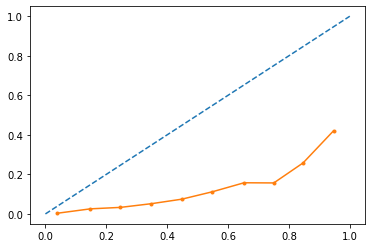

In [225]:
probs=clf_lgbm.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [51]:
params=itertools.product(np.split(np.repeat(np.arange(1,21),13),20,axis=0),np.arange(1,21))

a=[]
for i,j in params:
    s=dict(w=i,p=j)
    a.append(s)
    

In [52]:
knn=KNeighborsClassifier(n_neighbors=5,algorithm='auto',metric='wminkowski')

In [53]:
n_neighbors=np.arange(1,20)
weights=['uniform','distance']
leaf_size=np.arange(1,400)
p=[None]
metric_params=a
 
kneighbors_param=[{
            'n_neighbors':n_neighbors,
              'weights':weights,
              'leaf_size':leaf_size,
              'p':p,
              'metric_params':metric_params}]

randomized=RandomizedSearchCV(estimator=knn,  param_distributions=kneighbors_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=9,random_state=42,verbose=2)

In [54]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(metric='wminkowski'),
                   n_iter=140, n_jobs=9,
                   param_distributions=[{'leaf_size': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  5...
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 8,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 9,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 10,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])}, ...],
                                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                         'p': [None],
                                         'weights': ['uniform', 'distance']}],
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [55]:
randomized.best_params_

{'weights': 'distance',
 'p': None,
 'n_neighbors': 17,
 'metric_params': {'w': array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},
 'leaf_size': 112}

In [226]:
knn=KNeighborsClassifier(n_neighbors=17,p=None,metric='wminkowski',metric_params= {'w': np.array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},algorithm='auto',leaf_size=112,weights='distance',n_jobs=8)

knn.fit(x_train_auto,y_train)

preds=knn.predict(x_test_auto)

print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds),precision_score(y_test,preds),recall_score(y_test,preds))

#fpr, tpr, thresholds = roc_curve(y_test, preds[:,1], pos_label=1)

#plt.plot(fpr,tpr)
#plt.show()

[[4852  120]
 [ 469   64]] 0.5479699450128978 0.34782608695652173 0.1200750469043152


In [150]:
clf = TabNetClassifier(n_d=20,n_a=20,
                         n_steps=5,
                         gamma=1.3,
                         lambda_sparse=0.01,
                         momentum=0.06,
                         n_independent=2,
                         n_shared=2,
                         optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_params={"step_size":15,
                                           "gamma":0.96},
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         mask_type='entmax' # "sparsemax"
                         )

Device used : cuda


In [151]:
n_d=[20,80,100]
n_a=[20,80,100]
n_steps=[2,3,4,5,8]

gamma=np.linspace(1,1.5,10)
momentum=np.linspace(0.01,0.4,10)
lambda_sparse=np.linspace(0.001,0.01,10)




forest_param=[{'n_d':n_d,
               'n_a':n_a,
               'n_steps':n_steps,
               'gamma':gamma,
               'momentum':momentum,
               'lambda_sparse':lambda_sparse}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=40,   
                              scoring='roc_auc', cv=skf ,n_jobs=10,random_state=42,verbose=4)

fit_param=dict(weights=1,max_epochs=50,batch_size=1024,virtual_batch_size=128)

In [152]:
randomized.fit(x_train_auto,y_train,**fit_param)

Device used : cuda
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device

C:\anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

epoch 39 | loss: 0.53433 |  0:01:15s
epoch 40 | loss: 0.5349  |  0:01:17s
epoch 41 | loss: 0.53277 |  0:01:19s
epoch 42 | loss: 0.53411 |  0:01:21s
epoch 43 | loss: 0.53605 |  0:01:23s
epoch 44 | loss: 0.54017 |  0:01:24s
epoch 45 | loss: 0.53451 |  0:01:26s
epoch 46 | loss: 0.5328  |  0:01:28s
epoch 47 | loss: 0.53763 |  0:01:30s
epoch 48 | loss: 0.53422 |  0:01:32s
epoch 49 | loss: 0.53019 |  0:01:33s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=TabNetClassifier(cat_dims=[], cat_idxs=[], lambda_sparse=0.01, mask_type='entmax', momentum=0.06, n_a=20, n_d=20, n_steps=5, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.96, 'step_size': 15}),
                   n_iter=40, n_...
                   param_distributions=[{'gamma': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                                         'lambda_sparse': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ]),
                                         'momentum': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                                         'n_a': [20, 80, 100],
                                         'n_d': [20, 80, 100],
                                         'n_steps': [2, 3, 4, 5, 8]}],
                   random_state=42, scoring='roc_auc', verbose=4)

In [153]:
randomized.best_params_

{'n_steps': 8,
 'n_d': 100,
 'n_a': 20,
 'momentum': 0.4,
 'lambda_sparse': 0.004,
 'gamma': 1.2222222222222223}

In [154]:
randomized.best_score_

0.7922448679995919

In [155]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [156]:
df_randomised_result.to_csv('param_tabnet.csv')

In [157]:
print(df_randomised_result,'\n\n',randomized.best_params_)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      127.293206      1.546224         0.092353        0.016138   
1      121.866580      0.616533         0.131949        0.060888   
2      290.898421      0.572415         0.301693        0.258296   
3      201.031660      9.053057         0.374897        0.300805   
4      376.914480      7.189615         0.380382        0.262218   
5      140.775815      2.246599         0.104620        0.015518   
6      148.177640      2.326879         0.226293        0.368573   
7      423.381706      4.760215         0.681477        0.609671   
8      239.860616      4.370494         0.256115        0.369978   
9      190.297966      2.420658         0.511632        0.611178   
10     263.760309      2.462987         0.147406        0.016592   
11     142.476658      1.442811         0.092155        0.013697   
12     149.381294      1.470978         0.079988        0.009271   
13     380.024262      3.573573         0.207944

In [182]:

 
balanced_accu_tabnet=[]
auc_tabnet=[]
recall_tabnet=[]
precision_tabnet=[]
 
for train_index, test_index in skf.split(x_train_auto, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x_train_auto[train_index], x_train_auto[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    
    clf_tab = TabNetClassifier(n_d=100,n_a=20,
                         n_steps=8,
                         gamma=1.2,
                         lambda_sparse=0.004,
                         momentum=0.4,
                         n_independent=2,
                         n_shared=2,
                         optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_params={"step_size":15,
                                           "gamma":0.96},
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         mask_type='entmax' # "sparsemax"
                         )
    clf_tab.fit(X_train, Y_train,
          weights=1,
          max_epochs=300,
          eval_set=[(X_train, Y_train), (X_test, Y_test)],
          eval_name=['train', 'valid'],
          batch_size=1024, virtual_batch_size=128,
          eval_metric=['balanced_accuracy'],patience=20)
    
    preds_proba=clf_tab.predict_proba(X_test)
    
    auc_scoree=roc_auc_score(Y_test,preds_proba[:,1])
    auc_tabnet.append(auc_scoree)
    
    recall_scoree=recall_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    recall_tabnet.append(recall_scoree)
    
    precision_scoree=precision_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    precision_tabnet.append(precision_scoree)
    
    score=balanced_accuracy_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    balanced_accu_tabnet.append(score)
    
balanced_accu_array=np.array(balanced_accu_tabnet)
auc_array=np.array(auc_tabnet)
precision_array=np.array(precision_tabnet)
recall_array=np.array(recall_tabnet)

print(f'balanced_accuracy:{np.mean(balanced_accu_array)}\nAUC:{np.mean(auc_array)}\nPrecision:{np.mean(precision_array)}\nRecall:{np.mean(recall_array)}')

TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
Device used : cuda
epoch 0  | loss: 1.52893 | train_balanced_accuracy: 0.52448 | valid_balanced_accuracy: 0.52841 |  0:00:02s
epoch 1  | loss: 1.02065 | train_balanced_accuracy: 0.54993 | valid_balanced_accuracy: 0.54457 |  0:00:04s
epoch 2  | loss: 0.69915 | train_balanced_accuracy: 0.70948 | valid_balanced_accuracy: 0.70264 |  0:00:07s
epoch 3  | loss: 0.62009 | train_balanced_accuracy: 0.6837  | valid_balanced_accuracy: 0.65339 |  0:00:09s
epoch 4  | loss: 0.59957 | train_balanced_accuracy: 0.68985 | valid_balanced_accuracy: 0.67929 |  0:00:12s
epoch 5  | loss: 0.57074 | train_balanced_accuracy: 0.68037 | valid_balanced_accuracy: 0.67477 |  0:00:14s
epoch 6  | loss: 0.5492  | train_balanced_accuracy: 0.70485 | valid_balanced_accuracy: 0.68389 |  0:00:16s
epoch 7  | loss: 0.55286 | train_balanced_accuracy: 0.70958 | valid_balanced_accuracy: 0.69025 |  0:00:19s
epoch 8  | loss: 0.54439 | t

epoch 76 | loss: 0.51927 | train_balanced_accuracy: 0.74703 | valid_balanced_accuracy: 0.71638 |  0:03:04s
epoch 77 | loss: 0.51074 | train_balanced_accuracy: 0.74486 | valid_balanced_accuracy: 0.71444 |  0:03:06s
epoch 78 | loss: 0.52163 | train_balanced_accuracy: 0.74949 | valid_balanced_accuracy: 0.70774 |  0:03:09s
epoch 79 | loss: 0.52086 | train_balanced_accuracy: 0.74373 | valid_balanced_accuracy: 0.71236 |  0:03:11s
epoch 80 | loss: 0.53088 | train_balanced_accuracy: 0.74319 | valid_balanced_accuracy: 0.71838 |  0:03:13s
epoch 81 | loss: 0.52491 | train_balanced_accuracy: 0.75    | valid_balanced_accuracy: 0.71394 |  0:03:16s
epoch 82 | loss: 0.51694 | train_balanced_accuracy: 0.74751 | valid_balanced_accuracy: 0.70724 |  0:03:18s
epoch 83 | loss: 0.52105 | train_balanced_accuracy: 0.74797 | valid_balanced_accuracy: 0.71863 |  0:03:21s

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_balanced_accuracy = 0.72853
Best weights from best epoch are automatica

epoch 5  | loss: 0.55763 | train_balanced_accuracy: 0.67402 | valid_balanced_accuracy: 0.65651 |  0:00:14s
epoch 6  | loss: 0.55214 | train_balanced_accuracy: 0.68425 | valid_balanced_accuracy: 0.67301 |  0:00:17s
epoch 7  | loss: 0.55409 | train_balanced_accuracy: 0.71145 | valid_balanced_accuracy: 0.70055 |  0:00:19s
epoch 8  | loss: 0.54903 | train_balanced_accuracy: 0.71074 | valid_balanced_accuracy: 0.70516 |  0:00:21s
epoch 9  | loss: 0.55039 | train_balanced_accuracy: 0.70446 | valid_balanced_accuracy: 0.69555 |  0:00:24s
epoch 10 | loss: 0.54218 | train_balanced_accuracy: 0.72446 | valid_balanced_accuracy: 0.72712 |  0:00:26s
epoch 11 | loss: 0.5378  | train_balanced_accuracy: 0.7141  | valid_balanced_accuracy: 0.71221 |  0:00:29s
epoch 12 | loss: 0.54192 | train_balanced_accuracy: 0.72354 | valid_balanced_accuracy: 0.71044 |  0:00:31s
epoch 13 | loss: 0.54436 | train_balanced_accuracy: 0.72604 | valid_balanced_accuracy: 0.70339 |  0:00:33s
epoch 14 | loss: 0.53949 | train_bala

epoch 31 | loss: 0.51991 | train_balanced_accuracy: 0.73799 | valid_balanced_accuracy: 0.74382 |  0:01:17s
epoch 32 | loss: 0.52616 | train_balanced_accuracy: 0.73763 | valid_balanced_accuracy: 0.73016 |  0:01:20s
epoch 33 | loss: 0.5296  | train_balanced_accuracy: 0.74678 | valid_balanced_accuracy: 0.73968 |  0:01:22s
epoch 34 | loss: 0.52023 | train_balanced_accuracy: 0.73915 | valid_balanced_accuracy: 0.73647 |  0:01:25s
epoch 35 | loss: 0.52531 | train_balanced_accuracy: 0.73788 | valid_balanced_accuracy: 0.73454 |  0:01:27s
epoch 36 | loss: 0.52626 | train_balanced_accuracy: 0.73893 | valid_balanced_accuracy: 0.73329 |  0:01:30s
epoch 37 | loss: 0.51766 | train_balanced_accuracy: 0.73922 | valid_balanced_accuracy: 0.73186 |  0:01:32s
epoch 38 | loss: 0.53048 | train_balanced_accuracy: 0.74364 | valid_balanced_accuracy: 0.72546 |  0:01:35s
epoch 39 | loss: 0.52403 | train_balanced_accuracy: 0.74224 | valid_balanced_accuracy: 0.72836 |  0:01:37s
epoch 40 | loss: 0.51391 | train_bala

epoch 11 | loss: 0.53126 | train_balanced_accuracy: 0.71677 | valid_balanced_accuracy: 0.69811 |  0:00:29s
epoch 12 | loss: 0.53867 | train_balanced_accuracy: 0.71841 | valid_balanced_accuracy: 0.72622 |  0:00:31s
epoch 13 | loss: 0.53867 | train_balanced_accuracy: 0.72105 | valid_balanced_accuracy: 0.71941 |  0:00:33s
epoch 14 | loss: 0.54681 | train_balanced_accuracy: 0.72381 | valid_balanced_accuracy: 0.72622 |  0:00:36s
epoch 15 | loss: 0.52986 | train_balanced_accuracy: 0.73118 | valid_balanced_accuracy: 0.71858 |  0:00:38s
epoch 16 | loss: 0.5427  | train_balanced_accuracy: 0.72908 | valid_balanced_accuracy: 0.7232  |  0:00:41s
epoch 17 | loss: 0.53523 | train_balanced_accuracy: 0.73063 | valid_balanced_accuracy: 0.72174 |  0:00:43s
epoch 18 | loss: 0.53601 | train_balanced_accuracy: 0.72918 | valid_balanced_accuracy: 0.71412 |  0:00:45s
epoch 19 | loss: 0.53569 | train_balanced_accuracy: 0.7276  | valid_balanced_accuracy: 0.71671 |  0:00:48s
epoch 20 | loss: 0.53377 | train_bala

epoch 24 | loss: 0.52979 | train_balanced_accuracy: 0.72815 | valid_balanced_accuracy: 0.71875 |  0:01:02s
epoch 25 | loss: 0.53177 | train_balanced_accuracy: 0.73814 | valid_balanced_accuracy: 0.7217  |  0:01:05s
epoch 26 | loss: 0.53862 | train_balanced_accuracy: 0.73749 | valid_balanced_accuracy: 0.71269 |  0:01:07s
epoch 27 | loss: 0.53385 | train_balanced_accuracy: 0.72803 | valid_balanced_accuracy: 0.70344 |  0:01:09s
epoch 28 | loss: 0.53905 | train_balanced_accuracy: 0.73012 | valid_balanced_accuracy: 0.69236 |  0:01:12s
epoch 29 | loss: 0.53303 | train_balanced_accuracy: 0.73401 | valid_balanced_accuracy: 0.70619 |  0:01:14s
epoch 30 | loss: 0.53651 | train_balanced_accuracy: 0.73368 | valid_balanced_accuracy: 0.71816 |  0:01:17s
epoch 31 | loss: 0.5377  | train_balanced_accuracy: 0.73254 | valid_balanced_accuracy: 0.71678 |  0:01:19s
epoch 32 | loss: 0.5359  | train_balanced_accuracy: 0.73577 | valid_balanced_accuracy: 0.71542 |  0:01:21s
epoch 33 | loss: 0.53638 | train_bala

epoch 36 | loss: 0.5273  | train_balanced_accuracy: 0.73431 | valid_balanced_accuracy: 0.73122 |  0:01:28s
epoch 37 | loss: 0.53534 | train_balanced_accuracy: 0.73535 | valid_balanced_accuracy: 0.74581 |  0:01:31s
epoch 38 | loss: 0.52885 | train_balanced_accuracy: 0.73739 | valid_balanced_accuracy: 0.73835 |  0:01:33s

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_balanced_accuracy = 0.74916
Best weights from best epoch are automatically used!
TRAIN: [    0     1     2 ... 22014 22015 22016] TEST: [   11    13    24 ... 21998 22006 22010]
Device used : cuda
epoch 0  | loss: 1.36239 | train_balanced_accuracy: 0.5     | valid_balanced_accuracy: 0.5     |  0:00:02s
epoch 1  | loss: 1.20652 | train_balanced_accuracy: 0.52261 | valid_balanced_accuracy: 0.52565 |  0:00:04s
epoch 2  | loss: 0.68489 | train_balanced_accuracy: 0.64742 | valid_balanced_accuracy: 0.64655 |  0:00:07s
epoch 3  | loss: 0.59342 | train_balanced_accuracy: 0.6313  | valid_balanced_accuracy: 0

epoch 72 | loss: 0.52164 | train_balanced_accuracy: 0.73955 | valid_balanced_accuracy: 0.73147 |  0:02:54s
epoch 73 | loss: 0.52798 | train_balanced_accuracy: 0.74242 | valid_balanced_accuracy: 0.73583 |  0:02:57s
epoch 74 | loss: 0.52206 | train_balanced_accuracy: 0.74334 | valid_balanced_accuracy: 0.73097 |  0:02:59s
epoch 75 | loss: 0.52308 | train_balanced_accuracy: 0.74049 | valid_balanced_accuracy: 0.73097 |  0:03:02s
epoch 76 | loss: 0.52042 | train_balanced_accuracy: 0.74038 | valid_balanced_accuracy: 0.73164 |  0:03:04s
epoch 77 | loss: 0.52169 | train_balanced_accuracy: 0.74067 | valid_balanced_accuracy: 0.7298  |  0:03:06s
epoch 78 | loss: 0.52395 | train_balanced_accuracy: 0.74069 | valid_balanced_accuracy: 0.73784 |  0:03:09s
epoch 79 | loss: 0.52541 | train_balanced_accuracy: 0.74147 | valid_balanced_accuracy: 0.72351 |  0:03:11s
epoch 80 | loss: 0.5276  | train_balanced_accuracy: 0.74112 | valid_balanced_accuracy: 0.72611 |  0:03:14s
epoch 81 | loss: 0.53071 | train_bala

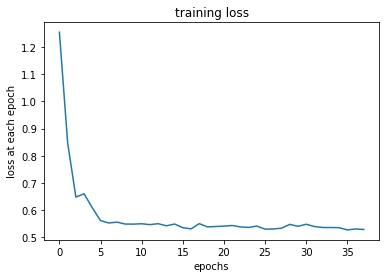

In [183]:
plt.plot(clf_tab.history['loss'])
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss at each epoch')
plt.show()

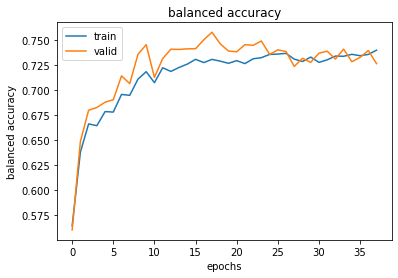

In [184]:
plt.plot(clf_tab.history['train_balanced_accuracy'],label='train')
plt.plot(clf_tab.history['valid_balanced_accuracy'],label='valid')
plt.title('balanced accuracy')
plt.xlabel('epochs')
plt.ylabel('balanced accuracy')
plt.legend(loc='upper left')
plt.show()

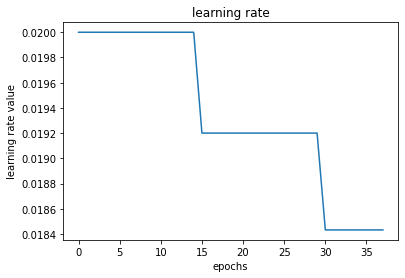

In [185]:
plt.plot(clf_tab.history['lr'])
plt.title('learning rate')
plt.xlabel('epochs')
plt.ylabel('learning rate value')
plt.show()

In [186]:
preds = clf_tab.predict(x_test_auto)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds),precision_score(y_test,preds),recall_score(y_test,preds))

[[3118 1854]
 [  95  438]] 0.7244377142391387 0.19109947643979058 0.8217636022514071


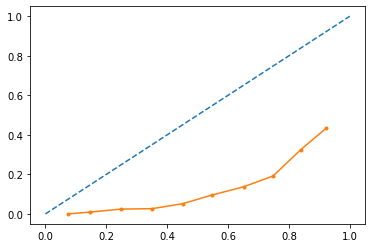

In [187]:
probs=clf_tab.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

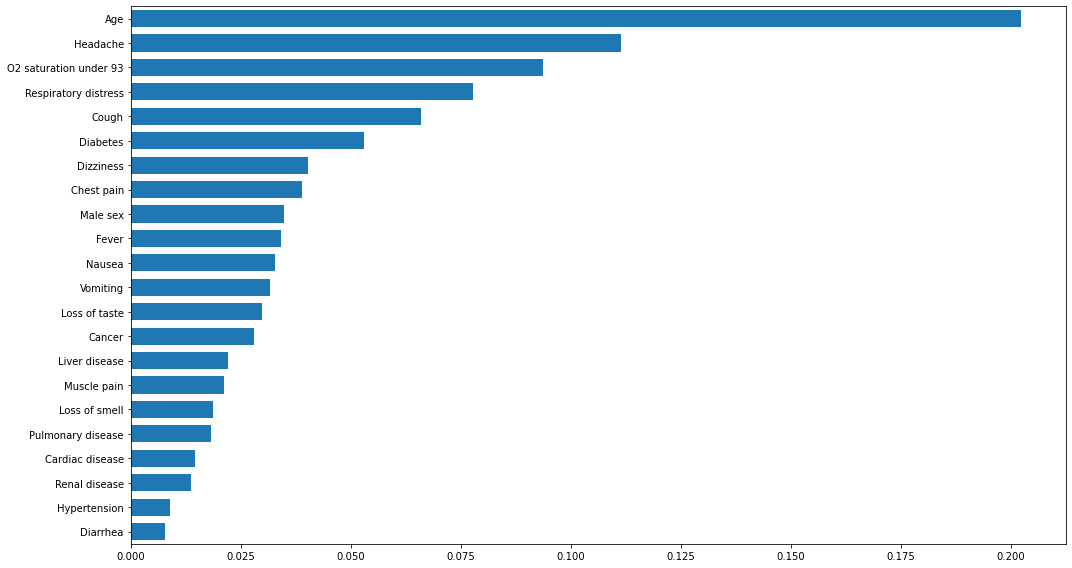

array([0.20234034, 0.03490627, 0.03424428, 0.06583896, 0.02112373,
       0.07786691, 0.0187551 , 0.0297823 , 0.11136447, 0.04034275,
       0.03880738, 0.03286455, 0.03169383, 0.00776469, 0.0935881 ,
       0.02808526, 0.02207248, 0.05309908, 0.01461465, 0.01360245,
       0.01825889, 0.00898355])

In [188]:
tree_importance_sorted_idx = np.argsort(clf_tab.feature_importances_)
tree_indices = np.arange(0, clf_tab.feature_importances_.shape[0]) + 0.5

#tree_labels= df_ext.columns.array[[0,1,4,5,6,10,19,22,27,31,32]]
#tree_labels=tree_labels[1:]

#tree_labels1=tree_labels[:-1]
#tree_labels2=np.append(tree_labels1,['epil0','epil1','epil2','epil3'])

fig,ax1 = plt.subplots(figsize=(15, 8))

ax1.barh(tree_indices,
         clf_tab.feature_importances_[tree_importance_sorted_idx], height=0.7)

ax1.set_yticks(tree_indices)
ax1.set_yticklabels(column_importance[tree_importance_sorted_idx])
ax1.set_ylim((0,clf_tab.feature_importances_.shape[0]))


fig.tight_layout()
plt.show()







clf_tab.feature_importances_

In [120]:
saving_path_name = "./tabnet_model"
saved_filepath = clf_tab.save_model(saving_path_name)
#clf_tab2 = TabNetClassifier()
#clf_tab2.load_model('test/tabnet_model_denoise.zip')

Successfully saved model at ./tabnet_model.zip


In [33]:
explain_matrix, masks = loaded_clf.explain(x_test_denoise)

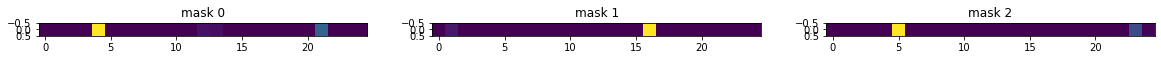

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i])
    axs[i].set_title(f"mask {i}")

In [197]:
#models  selection
# random forest
clf_random=RandomForestClassifier(n_estimators=2829,min_samples_split=0.051,
                                                                min_samples_leaf=0.03628,
                                                               max_features='sqrt',
                                                               max_depth=1832,
                                                               criterion='gini',
                                                               class_weight='balanced_subsample',
                                                               bootstrap=True)

scores_random=cross_validate(clf_random,x_train_auto,y_train,cv=skf,
                             scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

#logistic regression
clf_log_regression=LogisticRegression(penalty='elasticnet',C=7.9,solver='saga',
                                      class_weight='balanced',l1_ratio=0.864,max_iter=900)

scores_log_regression=cross_validate(clf_log_regression,x_train_auto,y_train,cv=skf,
                                      scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

# svm
clf_svc=svm.SVC(C=0.536,kernel='linear',degree=3,gamma=0.34,coef0=4.05,shrinking=True,class_weight='balanced')

scores_svc=cross_validate(clf_svc,x_train_auto,y_train,cv=skf,
                           scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

# knn
knn=KNeighborsClassifier(n_neighbors=17,p=None,metric='wminkowski',
                         metric_params= {'w': np.array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},algorithm='auto',leaf_size=112,weights='distance',n_jobs=8)

scores_knn=cross_validate(knn,x_train_auto,y_train,cv=skf,
                           scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

#lgbm
scores_balanced_lgbm=np.array(balanced_accu_lgbm)
scores_auc_lgbm=np.array(auc_lgbm)
scores_precision_lgbm=np.array(precision_lgbm)
scores_recall_lgbm=np.array(recall_lgbm)

#tabnet
scores_balanced_tabnet=np.array(balanced_accu_tabnet)
scores_auc_tabnet=np.array(auc_tabnet)
scores_precision_tabnet=np.array(precision_tabnet)
scores_recall_tabnet=np.array(recall_tabnet)

# neural net







In [41]:
scores_random.keys()

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_roc_auc', 'test_precision', 'test_recall'])

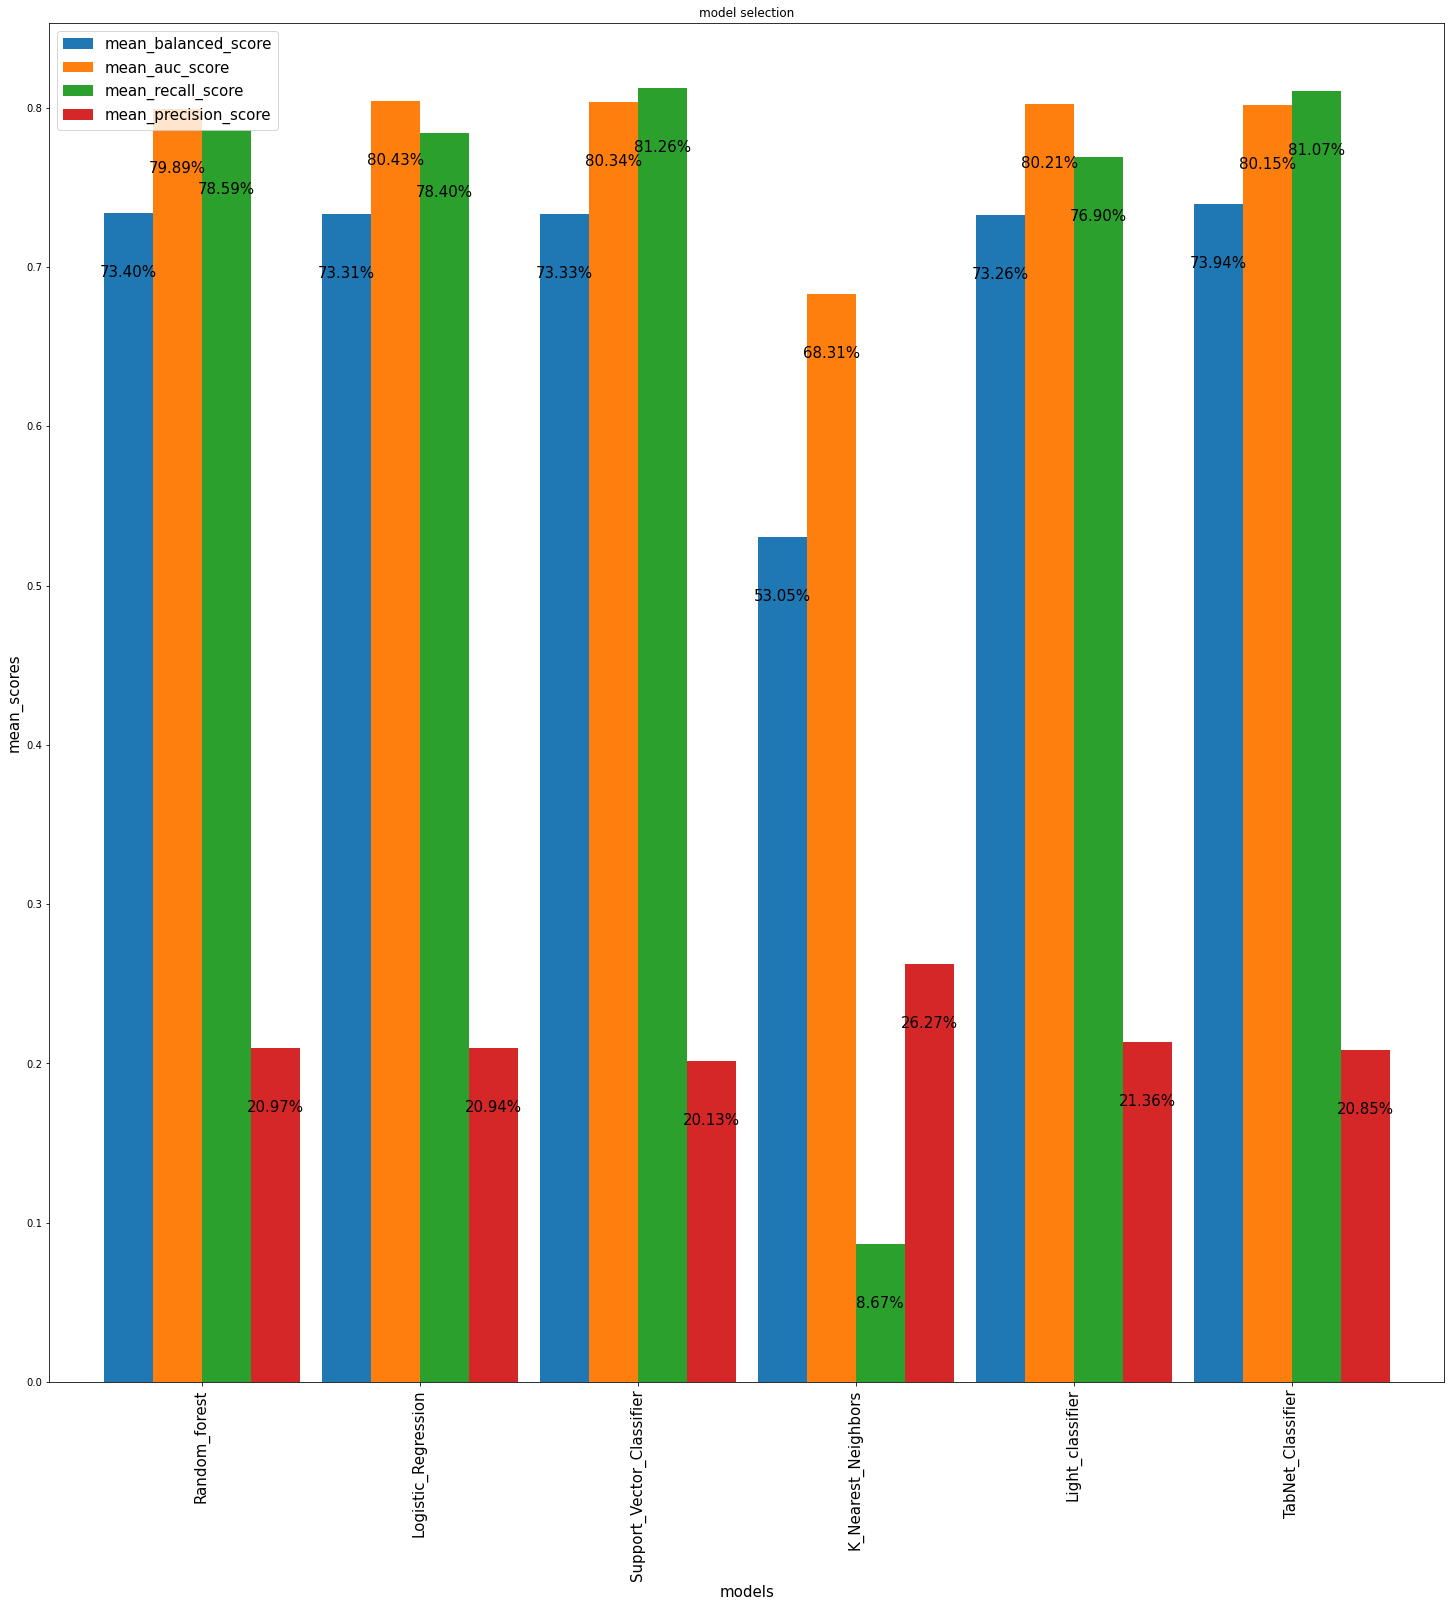

In [198]:
df_models=pd.DataFrame({'mean_balanced_score':[np.mean(scores_random['test_balanced_accuracy'],axis=0),
                                               np.mean(scores_log_regression['test_balanced_accuracy'],axis=0),
                                      np.mean(scores_svc['test_balanced_accuracy'],axis=0),
                                               np.mean(scores_knn['test_balanced_accuracy'],axis=0),
                                      np.mean(scores_balanced_lgbm,axis=0),np.mean(scores_balanced_tabnet,axis=0)],
                        
                        'mean_auc_score':[np.mean(scores_random['test_roc_auc'],axis=0),
                                          np.mean(scores_log_regression['test_roc_auc'],axis=0),
                                      np.mean(scores_svc['test_roc_auc'],axis=0),
                                          np.mean(scores_knn['test_roc_auc'],axis=0),
                                      np.mean(scores_auc_lgbm,axis=0),np.mean(scores_auc_tabnet,axis=0)]   ,
                        
                        'mean_recall_score': [np.mean(scores_random['test_recall'],axis=0),
                                          np.mean(scores_log_regression['test_recall'],axis=0),
                                      np.mean(scores_svc['test_recall'],axis=0),
                                          np.mean(scores_knn['test_recall'],axis=0),
                                      np.mean(scores_recall_lgbm,axis=0),np.mean(scores_recall_tabnet,axis=0)]  ,
                        
                        'mean_precision_score':[np.mean(scores_random['test_precision'],axis=0),
                                          np.mean(scores_log_regression['test_precision'],axis=0),
                                      np.mean(scores_svc['test_precision'],axis=0),
                                          np.mean(scores_knn['test_precision'],axis=0),
                                      np.mean(scores_precision_lgbm,axis=0),np.mean(scores_precision_tabnet,axis=0)] },
                       
                       index=np.array(['Random_forest','Logistic_Regression','Support_Vector_Classifier',
                                       'K_Nearest_Neighbors','Light_classifier','TabNet_Classifier']) )

plot=df_models.plot(kind='bar',rot=90,width=0.9,figsize=(25,25))

for p in plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    
    plot.annotate(f'{100*height:.2f}%', (x + 0.5*width, y + height-0.04), ha='center',fontsize=15)
    
plot.set_xticklabels(df_models.index,fontsize=15)    
plt.legend(loc='upper left',fontsize=15)
plt.title('model selection')
plt.xlabel('models',fontsize=15)
plt.ylabel('mean_scores',fontsize=15)
plt.show()

In [207]:
u,p=stats.wilcoxon(scores_balanced_tabnet,scores_balanced_lgbm,zero_method='zsplit',mode='approx',alternative='greater')

print(f'wilcoxon:{u}\np-value:{p:.2f}')

wilcoxon:48.0
p-value:0.02


In [354]:
log_reg=scores_log_regression['test_balanced_accuracy']

In [355]:
print(f'std_tabnet: {np.std(scores_recall_tabnet,axis=0)}\nstd_LightGBM: {np.std(scores_balanced_lgbm,axis=0)}\nstd_logistic: {np.std(log_reg,axis=0)}')

std_tabnet: 0.04334023037317688
std_LightGBM: 0.009606966824919922
std_logistic: 0.014286490061194337
